# Funcoes para manipular a base de dados 

Dados do xml dos usuarios FILE.xml

In [19]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 997 µs


In [20]:


import pandas as pd
import xml.etree.ElementTree as et
import os

def parse_XML(xml_file):

    df_cols = ["UserGenere", "UserAge", "UserExperience", "UserSymptoms", "UserFlicker", "UserGlassesUse", "UserVisionProblems", "UserPosture", "UserEyeDominance", "StaticFrame", "HapticFeedback", "DegreeOfControl", "DofSimulation", "Locomotion", "CameraAutoMovement", "RegionOfInterest", "TimeStamp", "CameraFieldOfView", "PlayerSpeed", "PlayerAcceleration", "CameraRotationX", "CameraRotationY", "CameraRotationZ", "PlayerPositionX", "PlayerPositionY", "PlayerPositionZ", "GameFps", "DiscomfortLevel"]
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []   
    for node in xroot: 
        res = []
        for el in df_cols: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)        
    return out_df


def parseXmlDirToDataFrame(dir, out = [], debug = False):
    base = dir
    dirs = os.listdir(base)
    data = pd.DataFrame()
    data_out = pd.DataFrame()
    out_training = []
    in_training = []
    

    #print('parseXmlDirDataFrame -> out', out)
    for label in dirs:
        if label in out :
            #print('label out:',label)
            out_training.append(label)
            for i, fn in enumerate(os.listdir(os.path.join(base, label))):
                if (debug == True):
                    print(os.path.join(base, label, fn))
                df_out = parse_XML(os.path.join(base, label, fn))
                data_out = pd.concat([data_out, df_out])
        else:
            #print('label in:',label)
            in_training.append(label)
            for i, fn in enumerate(os.listdir(os.path.join(base, label))):
                if (debug == True):
                    print(os.path.join(base, label, fn))
                df = parse_XML(os.path.join(base, label, fn))
                data = pd.concat([data, df])
                
        data = data.drop_duplicates().reset_index(drop=True)
        data_out = data_out.drop_duplicates().reset_index(drop=True)
    
    #print('df',data)
    #print('df_out',data_out)
    result = [data, in_training, out_training,data_out]    
    return result


def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None

#Essa funcao so serve para eu conferir se os valores de predicao estao parecidos com os valores reais inputados pelos usuarios
def XmlToDataFrameDiscomfort(path):
    # ler e mapeaia a base de dados de xml
    """ main """
    parsed_xml = et.parse(path)
    dfcols = ['DiscomfortLevel']
    df_xml = pd.DataFrame(columns=dfcols)
    for node in parsed_xml.getroot():
        discomfortLevel = node.find('DiscomfortLevel')
        df_xml = df_xml.append(
            pd.Series([str(getvalueofnode(discomfortLevel)).replace(',','.'),
                      ], index=dfcols),
            ignore_index=True)
    base = df_xml
    #Caso o XML possua valores maiores que 1 na coluna discomfortlevel eu converto para 1 (discomfort binario)
    value = base.DiscomfortLevel.astype('int64',copy=False)
    boolean_condition = value > 1
    column_name = "DiscomfortLevel"
    new_value = "1"
    base.loc[boolean_condition, column_name] = new_value 
    return base

time: 7.96 ms


dados do VRSQ

In [21]:
import pandas as pd
import xml.etree.ElementTree as et
import os

#https://dl.uswr.ac.ir/bitstream/Hannan/40901/1/2018%20AppliedErgonomics%20Volume%2069%20May%20%2821%29.pdf
def VRSQScore(df, mode = 'oculumotor'):
    print(df)
    if (mode == 'oculumotor'):
        div = 12
        columns = ["GeneralDiscomfort", "Fatigue", "EyeStraing", "DifficultyFocusing"]
    if (mode == 'disorientation'):
        div = 15
        columns = ["Headache","FulnessOfHead", "BlurredVision", "DizzyEyesClosed", "Vertigo"]
    
    countBefore = 0
    countAfter = 0
    
    for c in columns:
        #print(c)
        for index, row in df.iterrows():        
            if (index == 0):
                before = int(row[c])
            if (index == 1):
                after = int(row[c])
        countBefore = countBefore + before
        countAfter = countAfter + after

    scoreBefore = ((countBefore/div)*100)
    scoreAfter = ((countAfter/div)*100)
    finalScore = scoreAfter - scoreBefore
    #print(finalScore)
    return finalScore

def GetDFScoresVRSQ(df):
    oculumotor = VRSQScore(df, 'oculumotor')
    disorientation = VRSQScore(df, 'disorientation')
    total = (oculumotor + disorientation)/2
    dataframe = pd.DataFrame({'oculumotor':[oculumotor], 'disorientation':[disorientation], 'total':[total]})
    return dataframe


def parse_XML_VRSQ(xml_file):
    df_cols = ["GeneralDiscomfort", "Fatigue", "EyeStraing", "DifficultyFocusing", "Headache",
               "FulnessOfHead", "BlurredVision", "DizzyEyesClosed", "Vertigo"]
    
    #print(xml_file)
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []   
    for node in xroot: 
        res = []
        for el in df_cols: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
    
    result = GetDFScoresVRSQ(out_df)
    return result

def parseXmlVRSQDirToDataFrame(dir, debug = False):
    base = dir
    dirs = os.listdir(base)
    data = pd.DataFrame()
    #print('parseXmlDirDataFrame -> dir', dir)
    for label in dirs:
        for i, fn in enumerate(os.listdir(os.path.join(base, label))):
            if (debug == True):
                print(os.path.join(base, label, fn))
            df = parse_XML_VRSQ(os.path.join(base, label, fn))
            data = pd.concat([data, df], ignore_index=True)
    result = data
    return [result,df]



time: 6.98 ms


# Funcoes para fazer o PRE PROCESSAMENTO 

Pre processamento dos dados do dataframe


In [22]:
#https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769

def PreProcessDataFrame(df, dropAttributes = [],debug = False):
    #df = oversampling(df)
    #descarto os atributos que nao vao ser utilizados no treinamento
    
    if 'UserFlicker' in df:
        df = df.drop('UserFlicker', axis=1)     
    if 'DegreeOfControl' in df:
        df = df.drop('DegreeOfControl', axis=1)
    if 'UserPosture' in df:
        df = df.drop('UserPosture', axis=1)
    if 'UserSymptoms' in df:
        df = df.drop('UserSymptoms', axis=1)
    if 'UserGlassesUse' in df:
        df = df.drop('UserGlassesUse', axis=1)
    if 'UserVisionProblems' in df:
        df = df.drop('UserVisionProblems', axis=1)
    if 'UserEyeDominance' in df:
        df = df.drop('UserEyeDominance', axis=1)
    if 'StaticFrame' in df:
        df = df.drop('StaticFrame', axis=1)
    if 'RegionOfInterest' in df:
        df = df.drop('RegionOfInterest', axis=1)

    if 'HapticFeedback' in df:    
        df = df.drop('HapticFeedback', axis=1)
    if 'DofSimulation' in df:
        df = df.drop('DofSimulation', axis=1)
    if 'Locomotion' in df:
        df = df.drop('Locomotion', axis=1)
    if 'CameraAutoMovement' in df:
        df = df.drop('CameraAutoMovement', axis=1)
    if 'CameraFieldOfView' in df:
        df = df.drop('CameraFieldOfView', axis=1)
    if 'CameraRotationX' in df:
        df = df.drop('CameraRotationX', axis=1)
    if 'CameraRotationY' in df:
        df = df.drop('CameraRotationY', axis=1)
    if 'PlayerPositionX' in df:
        df = df.drop('PlayerPositionX', axis=1)
    if 'PlayerPositionY' in df:
        df = df.drop('PlayerPositionY', axis=1)
    if 'PlayerPositionZ' in df:
        df = df.drop('PlayerPositionZ', axis=1)

    if 'UserGenere' in df:    
        #Faco o encoding/ mapping dos valores de atributos categoricos
        df['UserGenere'].unique()
        mapping = {'masculino':1, 'feminino':0}   
        df['UserGenere'] = df.apply(lambda row: mapping[row['UserGenere']], axis=1)
    
    #df['UserGenere'] = df.UserGenere.map({'masculino':1.0, 'feminino':0.0})
    #nominalFeature = pd.get_dummies(df.UserGenere)  
    
    if 'UserAge' in df:
        df['UserAge'].unique()
        mapping = {'18 A 36':0, '37 A 50':1, '+50':1}
        df['UserAge'] = df.apply(lambda row: mapping[row['UserAge']], axis=1)
        
        
    if 'UserExperience' in df:    
        df['UserExperience'].unique()
        mapping = {'NENHUMA':0, 'ALGUMA':1}
        df['UserExperience'] = df.apply(lambda row: mapping[row['UserExperience']], axis=1) 
    
    if 'DiscomfortLevel' in df:     
        df['DiscomfortLevel'].unique()
        mapping = {'0':0, '1':1, '2':1, '3':1}
        df['DiscomfortLevel'] = df.apply(lambda row: mapping[row['DiscomfortLevel']], axis=1)

    
    #Defino os tipos de cada um dos atributos, categoricos e numericos
    if 'UserGenere' in df:  
        df['UserGenere'] = df['UserGenere'].astype('category',copy=True)
    if 'UserAge' in df:  
        df['UserAge'] = df['UserAge'].astype('category',copy=False)
    if 'UserExperience' in df:  
        df['UserExperience'] = df['UserExperience'].astype('category',copy=False)
    if 'TimeStamp' in df:  
        df['TimeStamp'] = df['TimeStamp'].astype('float',copy=False)
    if 'CameraRotationZ' in df:  
        df['CameraRotationZ'] = df['CameraRotationZ'].astype('float',copy=False)
    if 'PlayerSpeed' in df:  
        df['PlayerSpeed'] = df['PlayerSpeed'].astype('int64',copy=False)
    if 'PlayerAcceleration' in df:  
        df['PlayerAcceleration'] = df['PlayerAcceleration'].astype('int',copy=False)
    if 'GameFps' in df:  
        df['GameFps'] = df['GameFps'].astype('int64',copy=False)
    if 'DiscomfortLevel' in df:  
        df['DiscomfortLevel'] = df['DiscomfortLevel'].astype('int64',copy=False)
    if (debug == True):
        print(df.dtypes)
    if (debug == True):
        print("Droped Attributes ", dropAttributes)
    if (len(dropAttributes) > 0):
        for i in range (len(dropAttributes)):
             if dropAttributes[i] in df:
                 df = df.drop(dropAttributes[i], axis=1)
    
    return df

def oversampling(df, debug = False):
    # Contagem das classes
    count_class_0, count_class_1 = df["DiscomfortLevel"].value_counts()
    # separacao de classes
    df_class_0 = df[df["DiscomfortLevel"] == 0]
    df_class_1 = df[df["DiscomfortLevel"] == 1]
    if (debug == True):
        print(f"0: {count_class_0}   1: {count_class_1}") 
    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    df_oversampled = pd.concat([df_class_0, df_class_1_over], axis=0)
    if (debug == True):
        print('Random over-sampling:')
        print(df_oversampled["DiscomfortLevel"].value_counts())
    return df_oversampled


def histBalanc(df):
    plt.hist(df['DiscomfortLevel'])
    plt.tight_layout()
    plt.ylabel('instâncias')
    plt.xlabel('0 - Sem Desconforto | 1 - Com Desconforto')
    plt.title('Balanceamento da classe DiscomfortLevel')

   


time: 10 ms


# Funcoes de TREINAMENTO 

1. Decision Tree

In [23]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib
from sklearn.metrics import classification_report
import graphviz
import numpy as np
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
#tree = DecisionTreeClassifier()
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
#one_hot_data = pd.get_dummies(data[['A','B','C']],drop_first=True)
#tree.fit(one_hot_data, data['Class'])

#https://www.dezyre.com/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python
#https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
def CSDecisionTreeTraining(df,attributes, depth, _test_size = 0.3, df_out = None, Title2="", CV=False):
    max_depth_value = depth
    attributesNames = attributes
    classNames = ['None', 'Discomfort']
    dt=tree.DecisionTreeClassifier(max_depth=max_depth_value)
    dt.fit(df.iloc[:,:-1].values,df.iloc[:,-1].values)
    fn=attributesNames
    cn=classNames
    
    userInstances = df.shape[0] 
    if type(df_out) is not type(None):
        title = "User Adapt LeaveOneOut - Train:100% A, Test:100% B"
        
        #data frame de treino
        X_train = df.iloc[:,:-1].values
        y_train = df.iloc[:,-1].values
        
        #data frame do user que fica de fora do treino
        X_test = df_out.iloc[:,:-1].values
        y_test = df_out.iloc[:,-1].values
        
        userInstances = df_out.shape[0] 
        
        dt.fit(X_train,y_train)
        y_pred=dt.predict(X_test)
    else:
        title = "Normal Training Varing User - Train:70% A, Test: 30% A"
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=_test_size, shuffle=True)
        
    if (CV == True):
        # fitting trees of depth 1 to 21
        sm_tree_depths = range(7,22)
        sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

        # plotting accuracy
        plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy by Decision tree depth on training data - User ID: ', Title2)
        
        
        idx_max = sm_cv_scores_mean.argmax()
        sm_best_tree_depth = sm_tree_depths[idx_max]
        sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
        sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
        print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
          sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

        dt=tree.DecisionTreeClassifier(max_depth=sm_best_tree_depth)
    
    dt.fit(X_train,y_train)
    y_pred=dt.predict(X_test)
    
    print(title)
    if type(df_out) is not type(None):
        print('number instances (B) = ', userInstances)
    
    print('X_train = ' + str(len(X_train)) + ' , ' +
          'X_test = ', str(len(X_test)) + ' , ' +
          'y_train = '+ str(len(y_train)) + ' , ' +
          'y_test = '+ str(len(y_test)) + ' , ' +
          'y_pred = ' + str(len(y_pred)) )
    
    
    #Get the minimum value of samples in leafs
    from collections import Counter
    #get the leaf for each training sample
    leafes_array = dt.apply(X_train) 
    
    min_value = min(leafes_array)
    print('Depth: ' + str(depth))
    print('Minimum Leaf Sample:' +  str(min(leafes_array)))
    
    dot_data = tree.export_graphviz(dt, out_file=None,
        feature_names=fn,
        class_names=cn,
        filled=True, rounded=True,
        special_characters=True)
    

    result = [dt, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value,min_value,dot_data]
    return result;


def ShowReports(dtModel,X_train, X_test, y_train, y_test, y_pred, fn, cn, debugDetails = False):
    # Imprimo os reports
    report = classification_report(y_test, y_pred, output_dict=True )
    dot_data = tree.export_graphviz(dtModel, out_file=None,
        feature_names=fn,
        class_names=cn,
        filled=True, rounded=True,
        special_characters=True)
    if (debugDetails == True):
        print(classification_report(y_test, y_pred))   
    results = [report, dot_data, metrics.confusion_matrix(y_test,y_pred)]
    return results

time: 10 ms


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title, title2):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title + title2, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    plt.savefig(os.path.join('CV ' + str(title2)+' .png'),
                dpi=300, format='png', bbox_inches='tight') 


time: 2.99 ms


2. Random Forests

In [25]:
import platform
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import time
from scipy.stats import randint as sp_randint
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, SCORERS
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.externals import joblib
from operator import itemgetter
from tabulate import tabulate

def CSRanfomForestTraining(df, attributes, depth, _test_size=0.3, df_out=None, Title2=""):
    max_depth_value = depth
    attributesNames = attributes
    classNames = ['None', 'Discomfort']
    rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=depth, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=3,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False)
    rf.fit(df.iloc[:,:-1].values,df.iloc[:,-1].values)
    fn=attributesNames
    cn=classNames
    
    userInstances = df.shape[0] 
    if type(df_out) is not type(None):
        title = "User Adapt LeaveOneOut - Train:100% A, Test:100% B"
        
        #data frame de treino
        X_train = df.iloc[:,:-1].values
        y_train = df.iloc[:,-1].values
        
        #data frame do user que fica de fora do treino
        X_test = df_out.iloc[:,:-1].values
        y_test = df_out.iloc[:,-1].values
        
        userInstances = df_out.shape[0] 
        
        rf.fit(X_train,y_train)
        y_pred=rf.predict(X_test)
    else:
        title = "Normal Training - Train:70% A, Test: 30% A"
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=_test_size, shuffle=True)
        rf.fit(X_train,y_train)
        y_pred=rf.predict(X_test)
        
 
    print(title)
    if type(df_out) is not type(None):
        print('number instances (B) = ', userInstances)
    
    print('X_train = ' + str(len(X_train)) + ' , ' +
          'X_test = ', str(len(X_test)) + ' , ' +
          'y_train = '+ str(len(y_train)) + ' , ' +
          'y_test = '+ str(len(y_test)) + ' , ' +
          'y_pred = ' + str(len(y_pred)) )

    
    param_grid = { 
        'n_estimators': [50],
        'max_features': ['auto']
    }

    CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, y_train)
    print ('Best Parameters ', CV_rfc.best_params_)


    result = GetCustomAucScoresRF(CV_rfc.best_estimator_,X_train, X_test, y_train, y_test, y_pred)
    
    aucTrain = result[0]
    aucTest = result[1]

    y_test_score = result[8]
    #print("aucTrain >>>",result[0])
    #print("aucTest >>>",result[1])
    
    acc = accuracy_score(y_test, CV_rfc.best_estimator_.predict(X_test))
    
    #Print_Metrics(CV_rfc.best_estimator_,X_train, X_test, y_train, y_test, y_pred,attributesNames,Title2)
    
    
    
    result = [rf, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value,
              aucTrain, aucTest, acc, y_test_score]
    return result;

#Not used
def plot_each_decision_tree_from_rf(rf, x_train_values):
    X_train = x_train_values
    sample_id = 0
    for j, tree in enumerate(rf.estimators_):
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold
        print("Decision path for DecisionTree {0}".format(j))
        node_indicator = tree.decision_path(X_train)
        leave_id = tree.apply(X_train)
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]
        print('Rules used to predict sample %s: ' % sample_id)
        for node_id in node_index:
            if leave_id[sample_id] != node_id:
                continue
            if (X_train[sample_id, feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"
            print("decision id node %s : (X_train[%s, %s] (= %s) %s %s)"
                  % (node_id,
                     sample_id,
                     feature[node_id],
                     X_train[sample_id, feature[node_id]],
                     threshold_sign,
                     threshold[node_id]))

            
def RF_ROC_Curve(rf, auc,X_train,X_test, y_train, y_test, y_test_score, Title2=""):
    one_hot_encoder = OneHotEncoder()
    rf_fit = rf.fit(X_train, y_train)
    fit = one_hot_encoder.fit(rf.apply(X_train))
    #y_predicted = rf.predict_proba(X_test)[:, 1]
    false_positive, true_positive, _ = roc_curve(y_test, y_test_score)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(' ROC curve (area = %0.2f)' % auc + ' User ID: ' + str(Title2))
    plt.legend(loc='best')
    plt.savefig(os.path.join('Roc '+str(Title2)+'.png'),
                dpi=300, format='png', bbox_inches='tight') 
    plt.show()
    

 

def Print_Metrics(best_model, X_train, X_test,y_train, y_test, y_predict_test,feature_columns, Title2 = ""):
    print('\nModel performance on the test data set:')
    print('Train Accuracy.......', accuracy_score(y_train, best_model.predict(X_train)))
    print('Validate Accuracy....', accuracy_score(y_test, best_model.predict(X_test)))

    y_predict_test  = best_model.predict(X_test)
    y_train_score   = best_model.predict_proba(X_train)[:, 1]
    mse             = metrics.mean_squared_error(y_test, y_predict_test)
    #logloss_test    = metrics.log_loss(y_test, y_predict_test)
    accuracy_test   = metrics.accuracy_score(y_test, y_predict_test)
    accuracy_test2  = best_model.score(X_test, y_test)
    F1_test         = metrics.f1_score(y_test, y_predict_test)
    precision_test  = precision_score(y_test, y_predict_test, average='binary')
    precision_test2 = metrics.precision_score(y_test, y_predict_test)
    recall_test     = recall_score(y_test, y_predict_test, average='binary')
    r2_test         = metrics.r2_score(y_test, y_predict_test)

    header = ["Metric", "Test"]
    table  = [
       ["accuracy",  accuracy_test],
       ["precision", precision_test],
       ["F1",        F1_test],
       ["r2",        r2_test],
     ]
    print(feature_columns)
    print(best_model.feature_importances_)
    print(tabulate(table, header, tablefmt="fancy_grid"))
    Plot_predictor_importance(best_model,feature_columns)



def Plot_predictor_importance(best_model, feature_columns):
    feature_importances = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    y_pos  = np.arange(sorted_idx.shape[0]) + .5
    fig, ax = plt.subplots()
    ax.barh(y_pos, 
            feature_importances[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_columns)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Importance')
    ax.set_title('Predictor Importance')
    plt.show()

time: 26.9 ms


In [26]:
def TrainingProcessWithReport(trainingDatabase,outf = [], outu = [],depth=9, customTest = False, CV = False):
    result = parseXmlDirToDataFrame(trainingDatabase,outu)
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    #print(df_out)
    #df = parseXmlDirToDataFrame('DATABASE_PASSARO/')
    df = PreProcessDataFrame(df,outf)
    df = oversampling(df)
    dt_deep = depth
    
    if (customTest == True):
        df_out = PreProcessDataFrame(df_out,outf)
    
    #Training
    attributes = df.columns[:-1]
    
    
    if len(outu) == 0:
        title = ""
    else:
        title = outu[0]
    
    if (customTest == True):
        #print('Traning Process -> Custom Test True')
        DecisionTreeResults = CSDecisionTreeTraining(df,attributes,dt_deep,0.3,df_out,title,CV)
    else:
        DecisionTreeResults = CSDecisionTreeTraining(df,attributes,dt_deep,0.3,None,title,CV)
           
    # result = [dt, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value]
    dtModel = DecisionTreeResults[0]
    X_train= DecisionTreeResults[1]
    X_test= DecisionTreeResults[2]
    y_train= DecisionTreeResults[3]
    y_test= DecisionTreeResults[4]
    y_pred = DecisionTreeResults[5]
    fn = DecisionTreeResults[6]
    cn = DecisionTreeResults[7]
    attributesNames = DecisionTreeResults[8]
    max_depth_value = DecisionTreeResults[9]
    min_leaf_value = DecisionTreeResults[10]
    
    print('in training(fn): ' , attributes.tolist())
    print('in training(users): ' , in_training)
    
    reportResults = ShowReports(dtModel,X_train, X_test, y_train, y_test, y_pred,fn,cn, True)
    classificationReport = reportResults[0]
    dotData = reportResults[1]
   
    #print('Out of Training :', out_training)
    results = [dtModel, attributes.tolist(), in_training,
               classificationReport, fn, dotData, X_train, X_test, y_train, y_test, y_pred, min_leaf_value]
    return results
    
def RFTrainingProcessWithReport(trainingDatabase,outf = [], outu = [],depth=9, customTest = False):
    result = parseXmlDirToDataFrame(trainingDatabase,outu)
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    #print(df_out)
    #df = parseXmlDirToDataFrame('DATABASE_PASSARO/')
    df = PreProcessDataFrame(df,outf)
    df = oversampling(df)
    dt_deep = depth
    
    if (customTest == True):
        df_out = PreProcessDataFrame(df_out,outf)
    
    #Training
    attributes = df.columns[:-1]
    
    if (customTest == True):
        #print('Traning Process -> Custom Test True')
        RFResults = CSRanfomForestTraining(df,attributes.values,dt_deep,0.3,df_out,outu[0])
    else:
        RFResults = CSRanfomForestTraining(df,attributes.values,dt_deep,0.3,None,outu[0])
    
    model  = RFResults[0]
    X_train= RFResults[1]
    X_test= RFResults[2]
    y_train= RFResults[3]
    y_test= RFResults[4]
    y_pred = RFResults[5]
    fn = RFResults[6]
    cn = RFResults[7]
    attributesNames = RFResults[8]
    max_depth_value = RFResults[9]
    aucTrain = RFResults[10]
    aucTest = RFResults[11]
    acc = RFResults[12]
    y_test_score = RFResults[13]
    
    #reportResults = ShowReports(model,X_train, X_test, y_train, y_test, y_pred,fn,cn, True)
    #classificationReport = reportResults[0]
    #print ("AUC Train: ",aucTrain)
    #print ("AUC Test: ",aucTest)
    
    #RF
    result = [model, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value,aucTrain,aucTest,acc,y_test_score]
    
    print('training(fn): ' , attributes.tolist())
    print('training(users): ' , in_training)
    print('accuracy: ', acc)
    return result

def GetCustomReportAccF1Auc(results):
    dtModel =  results[0]
    classificationReports = results[3]
    X_train = results[6]
    X_test = results[7]
    y_train = results[8]
    y_test = results[9]
    y_pred = results[10]
    
    auc_results = get_auc_scores(dtModel, X_train, X_test, y_train, y_test)
    y_test_score_auc = auc_results[1]  
    
    try:
        f1_0 = classificationReports['0']['f1-score']
        f1_1 = classificationReports['1']['f1-score']
    except:
        f1_0 = -1
        f1_1 = -1
    
    macroF1 = classificationReports['macro avg']['f1-score']
    accuracy = classificationReports['accuracy']
    auc_train_score = auc_results[2]
    auc_test_score = auc_results[3]
    
    n_results = [accuracy, f1_0, f1_1, macroF1, auc_train_score, auc_test_score,
                dtModel, classificationReports, X_train, X_test,
                y_train, y_test, y_pred, y_test_score_auc]
    return n_results
    

def GetCustomAucScoresRF(Model,X_train, X_test, y_train, y_test, y_pred):   
    auc_results = get_auc_scores(Model, X_train, X_test, y_train, y_test)
    y_test_score_auc = auc_results[1]  

    auc_train_score = auc_results[2]
    auc_test_score = auc_results[3]
    
    print("Training AUC: " + str(auc_train_score))
    print("Testing AUC: " + str(auc_test_score))
    n_results = [auc_train_score, auc_test_score,
                Model, X_train, X_test,
                y_train, y_test, y_pred, y_test_score_auc]
    
  
    
    return n_results

            

#LeaveOneOut adaptado por usuario
# O leave one out original eh por instancia, neste caso , essa eh uma variacao
# que considera um usuario com n instancias por vez
def LeaveOneOutUser(trainingDatabase,usersIds=[],features=[],depth=9, plotRoc = False,
                    customTest = False, cv = False, debug = False):
    models = []
    min_leaf_values = []
    auc_scores = []
    if (customTest == False):
        print ('All Users')
        results = TrainingProcessWithReport(trainingDatabase,features,[],depth,False,cv)
        c_report = GetCustomReportAccF1Auc(results)
    
        if (plotRoc == True):
            plot_roc_curve(c_report[11], c_report[13], '[None]')
    #print('\n')
    for i in range(0,len(usersIds)):
            out = [usersIds[i]]
            print('\n')
            print(i, '- Without ' +  str(out))
            results = TrainingProcessWithReport(trainingDatabase,features,out,depth,customTest,cv)
            models.append(results[0])
            min_leaf_values.append(results[11])
            c_report = GetCustomReportAccF1Auc(results)
            auc_scores.append([c_report[4], c_report[5]])
            if (plotRoc == True):
                plot_roc_curve(c_report[11], c_report[13], str(out[0]))
    if debug == True:
        #minimum leaf samples value, auc scores
        return [models,min_leaf_values,auc_scores]
    else:
        return models




#http://blog.cypresspoint.com/2017/10/11/sklearn-random-forest-classification.html

#LeaveOneOut adaptado por usuario
# O leave one out original eh por instancia, neste caso , essa eh uma variacao
# que considera um usuario com n instancias por vez
def RFLeaveOneOutUser(trainingDatabase,depth,usersIds=[],features=[], plotRoc = False, customTest = False, debug = False):
    models = []
    aucScores = []
    if (customTest == False):
        print ('All Users')
        results = RFTrainingProcessWithReport(trainingDatabase,features,[],depth,False)
        Model = results[0]
        X_train = results[1]
        X_test = results[2]
        y_train = results[3]
        y_test = results[4]
        y_pred = results[5]
        aucTrain = results[10]
        aucTest = results[11]
        acc = results[12]
        y_test_score = results[13]
        #c_report = GetCustomAucScoresRF(Model, X_train, X_test, y_train, y_test, y_pred)
    
        #y_test_score = c_report[8]
        
        if (plotRoc == True):
            #RF_ROC_Curve(Model, aucTest,X_train,X_test, y_train, y_test,y_test_score, Title2="")
            plot_roc_curve(y_test, y_test_score, ' user out [None]','Random Forest')
    #print('\n')
    for i in range(0,len(usersIds)):
            out = [usersIds[i]]
            print('\n')
            print(i, '- Without ' +  str(out))
            results = RFTrainingProcessWithReport(trainingDatabase,features,out,depth,customTest)

            Model = results[0]
            X_train = results[1]
            X_test = results[2]
            y_train = results[3]
            y_test = results[4]
           
            y_pred = results[5]
            aucTrain = results[10]
            aucTest = results[11]
            
            models.append(results[0])
            aucScores.append([aucTrain,aucTest])
            #c_report = GetCustomAucScoresRF(Model, X_train, X_test, y_train, y_test, y_pred)
            
            acc = results[12]
            y_test_score = results[13]
                
            #aucScores.append([c_report[4], c_report[5]])
            if (plotRoc == True):
                #RF_ROC_Curve(Model, aucTest,X_train,X_test, y_train, y_test, y_test_score , Title2="")
                plot_roc_curve(y_test, y_test_score, ' user out ' + str(out), 'Random Forest')
    if debug == True:
        return [models,aucScores]
    else:
        return models

time: 19 ms


# Funcoes de Analise dos dados de treino

In [27]:
import graphviz
from graphviz import Source
from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import (roc_curve, auc, roc_auc_score,confusion_matrix)
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree.export import export_text


def plotDecisionTreeGraph(dot_data):
    #Visualizacao da Arvore gerada no treinamento
    graph = graphviz.Source(dot_data)
    return graph

def plotDecisionTreetext(dtModel, X_train):
    tree_text = export_text(dtModel, feature_names=list(X_train))
    return tree_text

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] 
                    if i != _tree.TREE_UNDEFINED else "undefined!" 
                    for i in tree_.feature]
    print("def tree({}):".format(", ".join(feature_names)))
    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))
    recurse(0, 1)


from sklearn.metrics import roc_auc_score, accuracy_score
def roc_auc_score_FIXED(y_true, y_pred):
    if len(np.unique(y_true)) == 1: # bug in roc_auc_score
        return accuracy_score(y_true, np.rint(y_pred))
    return roc_auc_score(y_true, y_pred)   
    
def get_auc_scores(clf, X_train, X_test, y_train, y_test): 
    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]

    try:
        auc_train = roc_auc_score_FIXED(y_train, y_train_score)
        auc_test = roc_auc_score_FIXED(y_test, y_test_score)
        results = [y_test, y_test_score,auc_train, auc_test]      
    except ValueError:
        results = [y_test,y_test_score,auc_train,0]    
        pass

    return results


def plot_roc_curve(y_test, y_test_score, Title2 = "", lab='Decision Tree'):
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    
    if (lab == 'Decision Tree'):
        c = 'slateblue'
    else:
        c= 'darkorange'
    plt.plot(fpr, tpr, color=c, label=lab)
    plt.plot([0, 1], [0, 1], "k")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(' ROC curve (area = %0.2f)' % roc_auc + ' User ID: ' + str(Title2) )
    plt.legend(loc="best")
    plt.savefig(os.path.join('Roc - User Id['+str(Title2)+'].png'),
                dpi=300, format='png', bbox_inches='tight') 
    # use format='svg' or 'pdf' for vectorial pictures
    plt.show()
    #plt.close()
    
def plot_cm(classifier, X_test, y_test):
    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=["none","discomfort"],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize,values_format = '.2f')
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)
    plt.show()
    
    


time: 13 ms


# Funcoes de Predição 


In [28]:
def predict_discomfort_rf(df, rfModel, fn, debug=False):
    discomfort0 = 0
    discomfort1 = 0
    
    XX_test = df
    
    if (XX_test[XX_test.columns[-1]].name == 'DiscomfortLevel'):
        values = df.iloc[:,:-1].values
    else:
        values = df.iloc[:,:].values

    
    totalCauses = []
    totalCausesDepth = []
    totalRawpred = []
    totalRawcauses = []
    samplesCount = 1
    for value in values:
        discomfortPred = rfModel.predict(value.reshape(1, -1))
        index = 1
        
        print('Sample: '+ str(samplesCount) + ' of ' + str(len(values) ) ) 
        print('Sample: ', str(value))
        if (discomfortPred == 1):
            print('  Discomfort Predicted by RF')  
            for dt in rfModel.estimators_:
                print('    Estimator ' + str(index)+ ' of ' + str(len(rfModel.estimators_)) )
                results = predict_discomfort(df,dt,fn,debug=False)
                causes = results[0]
                rules =  results[1]
                d0 = results[2]
                d1 = results[3]
                raw_pred = results[4]
                raw_causes = results[5]
                causes_node_depth = results[6]
                
                for item in raw_pred:
                    totalRawpred.append(item)
                
                for item in raw_causes:
                    totalRawcauses.append(item)
                    
                for item in causes:
                    totalCauses.append(item)
                    
                for item in causes_node_depth:
                    totalCausesDepth.append(item)
                    
                index = index + 1
        else:
            print('None Discomfort Predicted by RF')

        if (discomfortPred == 1): # sum the discomfort 0 and 1
            discomfort1 = discomfort1 + 1
        else:
            discomfort0 = discomfort0 + 1
        samplesCount = samplesCount + 1
    return [totalCauses, totalCausesDepth,totalRawpred,totalRawcauses]
    #feature_columns = values
    #rfModel.feature_importances_

# Example : https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def predict_discomfort(dfWindow,dtModel,fn, debug=False): #0 causes , 1 rules, 2 discomfort0, 3 discomfor1
    causes = []
    rules = []
    discomfort0 = 0
    discomfort1 = 0
    raw_causes = []
    raw_pred = []
    raw_nodes_depth = []
    causes_node_depth = []
    
    
    if (dfWindow[dfWindow.columns[-1]].name == 'DiscomfortLevel'):
        values = dfWindow.iloc[:,:-1].values
    else:
        values = dfWindow.iloc[:,:].values
        
    index = 0
    for value in values: # Percorro todoas as intancias da janela
        dictionary = dict(zip(fn, value))     
        #Prever o desconforto usando o modelo de arvore de decisao 
        # e a instancia separada para teste
        discomfortPred = dtModel.predict(value.reshape(1, -1))
        
        dtDepth = dtModel.get_depth()
        #armazeno todos os resultados de predicao binaria do desconforto
        raw_pred.append(discomfortPred[0])
        
        # Contabilizo os resultados da predicao binaria
        if (discomfortPred == 1): # sum the discomfort 0 and 1
            discomfort1 = discomfort1 + 1
        else:
            discomfort0 = discomfort0 + 1
        
        # Se o desconforto for igual a 1 , entao realizo a analise dos caminhos da arvore
        if (discomfortPred == 1): #causes and rules
            if (debug == True):
                print ("> Instance: ", dictionary)
            decision = "None"

            if (discomfortPred == 1):
                decision = "Discomfort"

            if (debug == True):
                print("> Discomfort Prediction : ", decision)

            #---- Atributos da Preditor ---------------------------------------------------------------    
            # numero de nodes da arvore predita    
            n_nodes = dtModel.tree_.node_count
            # filhos da esquerda
            children_left = dtModel.tree_.children_left
            # filhos da direita
            children_right = dtModel.tree_.children_right
            #Capturo as informacoes do caminho percorrido na arvore de decisao para prever o desconforto
            node_indicator = dtModel.decision_path(value.reshape(1, -1))#X_test.iloc[0:1]
            #capturo tods os indices de nos do caminho do desconforto ate a folha
            node_indices = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
            # capturo todos os threashold
            threshold = dtModel.tree_.threshold
            #capturo todos os nomes de features de acordo com o path em ordem
            features = dtModel.tree_.feature
            # ------------------------------------------------------------------------------------------
            #feat_importance = dtModel.tree_.compute_feature_importances(normalize=True)
            #print (feat_importance)
            
            
            # --- Computar o peso de cada node usando a altura ------------------------------------------
            #The tree structure can be traversed to compute various properties such
            # as the depth of each node and whether or not it is a leaf.
            node_depth = np.zeros(shape=n_nodes, dtype=np.float32)
            is_leaves = np.zeros(shape=n_nodes, dtype=bool)
            stack = [(0, -1)]  # seed is the root node id and its parent depth
            while len(stack) > 0:
                node_id, parent_depth = stack.pop()
                                
                score =  round ( ((dtDepth - (parent_depth + 1) ) ),2 )
                
                node_depth[node_id] = score

                # If we have a test node
                if (children_left[node_id] != children_right[node_id]):
                    stack.append((children_left[node_id], parent_depth + 1))
                    stack.append((children_right[node_id], parent_depth + 1))
                else:
                    is_leaves[node_id] = True
            
            # -----------------------------------------------------------------------------------------
            
            rule_c = []
            inst_causes_tmp = []
            inst_nodes_depth = []
            
            
            # Contabilizacao de causas e pesos relativos a altura --------------------------------------
            #Printo os resultados dos atributos mais relevantes para a predicao do desconforto
            #tambem printo o a ramificacao (decisao) 
            if (debug == True):
                print("> Node Discomfort Importance")
                
            # varro todos o array de indices de nodes associados ao desconforto 1  de 1 instancia  
            for ni in node_indices:               
                threshold_sign=">" if dfWindow.iloc[index, features[ni]] > threshold[ni] else "<="
                if (debug == True):
                    print(f'Node {ni}, {dfWindow.columns[features[ni]]}, {dfWindow.iloc[index,features[ni]]} {threshold_sign} {threshold[ni]}')

                # Adiciono em uma lista de features (causas)
                causes.append(dfWindow.columns[features[ni]])
                
                #Adiciono uma lista de duplas features (causa) , peso relativo (node_depth) ja calculado
                featurepair = [dfWindow.columns[features[ni]],node_depth[ni]]
                causes_node_depth.append(featurepair)
                
                inst_causes_tmp.append(dfWindow.columns[features[ni]])
                rule_c.append(str(dfWindow.columns[features[ni]]) + str(threshold_sign) +  str(threshold[ni]))
            
            rules.append(rule_c)
            raw_causes.append(inst_causes_tmp)
            #raw_nodes_depth.append(inst_nodes_depth)
            # ------------------------------------------------------------------------------------------
        else:
            raw_causes.append("None")
        index = index + 1
        
        if (debug == True):
            print("\n")
    
    pResults = [causes, rules, discomfort0, discomfort1,raw_pred, raw_causes,causes_node_depth]
    return pResults 



time: 12 ms


# Funcoes de Exibicao de Resultados

In [29]:

def calculate_causes_feqweighted(causes, weights):
    (unique, counts) = np.unique(causes, return_counts=True)  
    
    f_causes = [] 
    v_causes = []
    v_causes_n = []
    for c in unique:
        f_causes.append(c)
        value = 0
        for i in range (0,len(causes)):
            if causes[i] == c:
                #print("weight:", weights[i])
                value = value + weights[i]
        v_causes.append(value)        
    total = 0 
    
    for i in v_causes:
        total = total + i
    
    
    for value in v_causes:
        v_causes_n.append(round( (100 * value / total),2) )
    
    
    v1 = []
    v2 = []
    for i in range(0,len(v_causes_n)):
        v1.append(f_causes[i])
        v2.append(v_causes_n[i])   
    
    dic = dict(zip(v1, v2))
    sorted_d = sorted(dic.items(), key=lambda x: x[1], reverse=True)
    
    print (f_causes)
    #print(v_causes)
    print(v_causes_n)
    
    return sorted_d 

# funcao que calcula e exibe a frequencia das causas (atributos)
# em todas as situacoes que houve desconforto igual a 1 (positivo)
def show_causes(causes):
    # Imprimo os atributos de maiores ocorrencias da interacao
    (unique, counts) = np.unique(causes, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    l = frequencies
    v1 = []
    v2 = []
    for i in range(0,len(l)):
        v1.append(l[i][0])
        v2.append(l[i][1])   
    dic = dict(zip(v1, v2))
    sorted_d = sorted(dic.items(), key=lambda x: x[1], reverse=True)
    return sorted_d   

def show_causes_normalized(causes, percent = False):
    dic = show_causes(causes)   
    total= 0
    v1 = []
    v2 = []
    # somo todos os valores do dicionario
    for i in range (0, len(dic)):
        total = dic[i][1].astype(float) + total

    for i in range (0, len(dic)):
        value = dic[i][1].astype(float)
        if percent == True:
            normalized = (100 *  value / total)
        else:
            normalized = value
        v1.append(dic[i][0])
        v2.append(normalized.astype(float))   
        dic2 = dict(zip(v1, v2))    
    sorted_d = sorted(dic2.items(), key=lambda x: x[1], reverse=True)
    return sorted_d

# Discomfort Percent function
def show_discomfortPercent(d0, d1):
    totalDiscomfort = d0 + d1
    NoneDiscomfortNormalized = (100 * d0 / totalDiscomfort)
    DiscomfortNormalized = (100 * d1 / totalDiscomfort)
    print ("None Discomfort: ", round(NoneDiscomfortNormalized, 2), '%')
    print ("Discomfort: ", round(DiscomfortNormalized,2), '%')
    
   

def plot_causes_graph(array_causes,userId, normalized = False):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    
    #https://htmlcolorcodes.com
    colors = dict(zip(
    ["UserGenere",
     "UserAge",
     "UserExperience",
     "CameraFieldOfView",
     "PlayerSpeed",
     "PlayerAcceleration",
     "CameraRotationZ",
     "GameFps",
     "TimeStamp"],
    ['#D7DBDD',
     '#99A3A4',
     '#616A6B',
     '#5DADE2',
     '#48C9B0',
     '#F4D03F',
     '#D35400',
     '#34495E',
     '#0E6251']
    ))

   
    top=array_causes
    labels, values = zip(*top)
    x = labels
    y = values 
    fig, ax = plt.subplots()    
    width = 0.5 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    
    colors_label = []
    colors_ap = []
    for label in x:
        colors_label.append(str(label))
        colors_ap.append(colors[label])

    ax.barh(ind, y, width, color=colors_ap)  
    ax.set_yticks(ind+width/5)
    ax.set_yticklabels(x, minor=False)
        
    plt.title('Discomfort Attribute Influence - USER ID:' + str(userId) )
    plt.xlabel('x')
    plt.ylabel('y')        
    
    for i, v in enumerate(y):
        if (normalized == True):
            ax.text(v, i, str(round(v, 2)) + '%', color='black', fontweight='bold')
        else:
            ax.text(v, i, str(v), color='black', fontweight='bold')
     
    
    plt.savefig(os.path.join(str(userId) + '_normalized_'+ str(normalized)+'.png'),
            dpi=300, format='png', bbox_inches='tight') 

            
 #alterado para funcionar com pesos           
def PlotDiscomfortPredictionCauses(dtModel,fn, fileXml,userId, droped_features = [], individualWeight = False):
    #converto o xml em data frame e faco o preprocessamento
    FILE = fileXml #testar tb com 21,22 e 23 que possuem resultados bons
    df = parse_XML(FILE) 
    df = PreProcessDataFrame(df,droped_features)
    r = predict_discomfort(df,dtModel,fn)
    causes = r[0]
    weights = r[6]
    rules = r[1]
    if len(causes) > 0:
        if (individualWeight == False):
            plot_causes_graph(show_causes_normalized(causes, False), userId, False)
        else:
            plot_causes_graph(calculate_causes_feqweighted(causes,weights),userId, True)
    else:
        print('UserID: '+ str(userId) + ' None Discomfort Causes Predicterd')
    return [dtModel, df, causes,rules]
        

def PlotRFDiscomfortPredictionCauses(model,fn, fileXml,userId, droped_features = [], normalized = False):
    #converto o xml em data frame e faco o preprocessamento
    FILE = fileXml #testar tb com 21,22 e 23 que possuem resultados bons
    df = parse_XML(FILE) 
    df = PreProcessDataFrame(df,droped_features)
    r = predict_discomfort_rf(df,model,fn)
    causes = r[0]
    weights = r[1]
    if len(causes) > 0:
        if (individualWeight == False):
            plot_causes_graph(show_causes_normalized(causes, False), userId, False)
        else:
            plot_causes_graph(calculate_causes_feqweighted(causes,weights),userId, True)
    else:
        print('UserID: '+ str(userId) + ' None Discomfort Causes Predicterd')
    return [model, df, causes,rules]
        
def show_rules_frequency(rules):
    # Exibo a frequencia das regras onde o desconforto era igual a 1 (positivo) 
    values= []
    counts = []
    values, counts = np.unique(rules, return_counts=True)
    frequencies = np.asarray((values, counts)).T
    l = frequencies
    v1 = []
    v2 = []
    for i in range(0,len(l)):
        v1.append(l[i][0])
        v2.append(l[i][1])


    for i in range(0,len(l)):
        print(v1[i])
        print("Frequency:", v2[i])
        print("\n")

def GenerateDecisionTreePathGraph(dtModel, dot_data, test_df, filename):
    import pydotplus
    from sklearn import tree
    from IPython.display import Image
    import io
    graph = pydotplus.graph_from_dot_data(dot_data)

    # empty all nodes, i.e.set color to white and number of samples to zero
    for node in graph.get_node_list():
        if node.get_attributes().get('label') is None:
            continue
        if 'samples = ' in node.get_attributes()['label']:
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = 0'
            node.set('label', '<br/>'.join(labels))
            node.set_fillcolor('white')

    
    samples = test_df.iloc[:,:-1]
    decision_paths = dtModel.decision_path(samples)
    
    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
         
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if 'class = Discomfort' in label:
                       node.set_fillcolor('green')
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))

    graph.write_png(filename)
    #print(graph)      

def plot_vrsq_graph(userId, oculumotor, disorientation, total):
    # libraries
    import numpy as np
    import matplotlib.pyplot as plt
    # Make a fake dataset
    height = [oculumotor, disorientation, total]
    bars = ('Oculumotor', 'Disorientation', 'Total')
    y_pos = np.arange(len(bars))
    plt.title('VRSQ SCORES - USER ID:' + str(userId) )
    plt.bar(y_pos, height, 
            color=('#5DADE2',
                   '#48C9B0',
                   '#F4D03F',))
    plt.xticks(y_pos, bars)
    plt.savefig(os.path.join(str(userId) + '_vrsq.png'),
                dpi=300, format='png', bbox_inches='tight') 
    plt.show()

    
A=[]
B = []
def plotVRSQScores(dir, users, scenario = 'A'):
    r = parseXmlVRSQDirToDataFrame(database,False)
    dframe = r[0]
    print(r[1])
    if (scenario == 'A'):
        A.append(dframe)
    if (scenario == 'B'):
        B.append(dframe)
    for row in range(dframe.count()[0]):
        userId = row   
        userIndex = int(users[row])
        v1 = dframe['oculumotor'][userId]
        v2 = dframe['disorientation'][userId]
        v3 = dframe['total'][userId]
        userIdTitle = userIndex
        print(str(userIdTitle))
        print(v1,v2,v3)
        plot_vrsq_graph(userIdTitle, v1,v2,v3)

time: 23.9 ms


# EXECUCAO DOS TESTES

# 1. Plotagem dos scores do VRSQ em graficos de barras

  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision D

1             0             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       0  
   oculumotor  disorientation  total
0         0.0             0.0    0.0
21
0.0 0.0 0.0


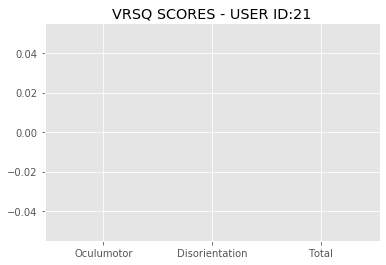

22
0.0 0.0 0.0


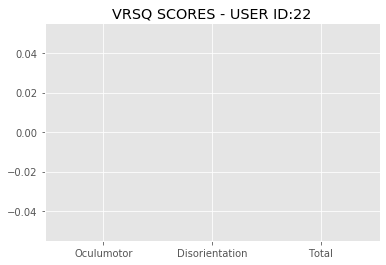

23
75.0 60.0 67.5


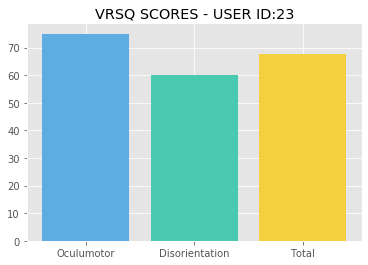

24
8.333333333333332 13.333333333333334 10.833333333333332


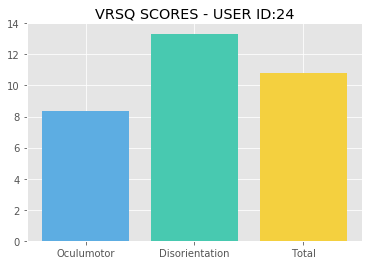

25
66.66666666666666 93.33333333333333 80.0


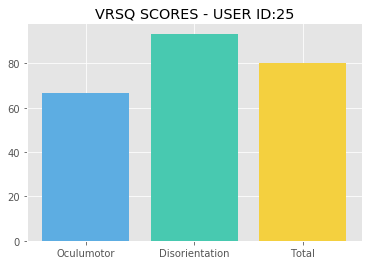

26
50.0 73.33333333333333 61.666666666666664


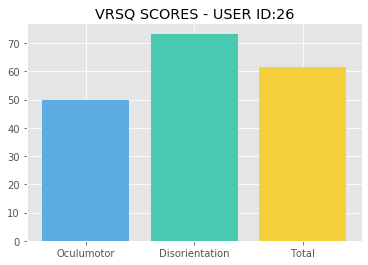

27
33.33333333333333 26.666666666666668 30.0


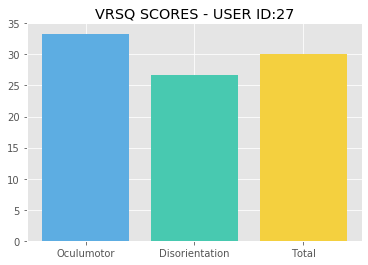

28
0.0 0.0 0.0


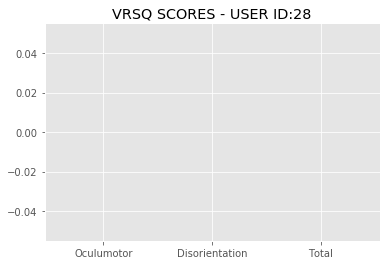

29
0.0 0.0 0.0


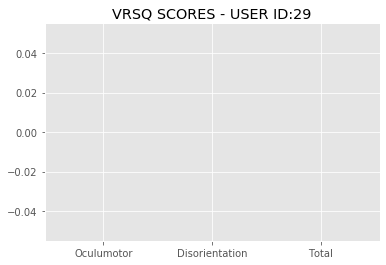

30
66.66666666666666 33.33333333333333 49.99999999999999


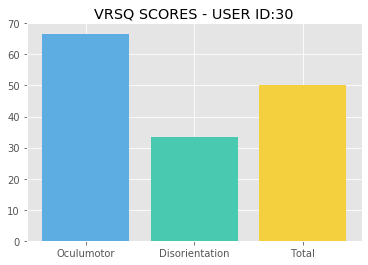

31
58.333333333333336 26.666666666666668 42.5


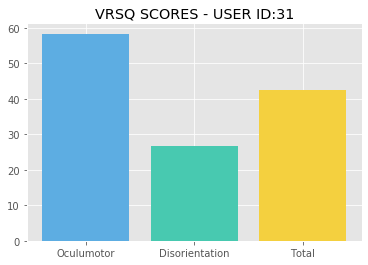

32
0.0 0.0 0.0


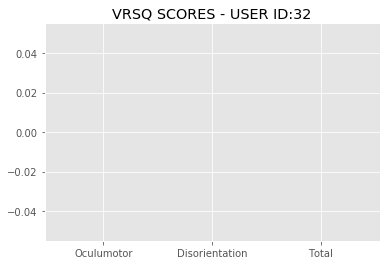

33
0.0 0.0 0.0


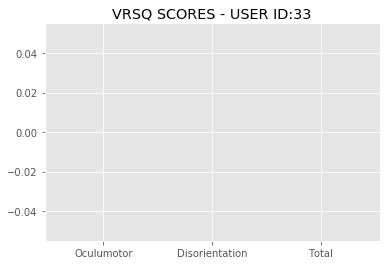

34
0.0 0.0 0.0


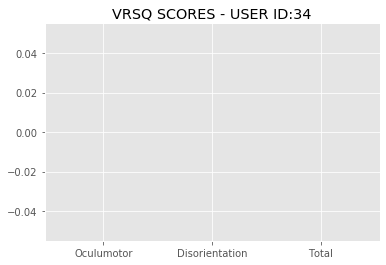

35
0.0 0.0 0.0


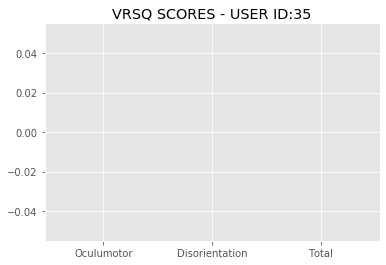

  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  1        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       2  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  1        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       2  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision D

1             0             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          0                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 1       0          0        

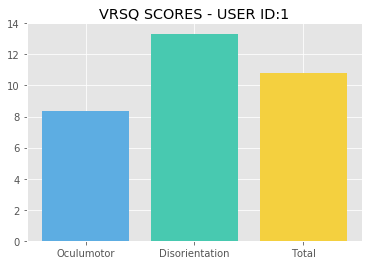

2
0.0 0.0 0.0


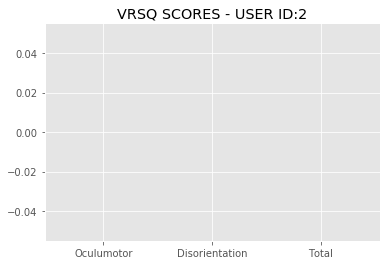

3
0.0 0.0 0.0


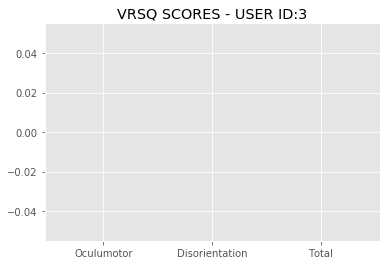

4
8.333333333333332 6.666666666666667 7.5


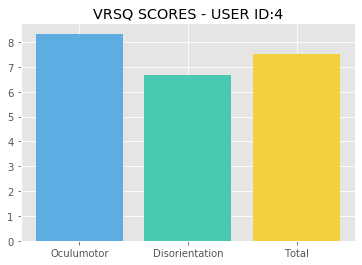

5
8.333333333333332 13.333333333333334 10.833333333333332


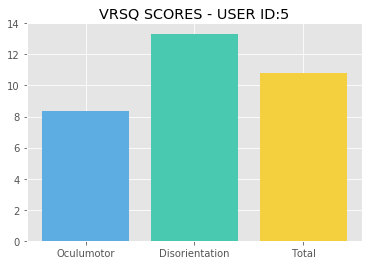

6
0.0 0.0 0.0


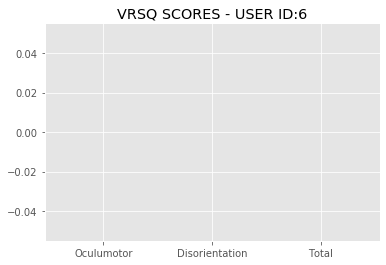

7
0.0 0.0 0.0


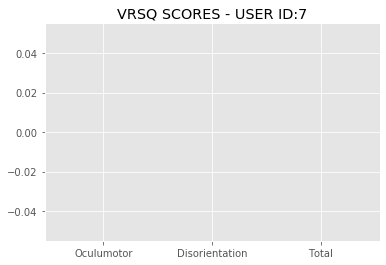

8
0.0 6.666666666666667 3.3333333333333335


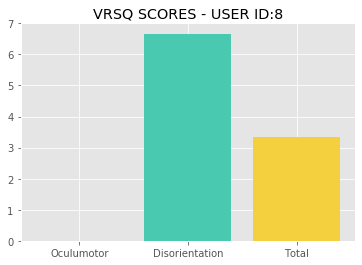

9
8.333333333333332 0.0 4.166666666666666


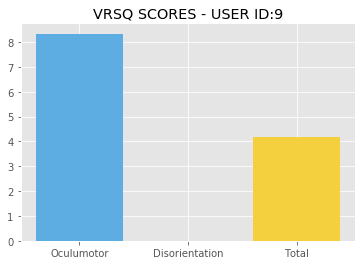

10
0.0 0.0 0.0


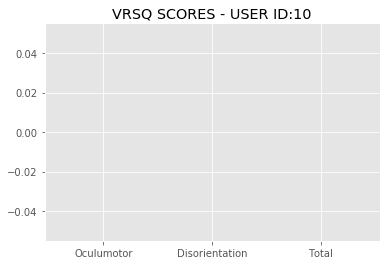

11
0.0 0.0 0.0


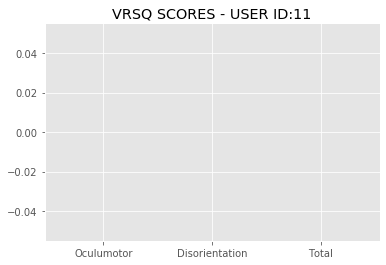

12
8.333333333333332 13.333333333333334 10.833333333333332


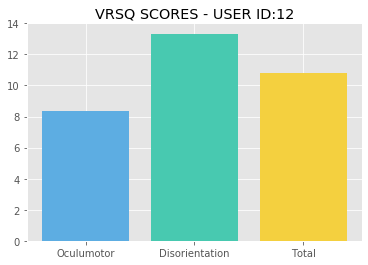

13
0.0 6.666666666666667 3.3333333333333335


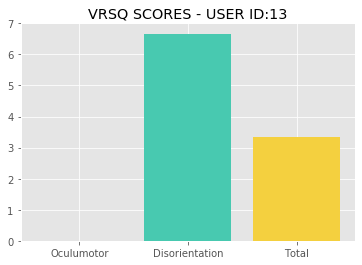

14
-25.0 -20.0 -22.5


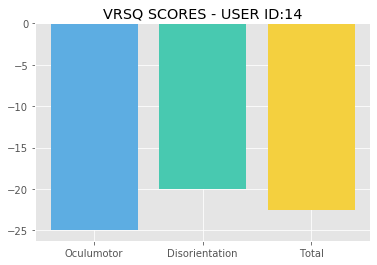

15
-8.333333333333332 0.0 -4.166666666666666


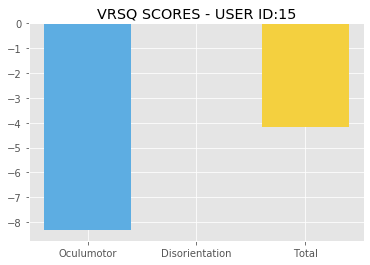

16
0.0 0.0 0.0


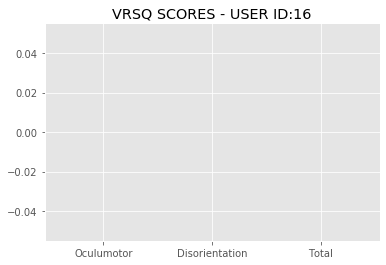

17
8.333333333333332 13.333333333333334 10.833333333333332


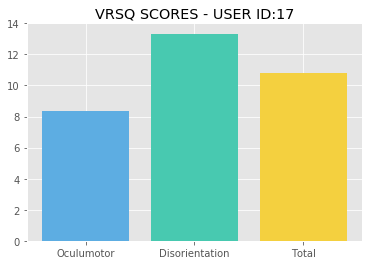

18
0.0 0.0 0.0


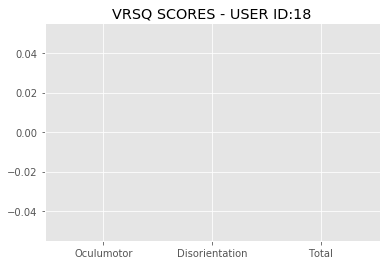

19
0.0 0.0 0.0


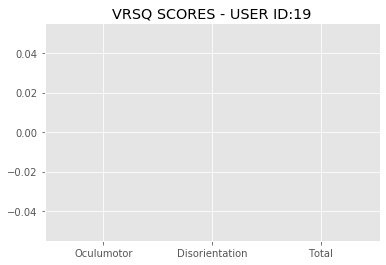

20
0.0 0.0 0.0


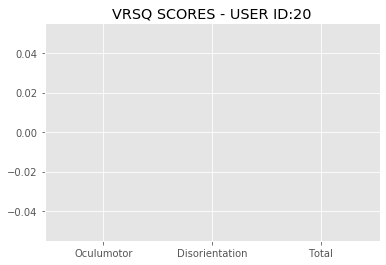

time: 16.3 s


In [15]:

database = 'DATABASE_VRSQ_CARRO/'
users = ['21','22','23','24','25','26','27','28', '29','30','31','32','33','34','35']
plotVRSQScores(database, users, 'A')
   
database = 'DATABASE_VRSQ_PASSARO/'
users = ['1','2','3','4','5','6','7','8', '9','10','11','12','13','14','15','16','17','18','19','20']
plotVRSQScores(database, users, 'B')

#plotVRSQScores(database, ['21'], 'B')


In [16]:
A[0]   #Scenario A
# A[1] #Scenario B

,oculumotor,disorientation,total
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,75.000000,60.000000,67.500000
3,8.333333,13.333333,10.833333
4,66.666667,93.333333,80.000000
5,50.000000,73.333333,61.666667
6,33.333333,26.666667,30.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,66.666667,33.333333,50.000000


time: 11 ms


## 2. Execucao de LeaveOneOut Adaptado - RandomForest

In [17]:
def show_AllRFResultsToDF(users,aucScores,d):
    depth_list = []
    auc_train =[]
    auc_test = []
    for auc in aucScores:
        auc_train.append(auc[0])
        auc_test.append(auc[1])
    for i in range(len(users)):
        depth_list.append(d)
        
    print(auc_train)
    
    df1 = pd.DataFrame(users, columns=['User ID'])
    df2 = pd.DataFrame(depth_list, columns=['Depth'])
    df3 = pd.DataFrame(auc_train, columns=['Auc Train'])
    df4 = pd.DataFrame(auc_test, columns=['Auc Test'])
    dfresult =  pd.concat([df1,df2,df3,df4], axis=1, join='inner')
    return dfresult

time: 998 µs


In [18]:
print("LeaveOneOut Flight")
database = 'DATABASE_PASSARO/'
users = ['1','2','3','4','5','6','7','8', '9','10','11','12','13','14','15','16','17','18','19','20']
features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
#models = RFLeaveOneOutUser(database,7, users, featureOut, True, True,True)
print("------------------")


df_col_rf_flight = []

#for d in range(7,22):
results = RFLeaveOneOutUser(database,7, users, featureOut, True, True,True)
rf_flight_model = results[0]
aucScores = results[1]
df_col_rf_flight.append(show_AllRFResultsToDF(users,aucScores,9))


LeaveOneOut Flight
------------------


0 - Without ['1']


KeyboardInterrupt: 

time: 1.33 s


In [ ]:
df_col_rf_flight[14].style.hide_index()

In [ ]:
#LeaveOneOut tests
print("LeaveOneOut Car")
database = 'DATABASE_CARRO/'
users = ['21','22','23','24','25','26','27','28', '29','30','31','32','33','34','35']
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
#models_car = RFLeaveOneOutUser(database, users, featureOut, True, True)
print("------------------")

df_col_rf_car = []

for d in range(7,22):
    results = RFLeaveOneOutUser(database,d, users, featureOut, True, True,True)
    aucScores = results[1]
    df_col_rf_car.append(show_AllRFResultsToDF(users,aucScores))

In [ ]:
df_col_rf_car[14].style.hide_index()

# 3. Execucao LeaveOneOut Adaptado - Decision Tree

In [ ]:
def show_MinLeafsAndAucScoreResults(users,minLeafsValues,aucScores):
    depth_list = []
    auc_train =[]
    auc_test = []
    minValues = []
    for auc in aucScores:
        auc_train.append(auc[0])
        auc_test.append(auc[1])
    for i in range(len(users)):
        depth_list.append(d)
    for m in minLeafsValues:
        minValues.append(m)
    df1 = pd.DataFrame(users, columns=['User ID'])
    df2 = pd.DataFrame(depth_list, columns=['Depth'])
    df3 = pd.DataFrame(minValues, columns=['MinLeavesValue'])
    df4 = pd.DataFrame(auc_train, columns=['Auc Train'])
    df5 = pd.DataFrame(auc_test, columns=['Auc Test'])
    dfresult =  pd.concat([df1,df2,df3,df4,df5], axis=1, join='inner')
    return dfresult

In [ ]:
#LeaveOneOut tests
print("LeaveOneOut Flight")
database = 'DATABASE_PASSARO/'
users = ['1','2','3','4','5','6','7','8', '9','10','11','12','13','14','15','16','17','18','19','20']
features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
#dt_models_flight = LeaveOneOutUser(database, users, featureOut,7, True, True,False)

dt_models_flight = []
df_col = []
#d = 10
for d in range(7,22):
    results = LeaveOneOutUser(database, users, featureOut,d, True, True,False,True)
    minLeafsValues = results[1]
    aucScores = results[2]
    dt_models_flight.append(results[0])
    df_col.append(show_MinLeafsAndAucScoreResults(users,minLeafsValues,aucScores))



In [ ]:
df_col[14].style.hide_index()

In [ ]:
print("LeaveOneOut CAR")
#LeaveOneOut tests
database = 'DATABASE_CARRO/'
users = ['21','22','23','24','25','26','27','28', '29','30','31','32','33','34','35']
features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
dt_models_car = []

df_col_car = []
for d in range(7,22):
    results = LeaveOneOutUser(database, users, featureOut,d, True, True,False,True)
    minLeafsValues = results[1]
    aucScores = results[2]
    dt_models_car.append(results[0])
    df_col_car.append(show_MinLeafsAndAucScoreResults(users,minLeafsValues,aucScores))
print("------------------")

In [ ]:
df_col_car[14].style.hide_index()

In [30]:
#Este teste, me mostra o desconforto predito em cada instancia e a lista de causas associadas naquela instancia
#Gero um dataframe final com a timeline da experiencia de jogo
#Retiro do conjunto de teste o usuario que ira fazer parte do Teste
#dtModel 
def PredictDiscomfortAndCausesFromUserOutTrainingRF(_database, user, _depth, featuresOut):
    # Default value of display.max_rows is 10 i.e. at max 10 rows will be printed.
    # Set it None to display all rows in the dataframe
    pd.set_option('display.max_rows', None)

    result = parseXmlDirToDataFrame(_database,[user])
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    raw_df_out = df_out
    depth = _depth
    #Pre process dataset
    df = PreProcessDataFrame(df,featuresOut) #['TimeStamp']
    df = oversampling(df)
    attributes = df.columns[:-1]
    df_out = PreProcessDataFrame(df_out,featuresOut)

    results = RFTrainingProcessWithReport(_database,featuresOut,[user],depth,True)
   # c_report = GetCustomReportAccF1Auc(results)

    dtModel = results[0]

    #prediction
    r = predict_discomfort_rf(df_out,results[0],attributes.values,False)
    #causes = r[0]
    raw_pred = r[2]
    raw_causes = r[3]
    causes_node_depth = r[1]
    dfpred = pd.DataFrame(raw_pred, columns=['prediction ' + user ])
    dfreal = pd.DataFrame(raw_df_out['DiscomfortLevel'].values.tolist(), columns=['real ' + user])
    dftime = pd.DataFrame(raw_df_out['TimeStamp'].values.tolist(), columns=['TimeStamp'])
   # dfcauses = pd.DataFrame(raw_causes,columns=['causes'])
    #dfNodeDepths = pd.DataFrame(raw_nodes_depth,columns=['Feature','NodeDepth'])
    
    causes_array = []
    node_depth_array = []
    for item in causes_node_depth:
        causes_array.append(item[0])
        node_depth_array.append(item[1])
        #print (str(item[0]) + ' ' + str(item[1]))
    
    #vou precisar agora calcular novamente a frequencia das causas com os pesos e  normalizar
    fn = []       
    #print(len(causes))
    #print(len(causes_array))
    
    if (len(causes_array) > 0):
        plot_causes_graph(calculate_causes_feqweighted(causes_array,node_depth_array),user, True)   
        #ranking = calculate_causes_feqweighted(causes_array,node_depth_array)
    dfresult =  pd.concat([dftime,dfpred, dfreal], axis=1, join='inner')
    return dfresult

time: 4.02 ms


# 3.1 Testes com o melhor modelo gerado pelo LOO por Decision Tree e plotagem das causas

Predicao de causas com plot jogo do passaro de todos os usuarios 

In [31]:
#Este teste, me mostra o desconforto predito em cada instancia e a lista de causas associadas naquela instancia
#Gero um dataframe final com a timeline da experiencia de jogo
#Retiro do conjunto de teste o usuario que ira fazer parte do Teste
#dtModel 
def PredictDiscomfortAndCausesFromUserOutTraining(_database, user, _depth, featuresOut):
    # Default value of display.max_rows is 10 i.e. at max 10 rows will be printed.
    # Set it None to display all rows in the dataframe
    pd.set_option('display.max_rows', None)

    result = parseXmlDirToDataFrame(_database,[user])
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    raw_df_out = df_out
    depth = _depth
    #Pre process dataset
    df = PreProcessDataFrame(df,featuresOut) #['TimeStamp']
    df = oversampling(df)
    attributes = df.columns[:-1]
    df_out = PreProcessDataFrame(df_out,featuresOut)

    results = TrainingProcessWithReport(_database,featuresOut,[user],depth,True,False)
    c_report = GetCustomReportAccF1Auc(results)

    dtModel = results[0]

    #prediction
    r = predict_discomfort(df_out,results[0],attributes.values,False)
    causes = r[0]
    raw_pred = r[4]
    raw_causes = r[5]
    causes_node_depth = r[6]
    dfpred = pd.DataFrame(raw_pred, columns=['prediction ' + user ])
    dfreal = pd.DataFrame(raw_df_out['DiscomfortLevel'].values.tolist(), columns=['real ' + user])
    dftime = pd.DataFrame(raw_df_out['TimeStamp'].values.tolist(), columns=['TimeStamp'])
    #dfcauses = pd.DataFrame(raw_causes,columns=['causes'])
    #dfNodeDepths = pd.DataFrame(raw_nodes_depth,columns=['Feature','NodeDepth'])
    
    causes_array = []
    node_depth_array = []
    for item in causes_node_depth:
        causes_array.append(item[0])
        node_depth_array.append(item[1])
        #print (str(item[0]) + ' ' + str(item[1]))
    
    #vou precisar agora calcular novamente a frequencia das causas com os pesos e  normalizar
    fn = []       
    #print(len(causes))
    #print(len(causes_array))
    
    if (len(causes_array) > 0):
        plot_causes_graph(calculate_causes_feqweighted(causes_array,node_depth_array),user, True)   
        #ranking = calculate_causes_feqweighted(causes_array,node_depth_array)
    dfresult =  pd.concat([dfpred, dfreal], axis=1, join='inner')
    return dfresult

time: 3.97 ms


In [ ]:
#Decision Teste sem usar LeaveOneOut
databaseA = 'DATABASE_CARRO/'


# PREDICAO JOGO DO CARRO - PREDICAO DE DESCONFORTO PARA USUARIOS
TestUsersA =  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
A = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []
for userA in TestUsersA:
    print(userA)
    r = PredictDiscomfortAndCausesFromUserOutTraining(databaseA, userA, 13, featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    A.append(r)



In [ ]:
databaseB = 'DATABASE_PASSARO/'
    
# PREDICAO JOGO DO PASSARO - PREDICAO DE DESCONFORTO PARA USUARIOS    
TestUsersB =  ['1','2','3','4','5','6','7','8', '9','10','11','12','13','14','15','16','17','18','19','20']
B = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []
for userB in TestUsersB:
    print(userB)
    PredictDiscomfortAndCausesFromUserOutTraining(databaseB, userB, 9,featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    B.append(r)

# RF PREEICTION

1
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  104
X_train = 6136 , X_test =  104 , y_train = 6136 , y_test = 104 , y_pred = 104
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.984384800667699
Testing AUC: 0.6538461538461539
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']
accuracy:  0.6538461538461539
Sample: 1 of 104
Sample:  [1 1 0 0.0111798 10 10 -0.01105297 90]
None Discomfort Predicted by RF
Sample: 2 of 104
Sample:  [1 1 0 1.010126 10 0 -0.01963342 90]
None Discomfort Predicted by RF
Sample: 3 of 104
Sample:  [1 1 0 2.019704 10 0 0.007609045 88]
None Discomfort Predicted by RF
Sample: 4 of 104
Sample:  [1 1 0 3.013207 10 0 -0.06166852 90]
None Discomfort Predicted by RF
Sample: 5 of 104
Sample:  [1 1 0 4.0165

    Estimator 3 of 3
Sample: 58 of 104
Sample:  [1 1 0 57.01999 15 0 -0.01668633 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 59 of 104
Sample:  [1 1 0 58.01328 15 0 -0.001090272 90]
None Discomfort Predicted by RF
Sample: 60 of 104
Sample:  [1 1 0 59.01987 15 0 0.00097859 90]
None Discomfort Predicted by RF
Sample: 61 of 104
Sample:  [1 1 0 60.01365 15 0 0.001525849 90]
None Discomfort Predicted by RF
Sample: 62 of 104
Sample:  [1 1 0 61.01932 15 0 0.001960399 90]
None Discomfort Predicted by RF
Sample: 63 of 104
Sample:  [1 1 0 62.01309 15 0 0.001568172 90]
None Discomfort Predicted by RF
Sample: 64 of 104
Sample:  [1 1 0 63.01809 15 0 0.0006543177 90]
None Discomfort Predicted by RF
Sample: 65 of 104
Sample:  [1 1 0 64.00931 15 0 0.001488679 90]
None Discomfort Predicted by RF
Sample: 66 of 104
Sample:  [1 1 0 65.01701 15 0 0.001519275 88]
None Discomfort Predicted by RF
Sample: 67 of 104
Sample:  [1 1 0 66.01165 15 0 0.0027

Sample: 63 of 302
Sample:  [1 1 0 62.00288 15 0 0.04780129 90]
None Discomfort Predicted by RF
Sample: 64 of 302
Sample:  [1 1 0 62.99806 15 0 0.05029098 88]
None Discomfort Predicted by RF
Sample: 65 of 302
Sample:  [1 1 0 64.00426 15 0 0.04802603 90]
None Discomfort Predicted by RF
Sample: 66 of 302
Sample:  [1 1 0 64.99812 10 -5 0.05163609 88]
None Discomfort Predicted by RF
Sample: 67 of 302
Sample:  [1 1 0 66.0021 10 0 0.04739989 90]
None Discomfort Predicted by RF
Sample: 68 of 302
Sample:  [1 1 0 67.00589 10 0 0.03944844 88]
None Discomfort Predicted by RF
Sample: 69 of 302
Sample:  [1 1 0 68.00378 10 0 0.03343784 90]
None Discomfort Predicted by RF
Sample: 70 of 302
Sample:  [1 1 0 69.00725 10 0 0.03527327 88]
None Discomfort Predicted by RF
Sample: 71 of 302
Sample:  [1 1 0 70.00055 10 0 0.03862826 90]
None Discomfort Predicted by RF
Sample: 72 of 302
Sample:  [1 1 0 70.99654 10 0 0.03640609 88]
None Discomfort Predicted by RF
Sample: 73 of 302
Sample:  [1 1 0 72.00171 10 0 0.

Sample: 178 of 302
Sample:  [1 1 0 177.0004 65 0 0.03051769 90]
None Discomfort Predicted by RF
Sample: 179 of 302
Sample:  [1 1 0 178.0047 15 -50 0.0345727 90]
None Discomfort Predicted by RF
Sample: 180 of 302
Sample:  [1 1 0 178.9979 15 0 0.03811337 88]
None Discomfort Predicted by RF
Sample: 181 of 302
Sample:  [1 1 0 180.0024 15 0 0.03660877 90]
None Discomfort Predicted by RF
Sample: 182 of 302
Sample:  [1 1 0 180.999 15 0 0.0297456 90]
None Discomfort Predicted by RF
Sample: 183 of 302
Sample:  [1 1 0 182.0048 15 0 0.03099114 90]
None Discomfort Predicted by RF
Sample: 184 of 302
Sample:  [1 1 0 182.9983 15 0 0.03331134 90]
None Discomfort Predicted by RF
Sample: 185 of 302
Sample:  [1 1 0 184.0057 10 -5 0.03689709 90]
None Discomfort Predicted by RF
Sample: 186 of 302
Sample:  [1 1 0 184.9969 10 0 0.03710129 90]
None Discomfort Predicted by RF
Sample: 187 of 302
Sample:  [1 1 0 186.0029 10 0 0.0386626 90]
None Discomfort Predicted by RF
Sample: 188 of 302
Sample:  [1 1 0 186.99

    Estimator 3 of 3
Sample: 278 of 302
Sample:  [1 1 0 277.0037 40 0 0.02541615 90]
None Discomfort Predicted by RF
Sample: 279 of 302
Sample:  [1 1 0 277.9997 40 0 0.0352622 88]
None Discomfort Predicted by RF
Sample: 280 of 302
Sample:  [1 1 0 279.0042 45 5 0.0354711 90]
None Discomfort Predicted by RF
Sample: 281 of 302
Sample:  [1 1 0 279.998 45 0 0.02945622 88]
None Discomfort Predicted by RF
Sample: 282 of 302
Sample:  [1 1 0 281.0041 15 -30 0.02445572 90]
None Discomfort Predicted by RF
Sample: 283 of 302
Sample:  [1 1 0 282.0066 15 0 0.02149907 88]
None Discomfort Predicted by RF
Sample: 284 of 302
Sample:  [1 1 0 283.0038 15 0 0.01548875 88]
None Discomfort Predicted by RF
Sample: 285 of 302
Sample:  [1 1 0 283.9988 15 0 0.01487996 88]
None Discomfort Predicted by RF
Sample: 286 of 302
Sample:  [1 1 0 285.0032 15 0 0.02577649 90]
None Discomfort Predicted by RF
Sample: 287 of 302
Sample:  [1 1 0 285.9972 15 0 0.02891687 88]
None Discomfort Predicted by RF
Sample: 288 of 302
S

Sample: 97 of 303
Sample:  [0 0 1 96.00266 30 0 0.005115364 90]
None Discomfort Predicted by RF
Sample: 98 of 303
Sample:  [0 0 1 97.00711 30 0 0.008725081 88]
None Discomfort Predicted by RF
Sample: 99 of 303
Sample:  [0 0 1 98.00116 35 5 0.006459425 90]
None Discomfort Predicted by RF
Sample: 100 of 303
Sample:  [0 0 1 99.00732 35 0 0.009592056 90]
None Discomfort Predicted by RF
Sample: 101 of 303
Sample:  [0 0 1 100.0006 35 0 0.009991541 90]
None Discomfort Predicted by RF
Sample: 102 of 303
Sample:  [0 0 1 101.0059 10 -25 0.01216128 88]
None Discomfort Predicted by RF
Sample: 103 of 303
Sample:  [0 0 1 101.9992 10 0 0.01298007 90]
None Discomfort Predicted by RF
Sample: 104 of 303
Sample:  [0 0 1 103.0059 10 0 0.01532723 88]
None Discomfort Predicted by RF
Sample: 105 of 303
Sample:  [0 0 1 103.9993 10 0 0.01127564 90]
None Discomfort Predicted by RF
Sample: 106 of 303
Sample:  [0 0 1 105.0047 10 0 0.008005145 88]
None Discomfort Predicted by RF
Sample: 107 of 303
Sample:  [0 0 1 

None Discomfort Predicted by RF
Sample: 237 of 303
Sample:  [0 0 1 236.0067 50 5 0.002037488 90]
None Discomfort Predicted by RF
Sample: 238 of 303
Sample:  [0 0 1 237.0007 50 0 0.001725634 90]
None Discomfort Predicted by RF
Sample: 239 of 303
Sample:  [0 0 1 238.0053 50 0 0.001083947 88]
None Discomfort Predicted by RF
Sample: 240 of 303
Sample:  [0 0 1 238.9998 55 5 -0.00119481 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 241 of 303
Sample:  [0 0 1 240.0057 55 0 0.001854986 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 242 of 303
Sample:  [0 0 1 240.9991 60 5 0.0007525618 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 243 of 303
Sample:  [0 0 1 242.0057 60 0 0.002574856 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 244 of 303
Sample:  [0 0 1 242.9979 65 5

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 35 of 302
Sample:  [1 1 0 34.01912 50 0 0.02841634 90]
None Discomfort Predicted by RF
Sample: 36 of 302
Sample:  [1 1 0 35.01377 50 0 0.002405646 88]
None Discomfort Predicted by RF
Sample: 37 of 302
Sample:  [1 1 0 36.01718 15 -35 0.01369242 90]
None Discomfort Predicted by RF
Sample: 38 of 302
Sample:  [1 1 0 37.01274 15 0 0.01908099 90]
None Discomfort Predicted by RF
Sample: 39 of 302
Sample:  [1 1 0 38.01831 15 0 0.003148745 90]
None Discomfort Predicted by RF
Sample: 40 of 302
Sample:  [1 1 0 39.01217 15 0 0.01036159 88]
None Discomfort Predicted by RF
Sample: 41 of 302
Sample:  [1 1 0 40.01754 15 0 0.03470103 90]
None Discomfort Predicted by RF
Sample: 42 of 302
Sample:  [1 1 0 41.01052 20 5 0.01119275 90]
None Discomfort Predicted by RF
Sample: 43 of 302
Sample:  [1 1 0 42.01724 20 0 0.01028494 90]
None Discomfort Predicted by RF
Sample: 44 of 302
Sample:  [1 1 0 43.02027 20 0 0.01354735 90]
None Discomfort Predicted by RF
Samp

    Estimator 3 of 3
Sample: 115 of 302
Sample:  [1 1 0 114.0195 55 0 0.01377036 90]
None Discomfort Predicted by RF
Sample: 116 of 302
Sample:  [1 1 0 115.0128 60 5 -0.005577819 88]
None Discomfort Predicted by RF
Sample: 117 of 302
Sample:  [1 1 0 116.0194 60 0 0.007994773 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 118 of 302
Sample:  [1 1 0 117.0126 60 0 -0.005642686 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 119 of 302
Sample:  [1 1 0 118.0177 65 5 0.007990981 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 120 of 302
Sample:  [1 1 0 119.0121 65 0 0.009635566 88]
None Discomfort Predicted by RF
Sample: 121 of 302
Sample:  [1 1 0 120.0173 70 5 -0.002429828 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 122 of 302
Sample:  [1 1 0 121.0209 75 5 0.0217700

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 195 of 302
Sample:  [1 1 0 194.0198 15 0 0.03275703 90]
None Discomfort Predicted by RF
Sample: 196 of 302
Sample:  [1 1 0 195.0145 15 0 -0.02051942 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 197 of 302
Sample:  [1 1 0 196.0186 15 0 0.008144584 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 198 of 302
Sample:  [1 1 0 197.0138 15 0 0.002314371 88]
None Discomfort Predicted by RF
Sample: 199 of 302
Sample:  [1 1 0 198.0177 15 0 0.02729528 90]
None Discomfort Predicted by RF
Sample: 200 of 302
Sample:  [1 1 0 199.0128 15 0 0.0132398 88]
None Discomfort Predicted by RF
Sample: 201 of 302
Sample:  [1 1 0 200.015 15 0 -0.01833721 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 202 of 302
Sample:  [1 1 0 201.0131 15 0 0.01831412 90]
None Discomfort Predicted by RF
Sample: 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 273 of 302
Sample:  [1 1 0 272.0176 100 5 0.001619143 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 274 of 302
Sample:  [1 1 0 273.0138 100 0 0.01747799 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 275 of 302
Sample:  [1 1 0 274.0176 105 5 0.01470054 90]
None Discomfort Predicted by RF
Sample: 276 of 302
Sample:  [1 1 0 275.0136 105 0 0.01802857 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 277 of 302
Sample:  [1 1 0 276.0194 110 5 0.04794689 90]
None Discomfort Predicted by RF
Sample: 278 of 302
Sample:  [1 1 0 277.011 115 5 -0.004122511 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 279 of 302
Sample:  [1 1 0 278.0184 115 0 0.01315276 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 

Sample:  [1 0 1 50.00111 15 0 0.06669036 90]
None Discomfort Predicted by RF
Sample: 52 of 103
Sample:  [1 0 1 50.99635 15 0 0.07331955 90]
None Discomfort Predicted by RF
Sample: 53 of 103
Sample:  [1 0 1 52.00238 20 5 0.0728957 90]
None Discomfort Predicted by RF
Sample: 54 of 103
Sample:  [1 0 1 52.99729 20 0 0.08947752 90]
None Discomfort Predicted by RF
Sample: 55 of 103
Sample:  [1 0 1 54.00202 20 0 0.08042829 90]
None Discomfort Predicted by RF
Sample: 56 of 103
Sample:  [1 0 1 54.99564 20 0 0.08084542 90]
None Discomfort Predicted by RF
Sample: 57 of 103
Sample:  [1 0 1 55.99984 25 5 0.07997397 90]
None Discomfort Predicted by RF
Sample: 58 of 103
Sample:  [1 0 1 57.00648 25 0 0.07906727 90]
None Discomfort Predicted by RF
Sample: 59 of 103
Sample:  [1 0 1 58.00112 25 0 0.07725743 90]
None Discomfort Predicted by RF
Sample: 60 of 103
Sample:  [1 0 1 59.00549 25 0 0.07583047 90]
None Discomfort Predicted by RF
Sample: 61 of 103
Sample:  [1 0 1 60.00083 30 5 0.06309126 90]
None D

Sample:  [1 0 1 86.00385 15 5 0.02770941 88]
None Discomfort Predicted by RF
Sample: 88 of 302
Sample:  [1 0 1 87.01024 15 0 0.05195165 90]
None Discomfort Predicted by RF
Sample: 89 of 302
Sample:  [1 0 1 88.00443 15 0 0.04967683 88]
None Discomfort Predicted by RF
Sample: 90 of 302
Sample:  [1 0 1 89.00955 15 0 0.04768459 90]
None Discomfort Predicted by RF
Sample: 91 of 302
Sample:  [1 0 1 90.00391 15 0 0.04246301 90]
None Discomfort Predicted by RF
Sample: 92 of 302
Sample:  [1 0 1 91.00847 20 5 0.03804085 90]
None Discomfort Predicted by RF
Sample: 93 of 302
Sample:  [1 0 1 92.0016 20 0 0.03454984 88]
None Discomfort Predicted by RF
Sample: 94 of 302
Sample:  [1 0 1 93.00795 20 0 0.04567644 90]
None Discomfort Predicted by RF
Sample: 95 of 302
Sample:  [1 0 1 94.00253 20 0 0.04149953 88]
None Discomfort Predicted by RF
Sample: 96 of 302
Sample:  [1 0 1 95.00549 15 -5 0.03763552 90]
None Discomfort Predicted by RF
Sample: 97 of 302
Sample:  [1 0 1 96.00258 15 0 0.03899849 88]
None 

    Estimator 3 of 3
Sample: 167 of 302
Sample:  [1 0 1 166.0037 15 0 0.03349057 88]
None Discomfort Predicted by RF
Sample: 168 of 302
Sample:  [1 0 1 167.0093 15 0 0.04226438 90]
None Discomfort Predicted by RF
Sample: 169 of 302
Sample:  [1 0 1 168.0029 15 0 0.04563621 88]
None Discomfort Predicted by RF
Sample: 170 of 302
Sample:  [1 0 1 169.0088 20 5 0.03764422 90]
None Discomfort Predicted by RF
Sample: 171 of 302
Sample:  [1 0 1 170.0034 20 0 0.03599835 88]
None Discomfort Predicted by RF
Sample: 172 of 302
Sample:  [1 0 1 171.0055 20 0 0.04754835 90]
None Discomfort Predicted by RF
Sample: 173 of 302
Sample:  [1 0 1 172.0014 20 0 0.04557585 88]
None Discomfort Predicted by RF
Sample: 174 of 302
Sample:  [1 0 1 173.0066 20 0 0.04475684 90]
None Discomfort Predicted by RF
Sample: 175 of 302
Sample:  [1 0 1 174.0016 25 5 0.05335625 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 176 of 302
Sample:  [1 0 1 175.0069 25 0 0.0459

    Estimator 3 of 3
Sample: 227 of 302
Sample:  [1 0 1 226.0092 35 0 0.02161068 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 228 of 302
Sample:  [1 0 1 227.003 40 5 0.0386947 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 229 of 302
Sample:  [1 0 1 228.0096 40 0 0.02767522 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 230 of 302
Sample:  [1 0 1 229.0022 45 5 0.02258192 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 231 of 302
Sample:  [1 0 1 230.0075 45 0 0.03029835 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 232 of 302
Sample:  [1 0 1 231.0025 45 0 0.02947187 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 233 of 302
Sample:  [1 0 1 232.0071 5

    Estimator 3 of 3
Sample: 280 of 302
Sample:  [1 0 1 279.0105 35 0 0.03979137 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 281 of 302
Sample:  [1 0 1 280.0047 40 5 0.03857468 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 282 of 302
Sample:  [1 0 1 281.0099 40 0 0.0443174 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 283 of 302
Sample:  [1 0 1 282.0057 40 0 0.04094132 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 284 of 302
Sample:  [1 0 1 283.0083 45 5 0.02620904 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 285 of 302
Sample:  [1 0 1 284.0044 45 0 0.02995185 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 286 of 302
Sample:  [1 0 1 285.009 5

Sample: 86 of 302
Sample:  [1 0 0 85.01046 30 0 0.04440174 88]
None Discomfort Predicted by RF
Sample: 87 of 302
Sample:  [1 0 0 86.01457 35 5 0.04783454 90]
None Discomfort Predicted by RF
Sample: 88 of 302
Sample:  [1 0 0 87.00938 35 0 0.0549149 90]
None Discomfort Predicted by RF
Sample: 89 of 302
Sample:  [1 0 0 88.01499 40 5 0.05586312 90]
None Discomfort Predicted by RF
Sample: 90 of 302
Sample:  [1 0 0 89.00937 40 0 0.03544373 88]
None Discomfort Predicted by RF
Sample: 91 of 302
Sample:  [1 0 0 90.01464 40 0 0.04576737 90]
None Discomfort Predicted by RF
Sample: 92 of 302
Sample:  [1 0 0 91.01879 45 5 0.04526519 88]
None Discomfort Predicted by RF
Sample: 93 of 302
Sample:  [1 0 0 92.01122 45 0 0.03265364 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 94 of 302
Sample:  [1 0 0 93.01852 45 0 0.03445444 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 95 of 302
Sample: 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 154 of 302
Sample:  [1 0 0 153.0127 15 0 0.0492497 90]
None Discomfort Predicted by RF
Sample: 155 of 302
Sample:  [1 0 0 154.0087 15 0 0.1443661 88]
None Discomfort Predicted by RF
Sample: 156 of 302
Sample:  [1 0 0 155.0125 15 0 -0.03889814 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 157 of 302
Sample:  [1 0 0 156.0175 15 0 0.07636873 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 158 of 302
Sample:  [1 0 0 157.0109 15 0 0.08005209 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 159 of 302
Sample:  [1 0 0 158.0174 15 0 0.07559281 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 160 of 302
Sample:  [1 0 0 159.012 15 0 0.1316807 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estima

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 218 of 302
Sample:  [1 0 0 217.0188 25 0 0.06693527 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 219 of 302
Sample:  [1 0 0 218.0127 25 0 0.06666959 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 220 of 302
Sample:  [1 0 0 219.0183 25 0 0.0714479 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 221 of 302
Sample:  [1 0 0 220.0118 30 5 0.06938686 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 222 of 302
Sample:  [1 0 0 221.0171 30 0 0.06733724 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 223 of 302
Sample:  [1 0 0 222.0114 30 0 0.03939094 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 224 of 302
Samp

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 271 of 302
Sample:  [1 0 0 270.0187 55 5 0.05276478 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 272 of 302
Sample:  [1 0 0 271.0134 55 0 0.05308773 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 273 of 302
Sample:  [1 0 0 272.0087 60 5 0.04933079 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 274 of 302
Sample:  [1 0 0 273.0116 60 0 0.05286366 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 275 of 302
Sample:  [1 0 0 274.0177 65 5 0.05586771 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 276 of 302
Sample:  [1 0 0 275.0121 65 0 0.05318568 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 277 of 302
Sam

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 85 of 302
Sample:  [1 0 0 84.01353 25 0 0.04277476 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 86 of 302
Sample:  [1 0 0 85.0094 30 5 0.03952304 88]
None Discomfort Predicted by RF
Sample: 87 of 302
Sample:  [1 0 0 86.01452 30 0 0.03952082 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 88 of 302
Sample:  [1 0 0 87.00967 30 0 0.04055725 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 89 of 302
Sample:  [1 0 0 88.01543 35 5 0.03203226 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 90 of 302
Sample:  [1 0 0 89.00916 35 0 0.02663208 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 91 of 302
Sample:  [1 0 0 90.01366 15 -20 0.03065958 90]
None Discomfort Predicte

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 147 of 302
Sample:  [1 0 0 146.0091 35 0 0.01721617 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 148 of 302
Sample:  [1 0 0 147.015 40 5 0.01175557 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 149 of 302
Sample:  [1 0 0 148.0085 40 0 0.01316743 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 150 of 302
Sample:  [1 0 0 149.0145 40 0 0.01891342 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 151 of 302
Sample:  [1 0 0 150.0182 45 5 0.03095276 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 152 of 302
Sample:  [1 0 0 151.0129 45 0 0.08457488 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 153 of 302
Samp

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 202 of 302
Sample:  [1 0 0 201.0111 30 0 0.1364972 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 203 of 302
Sample:  [1 0 0 202.017 35 5 0.1316094 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 204 of 302
Sample:  [1 0 0 203.0101 35 0 0.1299316 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 205 of 302
Sample:  [1 0 0 204.0153 35 0 0.1212656 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 206 of 302
Sample:  [1 0 0 205.009 40 5 0.05962148 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 207 of 302
Sample:  [1 0 0 206.0139 40 0 0.02963336 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 208 of 302
Sample:  

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 255 of 302
Sample:  [1 0 0 254.0126 10 0 0.1312307 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 256 of 302
Sample:  [1 0 0 255.0178 15 5 0.1316846 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 257 of 302
Sample:  [1 0 0 256.0127 15 0 0.1301675 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 258 of 302
Sample:  [1 0 0 257.0155 15 0 0.1355657 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 259 of 302
Sample:  [1 0 0 258.0105 15 0 0.135193 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 260 of 302
Sample:  [1 0 0 259.0159 15 0 0.1357993 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 261 of 302
Sample:  [

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 29 of 303
Sample:  [0 0 0 27.99656 25 5 0.004572025 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 30 of 303
Sample:  [0 0 0 29.00081 15 -10 0.0295894 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 31 of 303
Sample:  [0 0 0 29.9968 15 0 0.01673913 88]
None Discomfort Predicted by RF
Sample: 32 of 303
Sample:  [0 0 0 31.00224 15 0 0.00923796 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 33 of 303
Sample:  [0 0 0 31.99723 15 0 0.009689933 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 34 of 303
Sample:  [0 0 0 33.00143 15 0 0.01292146 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 35 of 303
Sample:  [0 0 0 33.99636 15 0 0.009933538 90]
  Discomfort Predicted

    Estimator 3 of 3
Sample: 85 of 303
Sample:  [0 0 0 84.00308 15 0 0.008708236 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 86 of 303
Sample:  [0 0 0 84.99735 15 0 0.007800378 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 87 of 303
Sample:  [0 0 0 86.00452 15 0 0.008631166 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 88 of 303
Sample:  [0 0 0 86.99879 15 0 0.00756414 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 89 of 303
Sample:  [0 0 0 88.0018 20 5 0.007244228 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 90 of 303
Sample:  [0 0 0 88.99684 20 0 0.009767356 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 91 of 303
Sample:  [0 0 0 90.00277 20

    Estimator 3 of 3
Sample: 138 of 303
Sample:  [0 0 0 136.9946 20 5 0.02312546 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 139 of 303
Sample:  [0 0 0 137.9994 20 0 0.01250656 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 140 of 303
Sample:  [0 0 0 138.9942 20 0 -0.0004330791 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 141 of 303
Sample:  [0 0 0 139.9981 20 0 0.003607631 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 142 of 303
Sample:  [0 0 0 140.9945 15 -5 0.003299967 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 143 of 303
Sample:  [0 0 0 141.9991 10 -5 0.004068253 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 144 of 303
Sample:  [0 0 0 

    Estimator 3 of 3
Sample: 191 of 303
Sample:  [0 0 0 189.9981 25 5 0.019756 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 192 of 303
Sample:  [0 0 0 191.0018 25 0 0.01518197 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 193 of 303
Sample:  [0 0 0 191.9958 25 0 0.01424275 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 194 of 303
Sample:  [0 0 0 193.0028 25 0 0.01659183 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 195 of 303
Sample:  [0 0 0 193.9958 30 5 0.02124698 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 196 of 303
Sample:  [0 0 0 195.0008 30 0 0.01827531 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 197 of 303
Sample:  [0 0 0 195.9953 3

    Estimator 3 of 3
Sample: 244 of 303
Sample:  [0 0 0 242.9972 40 5 0.01499273 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 245 of 303
Sample:  [0 0 0 244.0031 40 0 0.01355264 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 246 of 303
Sample:  [0 0 0 244.9968 40 0 0.01264379 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 247 of 303
Sample:  [0 0 0 246.0017 45 5 0.01165491 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 248 of 303
Sample:  [0 0 0 246.9965 15 -30 0.01617574 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 249 of 303
Sample:  [0 0 0 248.0024 15 0 0.009387881 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 250 of 303
Sample:  [0 0 0 248.9

    Estimator 3 of 3
Sample: 297 of 303
Sample:  [0 0 0 295.9992 15 0 0.005042021 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 298 of 303
Sample:  [0 0 0 297.0035 15 0 0.00773925 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 299 of 303
Sample:  [0 0 0 297.9991 15 0 0.008369293 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 300 of 303
Sample:  [0 0 0 299.0047 15 0 0.008821643 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 301 of 303
Sample:  [0 0 0 299.9994 15 0 0.01029045 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 302 of 303
Sample:  [0 0 0 301.0025 15 0 0.0130367 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 303 of 303
Sample:  [0 0 0 301.99

Sample: 63 of 302
Sample:  [1 0 1 62.01035 60 0 0.0002473075 90]
None Discomfort Predicted by RF
Sample: 64 of 302
Sample:  [1 0 1 63.01582 65 5 0.007217398 90]
None Discomfort Predicted by RF
Sample: 65 of 302
Sample:  [1 0 1 64.00895 65 0 0.008904127 88]
None Discomfort Predicted by RF
Sample: 66 of 302
Sample:  [1 0 1 65.01629 70 5 0.01728755 90]
None Discomfort Predicted by RF
Sample: 67 of 302
Sample:  [1 0 1 66.00889 70 0 0.03142392 88]
None Discomfort Predicted by RF
Sample: 68 of 302
Sample:  [1 0 1 67.01521 75 5 0.003415315 90]
None Discomfort Predicted by RF
Sample: 69 of 302
Sample:  [1 0 1 68.00865 75 0 -0.001276463 88]
None Discomfort Predicted by RF
Sample: 70 of 302
Sample:  [1 0 1 69.01254 15 -60 0.008070654 90]
None Discomfort Predicted by RF
Sample: 71 of 302
Sample:  [1 0 1 70.00777 15 0 0.006771255 88]
None Discomfort Predicted by RF
Sample: 72 of 302
Sample:  [1 0 1 71.01376 15 0 0.004696246 90]
None Discomfort Predicted by RF
Sample: 73 of 302
Sample:  [1 0 1 72.0

    Estimator 3 of 3
Sample: 135 of 302
Sample:  [1 0 1 134.0133 15 0 -0.006266756 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 136 of 302
Sample:  [1 0 1 135.0176 15 0 0.01899597 88]
None Discomfort Predicted by RF
Sample: 137 of 302
Sample:  [1 0 1 136.0133 20 5 0.009547926 90]
None Discomfort Predicted by RF
Sample: 138 of 302
Sample:  [1 0 1 137.0177 20 0 0.002782136 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 139 of 302
Sample:  [1 0 1 138.0114 20 0 -0.06853882 90]
None Discomfort Predicted by RF
Sample: 140 of 302
Sample:  [1 0 1 139.0168 20 0 -0.042743 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 141 of 302
Sample:  [1 0 1 140.0116 15 -5 -0.03313774 90]
None Discomfort Predicted by RF
Sample: 142 of 302
Sample:  [1 0 1 141.0165 15 0 -0.01486508 90]
None Discomfort Predicted by RF
Sample: 143 of 302
Sampl

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 200 of 302
Sample:  [1 0 1 199.0128 15 0 -0.01775816 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 201 of 302
Sample:  [1 0 1 200.0179 15 0 -0.0765701 88]
None Discomfort Predicted by RF
Sample: 202 of 302
Sample:  [1 0 1 201.0128 15 0 -0.09094765 90]
None Discomfort Predicted by RF
Sample: 203 of 302
Sample:  [1 0 1 202.017 15 0 -0.01187334 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 204 of 302
Sample:  [1 0 1 203.011 15 0 -0.01586596 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 205 of 302
Sample:  [1 0 1 204.0154 20 5 0.003852005 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 206 of 302
Sample:  [1 0 1 205.0106 20 0 -0.007140436 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
  

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 254 of 302
Sample:  [1 0 1 253.0079 15 0 -0.01718493 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 255 of 302
Sample:  [1 0 1 254.0143 20 5 -0.02892258 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 256 of 302
Sample:  [1 0 1 255.0172 20 0 -0.008191593 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 257 of 302
Sample:  [1 0 1 256.0126 20 0 -0.001882987 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 258 of 302
Sample:  [1 0 1 257.0185 20 0 -0.005102367 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 259 of 302
Sample:  [1 0 1 258.0135 20 0 -0.005678162 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 260 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 40 of 302
Sample:  [1 0 0 38.99988 25 0 -0.01652192 90]
None Discomfort Predicted by RF
Sample: 41 of 302
Sample:  [1 0 0 39.99434 30 5 0.002405221 90]
None Discomfort Predicted by RF
Sample: 42 of 302
Sample:  [1 0 0 40.99866 30 0 0.004384086 90]
None Discomfort Predicted by RF
Sample: 43 of 302
Sample:  [1 0 0 41.99391 30 0 0.01083537 90]
None Discomfort Predicted by RF
Sample: 44 of 302
Sample:  [1 0 0 42.99882 15 -15 0.01106374 90]
None Discomfort Predicted by RF
Sample: 45 of 302
Sample:  [1 0 0 44.00379 15 0 0.006439236 90]
None Discomfort Predicted by RF
Sample: 46 of 302
Sample:  [1 0 0 44.99791 15 0 -0.001552284 88]
None Discomfort Predicted by RF
Sample: 47 of 302
Sample:  [1 0 0 46.00389 15 0 0.008224145 90]
None Discomfort Predicted by RF
Sample: 48 of 302
Sample:  [1 0 0 46.99784 15 0 -0.003123661 88]
None Discomfort Predicted by RF
Sample: 49 of 302
Sample:  [1 0 0 48.00324 20 5 3.7112e-05 90]
None Discomfort Predicted by 

    Estimator 3 of 3
Sample: 113 of 302
Sample:  [1 0 0 111.9943 20 0 0.03018767 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 114 of 302
Sample:  [1 0 0 113.0022 25 5 0.02245371 90]
None Discomfort Predicted by RF
Sample: 115 of 302
Sample:  [1 0 0 113.9966 25 0 0.01956982 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 116 of 302
Sample:  [1 0 0 115.0023 25 0 0.01624642 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 117 of 302
Sample:  [1 0 0 115.9952 25 0 0.008970172 90]
None Discomfort Predicted by RF
Sample: 118 of 302
Sample:  [1 0 0 117.0004 15 -10 0.02279258 90]
None Discomfort Predicted by RF
Sample: 119 of 302
Sample:  [1 0 0 117.9948 15 0 0.01359246 90]
None Discomfort Predicted by RF
Sample: 120 of 302
Sample:  [1 0 0 118.9998 15 0 -0.00818113 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estim

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 176 of 302
Sample:  [1 0 0 174.9954 20 0 -0.009147593 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 177 of 302
Sample:  [1 0 0 176.0 25 5 -0.004971491 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 178 of 302
Sample:  [1 0 0 176.9954 25 0 0.004701499 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 179 of 302
Sample:  [1 0 0 178.0005 25 0 0.01452266 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 180 of 302
Sample:  [1 0 0 179.0044 25 0 0.004144205 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 181 of 302
Sample:  [1 0 0 179.9999 30 5 -0.008101792 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 182 of 30

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 231 of 302
Sample:  [1 0 0 229.9966 20 5 0.002635229 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 232 of 302
Sample:  [1 0 0 231.002 20 0 0.006283118 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 233 of 302
Sample:  [1 0 0 231.9962 20 0 0.008070512 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 234 of 302
Sample:  [1 0 0 233.0006 20 0 0.001018402 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 235 of 302
Sample:  [1 0 0 233.9961 25 5 -0.004566669 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 236 of 302
Sample:  [1 0 0 235.0027 25 0 -0.004950761 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 237 of 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 285 of 302
Sample:  [1 0 0 284.0045 45 5 -0.005599152 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 286 of 302
Sample:  [1 0 0 284.9988 45 0 0.01916148 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 287 of 302
Sample:  [1 0 0 286.0036 45 0 0.02798309 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 288 of 302
Sample:  [1 0 0 286.9983 50 5 0.02902533 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 289 of 302
Sample:  [1 0 0 288.0022 50 0 0.04980769 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 290 of 302
Sample:  [1 0 0 288.9989 55 5 0.02306591 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 291 of 302
S

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 70 of 302
Sample:  [1 0 0 69.01296 40 0 -0.02012018 90]
None Discomfort Predicted by RF
Sample: 71 of 302
Sample:  [1 0 0 70.00988 40 0 -0.02673441 90]
None Discomfort Predicted by RF
Sample: 72 of 302
Sample:  [1 0 0 71.0142 45 5 -0.02268505 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 73 of 302
Sample:  [1 0 0 72.00565 45 0 -0.01975864 90]
None Discomfort Predicted by RF
Sample: 74 of 302
Sample:  [1 0 0 73.01225 50 5 -0.01464881 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 75 of 302
Sample:  [1 0 0 74.0084 50 0 -0.01621415 88]
None Discomfort Predicted by RF
Sample: 76 of 302
Sample:  [1 0 0 75.01354 50 0 -0.02124097 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 77 of 302
Sample:  [1 0 0 76.00615 55 5 -0.0220592 90]
  Discomfort Predicted by RF
    Estimator 1 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 126 of 302
Sample:  [1 0 0 125.0098 70 5 0.003918646 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 127 of 302
Sample:  [1 0 0 126.0131 70 0 0.01214285 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 128 of 302
Sample:  [1 0 0 127.0085 75 5 -0.0056222 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 129 of 302
Sample:  [1 0 0 128.0035 75 0 -0.003374384 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 130 of 302
Sample:  [1 0 0 129.0072 80 5 -0.004590689 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 131 of 302
Sample:  [1 0 0 130.014 80 0 0.001308809 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 132 of 30

    Estimator 3 of 3
Sample: 183 of 302
Sample:  [1 0 0 182.0105 15 0 -0.007214586 88]
None Discomfort Predicted by RF
Sample: 184 of 302
Sample:  [1 0 0 183.0044 20 5 -0.01517974 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 185 of 302
Sample:  [1 0 0 184.0103 20 0 -0.03208074 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 186 of 302
Sample:  [1 0 0 185.0039 20 0 -0.03321927 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 187 of 302
Sample:  [1 0 0 186.0109 20 0 -0.03279933 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 188 of 302
Sample:  [1 0 0 187.0144 25 5 -0.02048155 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 189 of 302
Sample:  [1 0 0 188.0096 25 0 -0.00642947 88]
  Discomfort Predicted by RF
  

    Estimator 3 of 3
Sample: 236 of 302
Sample:  [1 0 0 235.0119 25 0 -0.02355174 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 237 of 302
Sample:  [1 0 0 236.0068 30 5 -0.020512 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 238 of 302
Sample:  [1 0 0 237.0114 30 0 -0.01504766 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 239 of 302
Sample:  [1 0 0 238.0062 30 0 -0.01096885 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 240 of 302
Sample:  [1 0 0 239.0112 35 5 -0.01597631 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 241 of 302
Sample:  [1 0 0 240.0064 35 0 -0.02101303 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 242 of 302
Sample:  [1 0 0 241.

Sample: 288 of 302
Sample:  [1 0 0 287.0089 15 0 -0.007750257 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 289 of 302
Sample:  [1 0 0 288.0141 15 0 -0.002520484 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 290 of 302
Sample:  [1 0 0 289.0098 15 0 -0.002084634 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 291 of 302
Sample:  [1 0 0 290.0146 15 0 -0.003670556 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 292 of 302
Sample:  [1 0 0 291.0092 15 0 -0.01008229 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 293 of 302
Sample:  [1 0 0 292.0125 15 0 -0.0247674 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 294 of 302
Sample:  [1 0 0 293.0078 15 0 -0.014

Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9877918268198274
Testing AUC: 0.9032665857605178
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['1', '10', '11', '12', '13', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']
accuracy:  0.7317880794701986
Sample: 1 of 302
Sample:  [1 0 0 0.0112268 10 10 -0.01672062 0]
None Discomfort Predicted by RF
Sample: 2 of 302
Sample:  [1 0 0 1.010952 10 0 -0.005415613 90]
None Discomfort Predicted by RF
Sample: 3 of 302
Sample:  [1 0 0 2.01688 10 0 -0.002962693 88]
None Discomfort Predicted by RF
Sample: 4 of 302
Sample:  [1 0 0 3.010709 10 0 -0.002852194 90]
None Discomfort Predicted by RF
Sample: 5 of 302
Sample:  [1 0 0 4.015441 15 5 0.0006350209 90]
None Discomfort Predicted by RF
Sample: 6 of 302
Sample:  [1 0 0 5.010154 15 0 -0.001647235 88]
None Discomfort Predicted by RF
Sampl

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 82 of 302
Sample:  [1 0 0 81.01 90 5 0.009284516 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 83 of 302
Sample:  [1 0 0 82.01595 90 0 0.01959218 88]
None Discomfort Predicted by RF
Sample: 84 of 302
Sample:  [1 0 0 83.00983 95 5 0.02178717 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 85 of 302
Sample:  [1 0 0 84.01365 95 0 0.02407745 90]
None Discomfort Predicted by RF
Sample: 86 of 302
Sample:  [1 0 0 85.00916 100 5 0.01753515 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 87 of 302
Sample:  [1 0 0 86.01279 105 5 0.01524827 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 88 of 302
Sample:  [1 0 0 87.00995 105 0 0.02889696 90]
None Discomfort Predicted by RF
Sample: 89 of 302
Sample:  [1 0 0 88.01443 110 5 0.0

    Estimator 3 of 3
Sample: 158 of 302
Sample:  [1 0 0 157.0102 40 0 0.01071255 90]
None Discomfort Predicted by RF
Sample: 159 of 302
Sample:  [1 0 0 158.0163 45 5 0.03884721 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 160 of 302
Sample:  [1 0 0 159.0115 45 0 0.01519773 90]
None Discomfort Predicted by RF
Sample: 161 of 302
Sample:  [1 0 0 160.0177 45 0 0.03921017 88]
None Discomfort Predicted by RF
Sample: 162 of 302
Sample:  [1 0 0 161.0104 50 5 -0.03307386 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 163 of 302
Sample:  [1 0 0 162.0165 50 0 0.01242455 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 164 of 302
Sample:  [1 0 0 163.0099 55 5 0.02802107 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 165 of 302
Sample:  [1 0 0 164.0155 55 0 0.03548707 90]
No

    Estimator 3 of 3
Sample: 221 of 302
Sample:  [1 0 0 220.0108 55 5 0.0296252 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 222 of 302
Sample:  [1 0 0 221.0161 55 0 0.02524354 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 223 of 302
Sample:  [1 0 0 222.0095 60 5 0.02191563 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 224 of 302
Sample:  [1 0 0 223.0147 60 0 -0.0119504 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 225 of 302
Sample:  [1 0 0 224.0093 65 5 0.006144262 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 226 of 302
Sample:  [1 0 0 225.0162 65 0 0.03796962 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 227 of 302
Sample:  [1 0 0 226.0088

    Estimator 3 of 3
Sample: 275 of 302
Sample:  [1 0 0 274.0166 45 0 -0.003445985 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 276 of 302
Sample:  [1 0 0 275.0122 50 5 -6.403084e-05 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 277 of 302
Sample:  [1 0 0 276.0172 50 0 0.003264867 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 278 of 302
Sample:  [1 0 0 277.0125 55 5 0.005773997 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 279 of 302
Sample:  [1 0 0 278.0169 55 0 0.003268519 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 280 of 302
Sample:  [1 0 0 279.0107 60 5 0.01957853 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 281 of 302
Sample:  [1 0 0 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 71 of 302
Sample:  [1 0 0 70.00152 20 0 -0.01989672 90]
None Discomfort Predicted by RF
Sample: 72 of 302
Sample:  [1 0 0 70.99718 20 0 0.003432337 88]
None Discomfort Predicted by RF
Sample: 73 of 302
Sample:  [1 0 0 72.00053 20 0 -0.01067736 90]
None Discomfort Predicted by RF
Sample: 74 of 302
Sample:  [1 0 0 72.99554 25 5 0.001205961 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 75 of 302
Sample:  [1 0 0 74.00175 25 0 -0.02781719 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 76 of 302
Sample:  [1 0 0 74.99531 25 0 -0.0007261111 90]
None Discomfort Predicted by RF
Sample: 77 of 302
Sample:  [1 0 0 76.00156 25 0 -5.017407e-05 90]
None Discomfort Predicted by RF
Sample: 78 of 302
Sample:  [1 0 0 76.9957 30 5 -0.0128934 90]
None Discomfort Predicted by RF
Sample: 79 of 302
Sample:  [1 0 0 77.99854 30 0 -0.02251508 90]
None

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 145 of 302
Sample:  [1 0 0 144.0034 70 0 0.005712443 90]
None Discomfort Predicted by RF
Sample: 146 of 302
Sample:  [1 0 0 144.9979 75 5 -0.03345618 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 147 of 302
Sample:  [1 0 0 146.0038 75 0 -0.04005736 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 148 of 302
Sample:  [1 0 0 146.9981 80 5 -0.02170691 88]
None Discomfort Predicted by RF
Sample: 149 of 302
Sample:  [1 0 0 148.0031 80 0 -0.01147757 90]
None Discomfort Predicted by RF
Sample: 150 of 302
Sample:  [1 0 0 148.9964 85 5 -0.008361747 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 151 of 302
Sample:  [1 0 0 150.0031 85 0 -0.00872699 90]
None Discomfort Predicted by RF
Sample: 152 of 302
Sample:  [1 0 0 150.998 90 5 -0.01910343 88]
None Discomfort Predicted by RF
Sa

    Estimator 3 of 3
Sample: 210 of 302
Sample:  [1 0 0 209.0018 130 5 0.002556679 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 211 of 302
Sample:  [1 0 0 209.9971 15 -115 0.005474467 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 212 of 302
Sample:  [1 0 0 211.0018 15 0 0.01667412 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 213 of 302
Sample:  [1 0 0 211.9965 15 0 0.01402375 90]
None Discomfort Predicted by RF
Sample: 214 of 302
Sample:  [1 0 0 213.0005 15 0 0.02525734 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 215 of 302
Sample:  [1 0 0 213.9955 15 0 0.03348076 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 216 of 302
Sample:  [1 0 0 215.0018 15 0 -0.0535247 90]
None Discomfort Predicted by RF
S

Sample: 276 of 302
Sample:  [1 0 0 275.0058 40 0 -0.0345255 90]
None Discomfort Predicted by RF
Sample: 277 of 302
Sample:  [1 0 0 276.0016 45 5 -0.03681837 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 278 of 302
Sample:  [1 0 0 276.9961 45 0 -0.04072665 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 279 of 302
Sample:  [1 0 0 278.0005 45 0 -0.02350473 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 280 of 302
Sample:  [1 0 0 279.0054 50 5 -0.01747158 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 281 of 302
Sample:  [1 0 0 280.0003 50 0 -0.02787185 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 282 of 302
Sample:  [1 0 0 281.0043 55 5 -0.01787556 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 70 of 303
Sample:  [1 0 0 69.00393 35 0 0.0458625 90]
None Discomfort Predicted by RF
Sample: 71 of 303
Sample:  [1 0 0 69.99723 35 0 0.04561961 90]
None Discomfort Predicted by RF
Sample: 72 of 303
Sample:  [1 0 0 71.00259 40 5 0.04725705 88]
None Discomfort Predicted by RF
Sample: 73 of 303
Sample:  [1 0 0 71.99445 40 0 0.04630549 90]
None Discomfort Predicted by RF
Sample: 74 of 303
Sample:  [1 0 0 73.00022 40 0 0.04735288 90]
None Discomfort Predicted by RF
Sample: 75 of 303
Sample:  [1 0 0 73.99709 10 -30 0.04744092 88]
None Discomfort Predicted by RF
Sample: 76 of 303
Sample:  [1 0 0 75.00314 10 0 0.04705659 90]
None Discomfort Predicted by RF
Sample: 77 of 303
Sample:  [1 0 0 75.99519 10 0 0.04624163 90]
None Discomfort Predicted by RF
Sample: 78 of 303
Sample:  [1 0 0 76.99998 10 0 0.04580411 90]
None Discomfort Predicted by RF
Sample: 79 of 303
Sample:  [1 0 0 77.99554 10 0 0.04663109 88]
None Discomfort Predicted by RF
Sample:

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 148 of 303
Sample:  [1 0 0 146.9928 35 0 0.0424994 88]
None Discomfort Predicted by RF
Sample: 149 of 303
Sample:  [1 0 0 147.9981 35 0 0.04283829 90]
None Discomfort Predicted by RF
Sample: 150 of 303
Sample:  [1 0 0 149.0022 40 5 0.04722544 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 151 of 303
Sample:  [1 0 0 149.9987 40 0 0.0460992 90]
None Discomfort Predicted by RF
Sample: 152 of 303
Sample:  [1 0 0 151.0019 45 5 0.04687508 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 153 of 303
Sample:  [1 0 0 151.9956 45 0 0.042473 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 154 of 303
Sample:  [1 0 0 153.0024 45 0 0.04360298 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 155 of 303
Sample:  [1 0 0 153.9956 50 5 0

    Estimator 3 of 3
Sample: 205 of 303
Sample:  [1 0 0 203.994 40 0 0.04644061 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 206 of 303
Sample:  [1 0 0 204.9967 40 0 0.04695319 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 207 of 303
Sample:  [1 0 0 205.9934 45 5 0.0417391 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 208 of 303
Sample:  [1 0 0 207.0 45 0 0.03807327 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 209 of 303
Sample:  [1 0 0 208.0029 50 5 0.04462995 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 210 of 303
Sample:  [1 0 0 208.9988 50 0 0.04036478 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 211 of 303
Sample:  [1 0 0 210.0011 50 0

Sample: 258 of 303
Sample:  [1 0 0 256.994 90 5 0.04123405 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 259 of 303
Sample:  [1 0 0 258.0011 90 0 0.04123072 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 260 of 303
Sample:  [1 0 0 258.9933 95 5 0.03391655 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 261 of 303
Sample:  [1 0 0 259.9996 95 0 0.03942752 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 262 of 303
Sample:  [1 0 0 260.9945 100 5 0.04898592 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 263 of 303
Sample:  [1 0 0 262.0007 105 5 0.043353 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 264 of 303
Sample:  [1 0 0 262.9942 105 0 0.04163246 88]


    Estimator 2 of 3
    Estimator 3 of 3
Sample: 79 of 302
Sample:  [1 1 0 78.00659 25 0 -0.04157741 90]
None Discomfort Predicted by RF
Sample: 80 of 302
Sample:  [1 1 0 79.01199 25 0 -0.04040618 88]
None Discomfort Predicted by RF
Sample: 81 of 302
Sample:  [1 1 0 80.0071 25 0 -0.04051672 90]
None Discomfort Predicted by RF
Sample: 82 of 302
Sample:  [1 1 0 81.01176 30 5 -0.03974791 88]
None Discomfort Predicted by RF
Sample: 83 of 302
Sample:  [1 1 0 82.00599 30 0 -0.03924211 90]
None Discomfort Predicted by RF
Sample: 84 of 302
Sample:  [1 1 0 83.01203 30 0 -0.04008219 90]
None Discomfort Predicted by RF
Sample: 85 of 302
Sample:  [1 1 0 84.00549 35 5 -0.04024793 90]
None Discomfort Predicted by RF
Sample: 86 of 302
Sample:  [1 1 0 85.01128 35 0 -0.04069642 90]
None Discomfort Predicted by RF
Sample: 87 of 302
Sample:  [1 1 0 86.00328 35 0 -0.03994262 90]
None Discomfort Predicted by RF
Sample: 88 of 302
Sample:  [1 1 0 87.01077 40 5 -0.04092868 90]
None Discomfort Predicted by RF

    Estimator 3 of 3
Sample: 153 of 302
Sample:  [1 1 0 152.0095 60 0 -0.04247682 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 154 of 302
Sample:  [1 1 0 153.0142 65 5 -0.043068 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 155 of 302
Sample:  [1 1 0 154.0081 65 0 -0.04290941 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 156 of 302
Sample:  [1 1 0 155.0137 70 5 -0.04293454 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 157 of 302
Sample:  [1 1 0 156.0075 70 0 -0.044245 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 158 of 302
Sample:  [1 1 0 157.0126 75 5 -0.04232144 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 159 of 302
Sample:  [1 1 0 158.00

    Estimator 3 of 3
Sample: 222 of 302
Sample:  [1 1 0 221.0034 25 0 -0.02187295 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 223 of 302
Sample:  [1 1 0 222.0124 25 0 -0.02000419 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 224 of 302
Sample:  [1 1 0 223.0052 30 5 -0.01974153 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 225 of 302
Sample:  [1 1 0 224.0106 30 0 -0.01899793 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 226 of 302
Sample:  [1 1 0 225.0051 30 0 -0.01967736 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 227 of 302
Sample:  [1 1 0 226.011 35 5 -0.01907668 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 228 of 302
Sample:  [1 1 0 227

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 297 of 302
Sample:  [1 1 0 296.0129 50 5 -0.01971561 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 298 of 302
Sample:  [1 1 0 297.0052 50 0 -0.01293769 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 299 of 302
Sample:  [1 1 0 298.0126 50 0 -0.006750307 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 300 of 302
Sample:  [1 1 0 299.0057 55 5 -0.0209678 90]
None Discomfort Predicted by RF
Sample: 301 of 302
Sample:  [1 1 0 300.0108 55 0 -0.02701216 90]
None Discomfort Predicted by RF
Sample: 302 of 302
Sample:  [1 1 0 301.005 60 5 -0.01896081 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[19.26, 2.81,

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 69 of 302
Sample:  [1 1 1 68.00716 55 0 0.03129351 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 70 of 302
Sample:  [1 1 1 69.00375 60 5 0.01943924 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 71 of 302
Sample:  [1 1 1 70.0084 60 0 0.02277207 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 72 of 302
Sample:  [1 1 1 71.01236 65 5 0.0381391 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 73 of 302
Sample:  [1 1 1 72.00837 65 0 0.0321464 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 74 of 302
Sample:  [1 1 1 73.01229 70 5 0.01763088 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 75 of 302
Sample:  [1 1

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 130 of 302
Sample:  [1 1 1 129.0071 15 0 0.02542503 90]
None Discomfort Predicted by RF
Sample: 131 of 302
Sample:  [1 1 1 130.0107 20 5 0.02622196 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 132 of 302
Sample:  [1 1 1 131.0053 20 0 0.04368162 90]
None Discomfort Predicted by RF
Sample: 133 of 302
Sample:  [1 1 1 132.0118 20 0 0.02626886 88]
None Discomfort Predicted by RF
Sample: 134 of 302
Sample:  [1 1 1 133.0079 20 0 0.01666533 90]
None Discomfort Predicted by RF
Sample: 135 of 302
Sample:  [1 1 1 134.0121 25 5 0.003497336 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 136 of 302
Sample:  [1 1 1 135.0053 25 0 -0.008786537 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 137 of 302
Sample:  [1 1 1 136.0091 25 0 0.001560767 90]
None Discomfort Predicted by RF
Sample

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 188 of 302
Sample:  [1 1 1 187.0022 35 0 0.04002229 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 189 of 302
Sample:  [1 1 1 188.0093 35 0 0.03956319 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 190 of 302
Sample:  [1 1 1 189.0019 40 5 0.01984803 88]
None Discomfort Predicted by RF
Sample: 191 of 302
Sample:  [1 1 1 190.0066 40 0 0.02205658 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 192 of 302
Sample:  [1 1 1 191.0022 40 0 0.0192738 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 193 of 302
Sample:  [1 1 1 192.0062 45 5 0.002208288 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 194 of 302
Sample:  [1 1 1 193.0127 45 0 0.04008557 88]
  Discomfort Predi

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 241 of 302
Sample:  [1 1 1 240.0055 15 0 0.02865261 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 242 of 302
Sample:  [1 1 1 241.0118 15 0 0.01250286 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 243 of 302
Sample:  [1 1 1 242.0053 20 5 -0.0563418 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 244 of 302
Sample:  [1 1 1 243.0082 20 0 0.03930316 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 245 of 302
Sample:  [1 1 1 244.0037 20 0 0.03597458 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 246 of 302
Sample:  [1 1 1 245.0088 20 0 0.01549157 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 247 of 302
Sam

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 294 of 302
Sample:  [1 1 1 293.0062 50 0 0.03687745 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 295 of 302
Sample:  [1 1 1 294.0128 55 5 0.04559659 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 296 of 302
Sample:  [1 1 1 295.0057 55 0 0.04070931 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 297 of 302
Sample:  [1 1 1 296.0127 60 5 0.005900694 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 298 of 302
Sample:  [1 1 1 297.0052 60 0 0.008399739 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 299 of 302
Sample:  [1 1 1 298.0118 15 -45 0.03009482 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 300 of 302

Sample:  [1 0 0 75.01249 35 5 0.02016402 88]
None Discomfort Predicted by RF
Sample: 77 of 302
Sample:  [1 0 0 76.01789 35 0 0.02441482 90]
None Discomfort Predicted by RF
Sample: 78 of 302
Sample:  [1 0 0 77.01308 40 5 0.02147956 88]
None Discomfort Predicted by RF
Sample: 79 of 302
Sample:  [1 0 0 78.01806 40 0 0.01650502 90]
None Discomfort Predicted by RF
Sample: 80 of 302
Sample:  [1 0 0 79.01257 40 0 0.08535765 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 81 of 302
Sample:  [1 0 0 80.01762 45 5 0.03227638 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 82 of 302
Sample:  [1 0 0 81.01065 45 0 0.01962659 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 83 of 302
Sample:  [1 0 0 82.01672 45 0 0.0241705 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 84 of 302
S

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 144 of 302
Sample:  [1 0 0 143.0153 70 5 0.0005756248 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 145 of 302
Sample:  [1 0 0 144.0207 70 0 0.01718207 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 146 of 302
Sample:  [1 0 0 145.0155 75 5 0.01026045 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 147 of 302
Sample:  [1 0 0 146.0199 75 0 0.01412597 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 148 of 302
Sample:  [1 0 0 147.0127 80 5 0.008654173 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 149 of 302
Sample:  [1 0 0 148.02 85 5 0.01141865 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 150 of 302
Sa

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 203 of 302
Sample:  [1 0 0 202.0163 75 5 0.01826327 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 204 of 302
Sample:  [1 0 0 203.021 75 0 0.02093061 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 205 of 302
Sample:  [1 0 0 204.0153 80 5 0.01967984 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 206 of 302
Sample:  [1 0 0 205.0196 80 0 0.02613934 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 207 of 302
Sample:  [1 0 0 206.0148 85 5 0.0002834668 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 208 of 302
Sample:  [1 0 0 207.0199 85 0 0.007791473 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 209 of 302
S

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 264 of 302
Sample:  [1 0 0 263.0148 50 5 0.00736786 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 265 of 302
Sample:  [1 0 0 264.0195 50 0 0.002693536 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 266 of 302
Sample:  [1 0 0 265.0154 55 5 0.002531525 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 267 of 302
Sample:  [1 0 0 266.0211 55 0 0.01010124 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 268 of 302
Sample:  [1 0 0 267.0141 55 0 0.00935216 90]
None Discomfort Predicted by RF
Sample: 269 of 302
Sample:  [1 0 0 268.0197 60 5 -0.005987864 88]
None Discomfort Predicted by RF
Sample: 270 of 302
Sample:  [1 0 0 269.0141 60 0 -0.002658356 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
 

    Estimator 3 of 3
Sample: 19 of 302
Sample:  [1 1 1 18.01066 30 0 -0.01991261 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 20 of 302
Sample:  [1 1 1 19.01831 30 0 -0.02263966 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 21 of 302
Sample:  [1 1 1 20.01064 35 5 -0.01727341 90]
None Discomfort Predicted by RF
Sample: 22 of 302
Sample:  [1 1 1 21.0165 35 0 -0.01896206 90]
None Discomfort Predicted by RF
Sample: 23 of 302
Sample:  [1 1 1 22.01155 35 0 -0.02727289 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 24 of 302
Sample:  [1 1 1 23.01568 40 5 -0.02151057 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 25 of 302
Sample:  [1 1 1 24.0096 40 0 -0.01878155 90]
None Discomfort Predicted by RF
Sample: 26 of 302
Sample:  [1 1 1 25.01568 40 0 -0.01947038 90]
None 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 103 of 302
Sample:  [1 1 1 102.0096 30 0 -0.0154813 88]
None Discomfort Predicted by RF
Sample: 104 of 302
Sample:  [1 1 1 103.0159 30 0 -0.0119224 90]
None Discomfort Predicted by RF
Sample: 105 of 302
Sample:  [1 1 1 104.0102 35 5 -0.01125303 90]
None Discomfort Predicted by RF
Sample: 106 of 302
Sample:  [1 1 1 105.0157 35 0 -0.01513891 90]
None Discomfort Predicted by RF
Sample: 107 of 302
Sample:  [1 1 1 106.0086 35 0 -0.01660611 90]
None Discomfort Predicted by RF
Sample: 108 of 302
Sample:  [1 1 1 107.0142 40 5 -0.01608498 90]
None Discomfort Predicted by RF
Sample: 109 of 302
Sample:  [1 1 1 108.009 40 0 -0.01612493 90]
None Discomfort Predicted by RF
Sample: 110 of 302
Sample:  [1 1 1 109.0137 40 0 -0.01579551 90]
None Discomfort Predicted by RF
Sample: 111 of 302
Sample:  [1 1 1 110.0089 45 5 -0.01551258 90]
None Discomfort Predicted by RF
Sample: 112 of 302
Sample:  [1 1 1 111.0139 45 0 -0.01544078 90]
None Discomfort Predict

    Estimator 3 of 3
Sample: 178 of 302
Sample:  [1 1 1 177.017 120 5 -0.0008835132 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 179 of 302
Sample:  [1 1 1 178.011 125 5 0.004690688 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 180 of 302
Sample:  [1 1 1 179.0166 125 0 -0.002093266 90]
None Discomfort Predicted by RF
Sample: 181 of 302
Sample:  [1 1 1 180.0093 130 5 0.003404165 90]
None Discomfort Predicted by RF
Sample: 182 of 302
Sample:  [1 1 1 181.0153 130 0 0.007298041 90]
None Discomfort Predicted by RF
Sample: 183 of 302
Sample:  [1 1 1 182.0092 130 0 0.005669257 90]
None Discomfort Predicted by RF
Sample: 184 of 302
Sample:  [1 1 1 183.0143 130 0 0.008357831 90]
None Discomfort Predicted by RF
Sample: 185 of 302
Sample:  [1 1 1 184.0083 130 0 0.002379817 90]
None Discomfort Predicted by RF
Sample: 186 of 302
Sample:  [1 1 1 185.0125 130 0 0.00127448 90]
None Disc

    Estimator 3 of 3
Sample: 245 of 302
Sample:  [1 1 1 244.014 115 0 0.001611196 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 246 of 302
Sample:  [1 1 1 245.0085 15 -100 0.05308855 90]
None Discomfort Predicted by RF
Sample: 247 of 302
Sample:  [1 1 1 246.0148 15 0 -0.006517851 90]
None Discomfort Predicted by RF
Sample: 248 of 302
Sample:  [1 1 1 247.009 15 0 0.0009702104 90]
None Discomfort Predicted by RF
Sample: 249 of 302
Sample:  [1 1 1 248.0144 15 0 0.04074284 90]
None Discomfort Predicted by RF
Sample: 250 of 302
Sample:  [1 1 1 249.0175 15 0 -0.01953223 90]
None Discomfort Predicted by RF
Sample: 251 of 302
Sample:  [1 1 1 250.0134 15 0 -0.006355405 88]
None Discomfort Predicted by RF
Sample: 252 of 302
Sample:  [1 1 1 251.0181 15 0 -8.548207e-05 90]
None Discomfort Predicted by RF
Sample: 253 of 302
Sample:  [1 1 1 252.0121 20 5 0.002673698 88]
None Discomfort Predicted by RF
Sample: 254 of 302
Sample:  [1 1 1 253.01

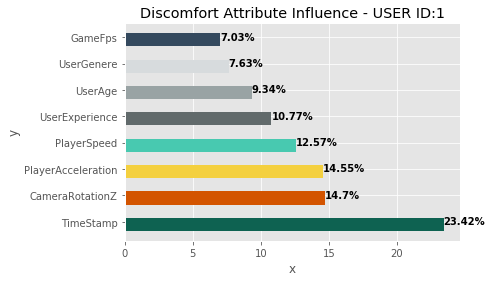

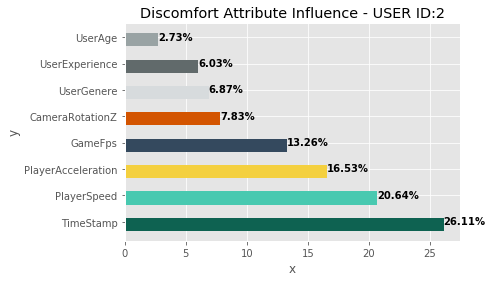

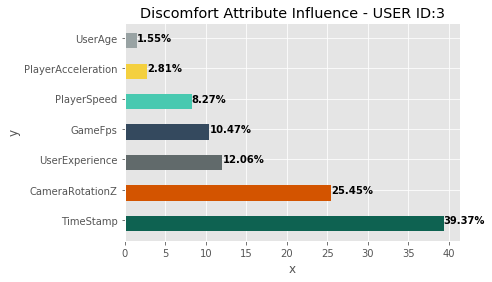

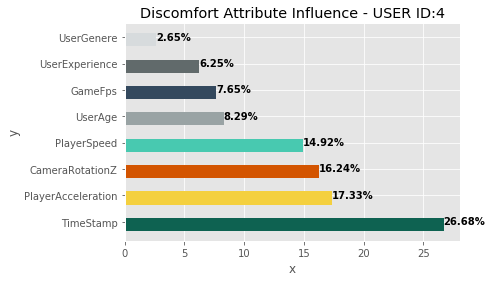

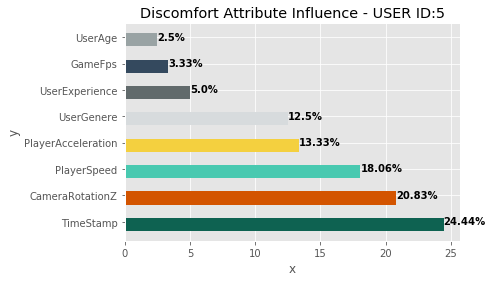

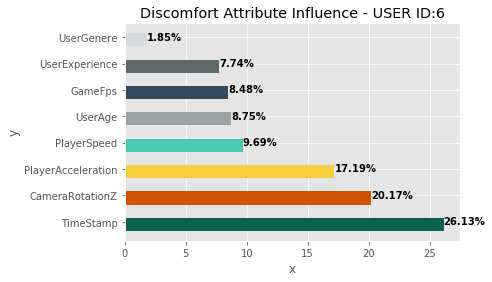

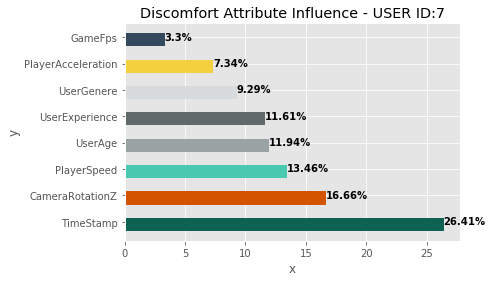

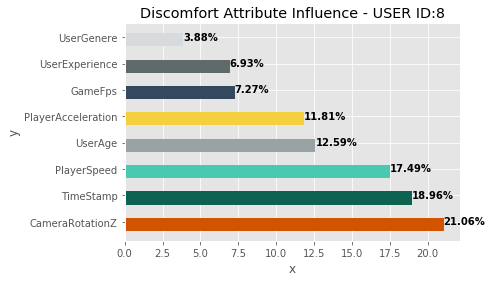

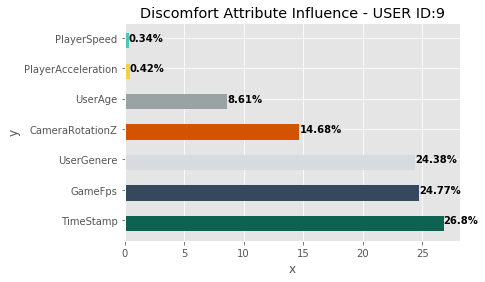

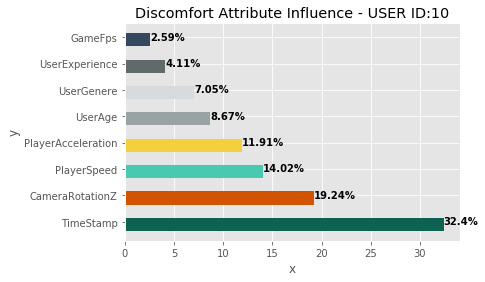

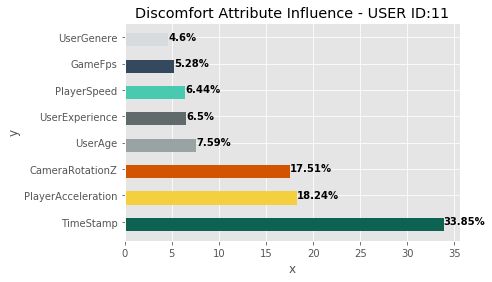

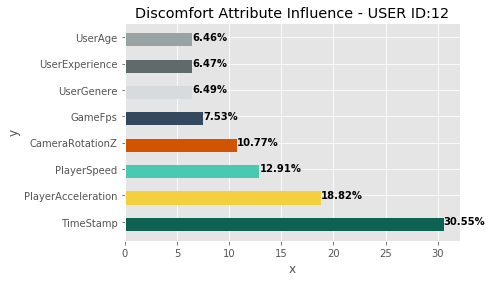

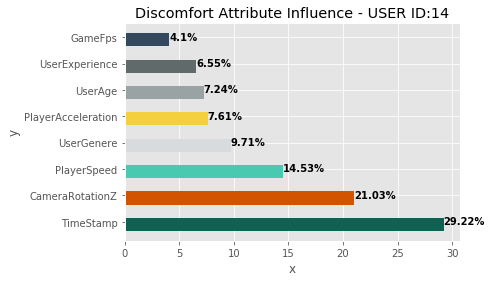

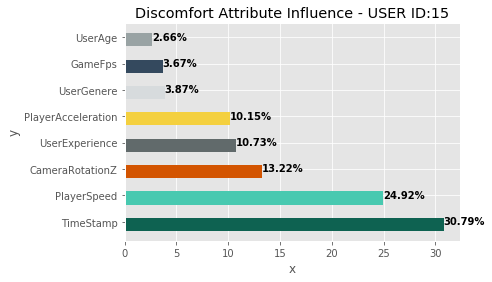

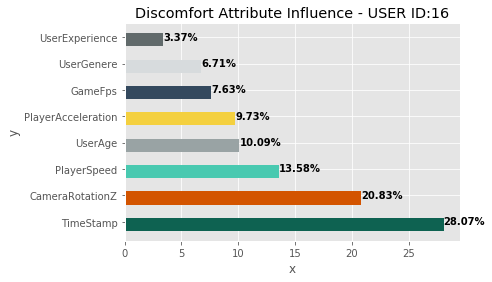

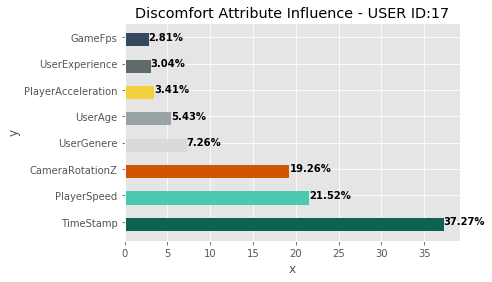

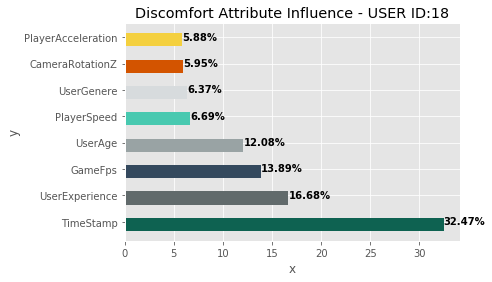

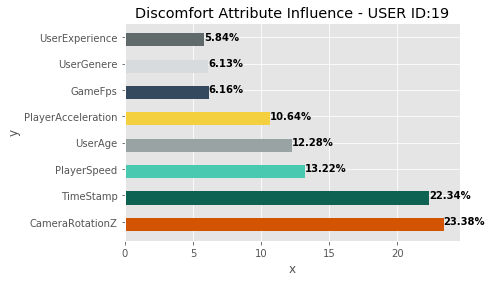

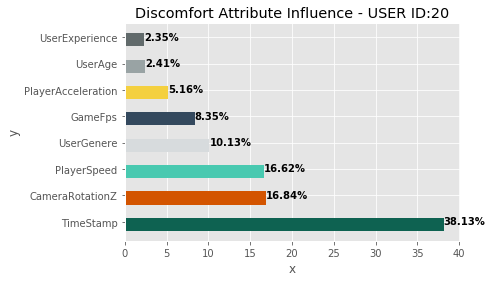

time: 24min 53s


In [32]:
databaseB = 'DATABASE_PASSARO/'
    
# PREDICAO JOGO DO PASSARO - PREDICAO DE DESCONFORTO PARA USUARIOS    
TestUsersB =  ['1','2','3','4','5','6','7','8', '9','10','11','12','13','14','15','16','17','18','19','20']
BRF = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []
for userB in TestUsersB:
    print(userB)
    r = PredictDiscomfortAndCausesFromUserOutTrainingRF(databaseB, userB, 9,featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    BRF.append(r)

In [42]:
from pandas import DataFrame

BRF[5].style.hide_index()

TimeStamp,prediction 6,real 6
0,0,0
1.000985,0,0
2.005424,0,0
3.009673,0,0
4.004768,0,0
5.009557,0,0
6.003664,0,0
7.010209,0,0
8.003902,0,0
9.006798,0,0


time: 47.9 ms


21
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  302
X_train = 3691 , X_test =  302 , y_train = 3691 , y_test = 302 , y_pred = 302
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9976210024113209
Testing AUC: 0.7248201438848921
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
accuracy:  0.28807947019867547
Sample: 1 of 302
Sample:  [1 0 1 0.0110195 0 0 -0.04634059 0]
None Discomfort Predicted by RF
Sample: 2 of 302
Sample:  [1 0 1 1.005759 0 0 -0.04323979 90]
None Discomfort Predicted by RF
Sample: 3 of 302
Sample:  [1 0 1 2.00784 0 0 -0.04994086 90]
None Discomfort Predicted by RF
Sample: 4 of 302
Sample:  [1 0 1 3.007802 0 0 -0.03738239 90]
None Discomfort Predicted by RF
Sample: 5 of 302
Sample:  [1 0 1 4.007293 0 0 -0.03240728 90]
Non

Sample: 71 of 302
Sample:  [1 0 1 70.00444 62 16 -0.006669275 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 72 of 302
Sample:  [1 0 1 71.01484 76 14 -0.004763022 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 73 of 302
Sample:  [1 0 1 72.01485 65 -11 -0.004303239 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 74 of 302
Sample:  [1 0 1 73.01538 78 13 0.08462769 90]
None Discomfort Predicted by RF
Sample: 75 of 302
Sample:  [1 0 1 74.01483 87 9 0.07887336 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 76 of 302
Sample:  [1 0 1 75.01283 98 11 0.08200727 90]
None Discomfort Predicted by RF
Sample: 77 of 302
Sample:  [1 0 1 76.01294 112 14 0.06613337 90]
None Discomfort Predicted by RF
Sample: 78 of 302
Sample:  [1 0 1 77.0144 87 -25 0.05468474 90]
  Discomfort Pred

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 128 of 302
Sample:  [1 0 1 127.0068 12 2 0.1034689 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 129 of 302
Sample:  [1 0 1 128.0076 4 -8 0.1107897 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 130 of 302
Sample:  [1 0 1 129.0074 0 -4 0.1208523 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 131 of 302
Sample:  [1 0 1 130.0071 1 1 0.1225858 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 132 of 302
Sample:  [1 0 1 131.0081 11 10 0.1029975 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 133 of 302
Sample:  [1 0 1 132.0073 29 18 0.1155914 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 134 of 302
Sample: 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 181 of 302
Sample:  [1 0 1 180.0106 78 -2 0.06643922 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 182 of 302
Sample:  [1 0 1 181.0108 91 13 0.07343942 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 183 of 302
Sample:  [1 0 1 182.0097 104 13 0.06386037 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 184 of 302
Sample:  [1 0 1 183.0091 119 15 0.04783625 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 185 of 302
Sample:  [1 0 1 184.0103 62 -57 0.04871448 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 186 of 302
Sample:  [1 0 1 185.0096 57 -5 0.04460063 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 187 o

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 235 of 302
Sample:  [1 0 1 234.0137 93 15 -0.002815947 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 236 of 302
Sample:  [1 0 1 235.0139 106 13 -0.04515998 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 237 of 302
Sample:  [1 0 1 236.0044 121 15 -0.0560777 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 238 of 302
Sample:  [1 0 1 237.0162 77 -44 -0.08658598 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 239 of 302
Sample:  [1 0 1 238.0152 79 2 -0.06584541 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 240 of 302
Sample:  [1 0 1 239.0044 87 8 -0.06315313 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 2

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 290 of 302
Sample:  [1 0 1 289.006 16 -53 -0.073262 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 291 of 302
Sample:  [1 0 1 290.0072 33 17 -0.08424685 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 292 of 302
Sample:  [1 0 1 291.0072 49 16 -0.06552604 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 293 of 302
Sample:  [1 0 1 292.0069 48 -1 -0.05149488 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 294 of 302
Sample:  [1 0 1 293.0074 50 2 -0.0422304 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 295 of 302
Sample:  [1 0 1 294.0071 65 15 -0.04589744 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 296 of

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 86 of 106
Sample:  [1 0 0 84.99129 23 21 0.02084417 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 87 of 106
Sample:  [1 0 0 85.99194 16 -7 0.03926708 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 88 of 106
Sample:  [1 0 0 86.99156 32 16 0.03582653 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 89 of 106
Sample:  [1 0 0 87.99229 30 -2 0.06049174 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 90 of 106
Sample:  [1 0 0 88.99271 51 21 0.05047823 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 91 of 106
Sample:  [1 0 0 89.9978 69 18 0.03351078 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 92 of 106
Sampl

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 51 of 302
Sample:  [1 0 0 50.00386 54 11 0.02603309 90]
None Discomfort Predicted by RF
Sample: 52 of 302
Sample:  [1 0 0 51.00405 70 16 0.03062829 90]
None Discomfort Predicted by RF
Sample: 53 of 302
Sample:  [1 0 0 52.00381 86 16 -0.004946064 90]
None Discomfort Predicted by RF
Sample: 54 of 302
Sample:  [1 0 0 53.00243 100 14 -0.04438762 90]
None Discomfort Predicted by RF
Sample: 55 of 302
Sample:  [1 0 0 54.00445 74 -26 -0.05369335 90]
None Discomfort Predicted by RF
Sample: 56 of 302
Sample:  [1 0 0 55.00421 48 -26 -0.07833351 90]
None Discomfort Predicted by RF
Sample: 57 of 302
Sample:  [1 0 0 56.00389 68 20 -0.07836261 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 58 of 302
Sample:  [1 0 0 57.00539 84 16 -0.004009878 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 59 of 302
Sample:  [1 0 0 58.0059 43 -41 0.03619919

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 111 of 302
Sample:  [1 0 0 110.0074 98 -22 0.00738897 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 112 of 302
Sample:  [1 0 0 111.0089 73 -25 -0.0104685 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 113 of 302
Sample:  [1 0 0 112.0072 30 -43 -0.02201604 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 114 of 302
Sample:  [1 0 0 113.0089 4 -26 -0.02225981 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 115 of 302
Sample:  [1 0 0 114.0088 13 9 -0.02062395 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 116 of 302
Sample:  [1 0 0 115.0087 30 17 -0.02527931 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 11

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 164 of 302
Sample:  [1 0 0 163.0119 2 -13 -0.05238543 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 165 of 302
Sample:  [1 0 0 164.0116 10 8 -0.04309434 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 166 of 302
Sample:  [1 0 0 165.0118 5 -5 -0.04603117 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 167 of 302
Sample:  [1 0 0 166.0128 20 15 -0.05001396 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 168 of 302
Sample:  [1 0 0 167.0113 34 14 -0.01286185 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 169 of 302
Sample:  [1 0 0 168.0124 49 15 -0.01480393 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 170 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 217 of 302
Sample:  [1 0 0 216.0043 101 11 0.04095539 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 218 of 302
Sample:  [1 0 0 217.0041 75 -26 0.03587866 90]
None Discomfort Predicted by RF
Sample: 219 of 302
Sample:  [1 0 0 218.0035 88 13 0.03963657 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 220 of 302
Sample:  [1 0 0 219.0033 101 13 0.0277967 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 221 of 302
Sample:  [1 0 0 220.0032 115 14 0.00810216 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 222 of 302
Sample:  [1 0 0 221.004 60 -55 -0.002518346 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 223 of 302
Sample:  [1 0 0 222.0033 46 -14 -0.005101622 90]
Non

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 291 of 302
Sample:  [1 0 0 290.0084 96 14 0.03761166 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 292 of 302
Sample:  [1 0 0 291.0092 49 -47 0.04515575 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 293 of 302
Sample:  [1 0 0 292.0091 55 6 0.04612517 90]
None Discomfort Predicted by RF
Sample: 294 of 302
Sample:  [1 0 0 293.0085 35 -20 -0.007797273 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 295 of 302
Sample:  [1 0 0 294.0087 44 9 -0.0257503 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 296 of 302
Sample:  [1 0 0 295.0091 58 14 0.004678256 90]
None Discomfort Predicted by RF
Sample: 297 of 302
Sample:  [1 0 0 296.0094 71 13 0.04022936 90]
None Discomfort Predicted by RF
Sample: 298 of 302
Sample:  [1 0 0 2

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 60 of 302
Sample:  [1 0 0 59.0027 74 2 -0.05809376 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 61 of 302
Sample:  [1 0 0 60.00551 88 14 -0.1163094 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 62 of 302
Sample:  [1 0 0 61.00465 101 13 -0.1071599 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 63 of 302
Sample:  [1 0 0 62.00395 112 11 -0.1165939 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 64 of 302
Sample:  [1 0 0 63.00386 122 10 -0.1106859 90]
None Discomfort Predicted by RF
Sample: 65 of 302
Sample:  [1 0 0 64.00309 110 -12 -0.06898054 90]
None Discomfort Predicted by RF
Sample: 66 of 302
Sample:  [1 0 0 65.00378 111 1 -0.03875238 90]
None Discomfort Predicted by RF
Sample: 67 of 302
Sample:  [1 0 0 66.003

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 116 of 302
Sample:  [1 0 0 115.0063 145 0 0.082179 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 117 of 302
Sample:  [1 0 0 116.008 145 0 0.09128027 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 118 of 302
Sample:  [1 0 0 117.0076 145 0 0.1059412 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 119 of 302
Sample:  [1 0 0 118.0089 145 0 0.07589529 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 120 of 302
Sample:  [1 0 0 119.0079 104 -41 0.0400414 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 121 of 302
Sample:  [1 0 0 120.0083 118 14 -0.01737355 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 122 of 30

    Estimator 3 of 3
Sample: 168 of 302
Sample:  [1 0 0 167.0005 116 11 0.1276678 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 169 of 302
Sample:  [1 0 0 168.0003 127 11 0.1034931 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 170 of 302
Sample:  [1 0 0 168.9998 135 8 0.07045312 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 171 of 302
Sample:  [1 0 0 169.9999 144 9 -0.04279444 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 172 of 302
Sample:  [1 0 0 170.9994 145 1 -0.1224482 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 173 of 302
Sample:  [1 0 0 171.9991 145 0 -0.1153823 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 174 of 302
Sample:  [1 0 0 1

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 223 of 302
Sample:  [1 0 0 222.002 145 0 -0.01641625 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 224 of 302
Sample:  [1 0 0 223.0025 145 0 -0.07777814 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 225 of 302
Sample:  [1 0 0 224.004 145 0 -0.1145585 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 226 of 302
Sample:  [1 0 0 225.0031 145 0 -0.1239389 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 227 of 302
Sample:  [1 0 0 226.0039 145 0 -0.1281815 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 228 of 302
Sample:  [1 0 0 227.002 145 0 -0.06520381 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 229 of 3

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 286 of 302
Sample:  [1 0 0 285.0071 145 0 -0.09854939 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 287 of 302
Sample:  [1 0 0 286.0052 145 0 -0.100066 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 288 of 302
Sample:  [1 0 0 287.0066 145 0 -0.0935851 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 289 of 302
Sample:  [1 0 0 288.0072 145 0 -0.1103821 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 290 of 302
Sample:  [1 0 0 289.007 145 0 -0.09337011 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 291 of 302
Sample:  [1 0 0 290.0083 145 0 -0.04710649 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 292 of 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 57 of 302
Sample:  [1 0 0 56.00675 46 16 -0.1627149 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 58 of 302
Sample:  [1 0 0 57.00716 63 17 -0.1623929 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 59 of 302
Sample:  [1 0 0 58.00694 77 14 -0.1505705 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 60 of 302
Sample:  [1 0 0 59.00693 91 14 -0.1553196 88]
None Discomfort Predicted by RF
Sample: 61 of 302
Sample:  [1 0 0 60.0069 103 12 -0.1427169 88]
None Discomfort Predicted by RF
Sample: 62 of 302
Sample:  [1 0 0 61.00563 61 -42 -0.1125469 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 63 of 302
Sample:  [1 0 0 62.00499 62 1 -0.1082497 90]
None Discomfort Predicted by RF
Sample: 64 of 302
Sample:  [1 0 0 63.00678 60 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 131 of 302
Sample:  [1 0 0 130.0102 64 -81 0.03618843 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 132 of 302
Sample:  [1 0 0 131.0108 16 -48 0.07524765 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 133 of 302
Sample:  [1 0 0 132.0108 7 -9 0.06615472 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 134 of 302
Sample:  [1 0 0 133.011 10 3 0.0708136 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 135 of 302
Sample:  [1 0 0 134.0108 26 16 0.03257114 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 136 of 302
Sample:  [1 0 0 135.0118 43 17 -0.02049239 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 137 of 30

Sample: 185 of 302
Sample:  [1 0 0 184.0135 2 -11 0.01180471 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 186 of 302
Sample:  [1 0 0 185.0143 13 11 -0.007346291 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 187 of 302
Sample:  [1 0 0 186.0142 27 14 -0.08342148 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 188 of 302
Sample:  [1 0 0 187.0137 40 13 -0.1716421 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 189 of 302
Sample:  [1 0 0 188.0129 6 -34 -0.1954268 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 190 of 302
Sample:  [1 0 0 189.0135 10 4 -0.2075044 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 191 of 302
Sample:  [1 0 0 190.0132 16 6 -0.2399

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 238 of 302
Sample:  [1 0 0 237.0058 116 16 0.04892237 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 239 of 302
Sample:  [1 0 0 238.0066 127 11 0.09570692 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 240 of 302
Sample:  [1 0 0 239.0082 136 9 0.1246151 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 241 of 302
Sample:  [1 0 0 240.0067 144 8 0.1483545 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 242 of 302
Sample:  [1 0 0 241.0064 145 1 0.103995 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 243 of 302
Sample:  [1 0 0 242.0061 55 -90 0.1179524 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 244 of 302

Sample: 290 of 302
Sample:  [1 0 0 289.0072 123 10 0.1805063 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 291 of 302
Sample:  [1 0 0 290.008 75 -48 0.1851507 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 292 of 302
Sample:  [1 0 0 291.0084 70 -5 0.1768 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 293 of 302
Sample:  [1 0 0 292.0078 87 17 0.196665 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 294 of 302
Sample:  [1 0 0 293.0093 101 14 0.1894913 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 295 of 302
Sample:  [1 0 0 294.0094 112 11 0.1849944 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 296 of 302
Sample:  [1 0 0 295.0093 122 10 0.139746 90]
 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 48 of 303
Sample:  [1 1 0 47.00359 35 -28 0.04133853 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 49 of 303
Sample:  [1 1 0 48.0054 31 -4 0.06239479 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 50 of 303
Sample:  [1 1 0 49.00593 28 -3 0.06730899 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 51 of 303
Sample:  [1 1 0 50.00617 45 17 0.0809562 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 52 of 303
Sample:  [1 1 0 51.00528 61 16 0.01669521 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 53 of 303
Sample:  [1 1 0 52.00639 75 14 0.04414522 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 54 of 303
Sampl

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 101 of 303
Sample:  [1 1 0 100.0077 69 14 0.00814194 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 102 of 303
Sample:  [1 1 0 101.0096 85 16 -0.05174667 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 103 of 303
Sample:  [1 1 0 102.0074 99 14 -0.04464173 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 104 of 303
Sample:  [1 1 0 103.0078 110 11 -0.01856763 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 105 of 303
Sample:  [1 1 0 104.0074 125 15 0.01652365 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 106 of 303
Sample:  [1 1 0 105.0075 140 15 0.06804067 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 10

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 153 of 303
Sample:  [1 1 0 152.0004 82 13 -0.05299439 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 154 of 303
Sample:  [1 1 0 153.001 94 12 -0.07192782 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 155 of 303
Sample:  [1 1 0 154.0011 107 13 0.05507968 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 156 of 303
Sample:  [1 1 0 155.0003 114 7 0.1295186 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 157 of 303
Sample:  [1 1 0 156.001 84 -30 0.1386746 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 158 of 303
Sample:  [1 1 0 156.9993 96 12 0.1517837 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 159 of 30

    Estimator 3 of 3
Sample: 205 of 303
Sample:  [1 1 0 204.0051 85 17 -0.03841734 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 206 of 303
Sample:  [1 1 0 205.0046 68 -17 -0.04637073 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 207 of 303
Sample:  [1 1 0 206.0048 84 16 -0.0671245 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 208 of 303
Sample:  [1 1 0 207.0044 68 -16 -0.107086 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 209 of 303
Sample:  [1 1 0 208.0034 80 12 -0.129956 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 210 of 303
Sample:  [1 1 0 209.0041 66 -14 -0.1208506 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 211 of 303
Sample:  [1 1 0

Sample: 257 of 303
Sample:  [1 1 0 256.0077 88 11 0.05893518 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 258 of 303
Sample:  [1 1 0 257.0081 101 13 0.0564411 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 259 of 303
Sample:  [1 1 0 258.0063 114 13 0.05529185 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 260 of 303
Sample:  [1 1 0 259.008 125 11 0.03449751 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 261 of 303
Sample:  [1 1 0 260.007 136 11 0.05677111 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 262 of 303
Sample:  [1 1 0 261.0075 145 9 -0.07451154 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 263 of 303
Sample:  [1 1 0 262.0077 145 0 -0.059

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 55 of 302
Sample:  [1 1 0 54.00663 78 -3 -0.126614 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 56 of 302
Sample:  [1 1 0 55.01663 32 -46 -0.1334393 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 57 of 302
Sample:  [1 1 0 56.0057 12 -20 -0.1556842 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 58 of 302
Sample:  [1 1 0 57.00594 0 -12 -0.1437217 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 59 of 302
Sample:  [1 1 0 58.00592 9 9 -0.1214652 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 60 of 302
Sample:  [1 1 0 59.0167 14 5 -0.08152174 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 61 of 302
Sample:

    Estimator 3 of 3
Sample: 108 of 302
Sample:  [1 1 0 107.0094 9 -1 0.09691878 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 109 of 302
Sample:  [1 1 0 108.0097 7 -2 0.09208641 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 110 of 302
Sample:  [1 1 0 109.0098 16 9 0.09644027 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 111 of 302
Sample:  [1 1 0 110.0093 1 -15 0.09322852 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 112 of 302
Sample:  [1 1 0 111.0108 1 0 0.0940306 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 113 of 302
Sample:  [1 1 0 112.0113 0 -1 0.09064344 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 114 of 302
Sample:  [1 1 0 113.0099 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 161 of 302
Sample:  [1 1 0 160.0113 21 -15 -0.07842976 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 162 of 302
Sample:  [1 1 0 161.0132 35 14 -0.0891332 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 163 of 302
Sample:  [1 1 0 162.0131 50 15 -0.08837661 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 164 of 302
Sample:  [1 1 0 163.0128 65 15 -0.09057572 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 165 of 302
Sample:  [1 1 0 164.0125 78 13 -0.09080487 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 166 of 302
Sample:  [1 1 0 165.0142 91 13 -0.03319648 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 16

    Estimator 3 of 3
Sample: 213 of 302
Sample:  [1 1 0 212.0168 66 15 -0.1013244 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 214 of 302
Sample:  [1 1 0 213.0174 80 14 -0.09293276 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 215 of 302
Sample:  [1 1 0 214.0169 94 14 -0.1156511 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 216 of 302
Sample:  [1 1 0 215.0167 107 13 -0.11114 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 217 of 302
Sample:  [1 1 0 216.0177 104 -3 -0.1791683 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 218 of 302
Sample:  [1 1 0 217.017 65 -39 -0.1596565 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 219 of 302
Sample:  [1 1 0 2

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 266 of 302
Sample:  [1 1 0 265.0092 23 -64 0.0116965 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 267 of 302
Sample:  [1 1 0 266.0094 2 -21 0.02942966 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 268 of 302
Sample:  [1 1 0 267.0097 22 20 0.03615651 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 269 of 302
Sample:  [1 1 0 268.0096 14 -8 0.02892173 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 270 of 302
Sample:  [1 1 0 269.0101 2 -12 0.05660213 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 271 of 302
Sample:  [1 1 0 270.01 7 5 0.05833082 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 272 of 302
S

User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  302
X_train = 3691 , X_test =  302 , y_train = 3691 , y_test = 302 , y_pred = 302
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9976516959712194
Testing AUC: 0.8996598639455783
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35']
accuracy:  0.45695364238410596
Sample: 1 of 302
Sample:  [0 0 0 0.0111566 0 0 0.01634923 90]
None Discomfort Predicted by RF
Sample: 2 of 302
Sample:  [0 0 0 1.008044 0 0 0.02759851 90]
None Discomfort Predicted by RF
Sample: 3 of 302
Sample:  [0 0 0 2.008584 1 1 0.03350548 90]
None Discomfort Predicted by RF
Sample: 4 of 302
Sample:  [0 0 0 3.009267 15 14 0.04086885 90]
None Discomfort Predicted by RF
Sample: 5 of 302
Sample:  [0 0 0 4.010024 9 -6 0.04296928 90]
None D

    Estimator 3 of 3
Sample: 66 of 302
Sample:  [0 0 0 65.00488 1 -2 0.08584404 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 67 of 302
Sample:  [0 0 0 66.00522 0 -1 0.08070444 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 68 of 302
Sample:  [0 0 0 67.00533 8 8 0.08763696 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 69 of 302
Sample:  [0 0 0 68.0047 2 -6 0.07364498 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 70 of 302
Sample:  [0 0 0 69.00309 7 5 0.08132669 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 71 of 302
Sample:  [0 0 0 70.00442 13 6 0.1207321 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 72 of 302
Sample:  [0 0 0 71.00477 5 -8 0.128

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 153 of 302
Sample:  [0 0 0 152.0103 72 0 -0.06685176 90]
None Discomfort Predicted by RF
Sample: 154 of 302
Sample:  [0 0 0 153.0096 72 0 -0.06017964 90]
None Discomfort Predicted by RF
Sample: 155 of 302
Sample:  [0 0 0 154.0102 78 6 -0.008099306 90]
None Discomfort Predicted by RF
Sample: 156 of 302
Sample:  [0 0 0 155.0106 70 -8 -0.005333694 90]
None Discomfort Predicted by RF
Sample: 157 of 302
Sample:  [0 0 0 156.011 37 -33 -0.04939556 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 158 of 302
Sample:  [0 0 0 157.011 16 -21 -0.04989399 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 159 of 302
Sample:  [0 0 0 158.0114 10 -6 -0.02591517 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 160 of 302
Sample:  [0 0 0 159.0111 13 3 -0.02117618 90]
  Discomfort Predicted by RF

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 210 of 302
Sample:  [0 0 0 209.012 2 1 0.1885956 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 211 of 302
Sample:  [0 0 0 210.0123 5 3 0.1957803 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 212 of 302
Sample:  [0 0 0 211.0026 24 19 0.1813081 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 213 of 302
Sample:  [0 0 0 212.0024 38 14 0.1553373 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 214 of 302
Sample:  [0 0 0 213.0128 22 -16 0.1375533 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 215 of 302
Sample:  [0 0 0 214.0122 24 2 0.1412589 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 216 of 302
Sample: 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 269 of 302
Sample:  [0 0 0 268.0059 7 -17 0.09198986 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 270 of 302
Sample:  [0 0 0 269.0059 4 -3 0.08369822 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 271 of 302
Sample:  [0 0 0 270.006 11 7 0.08161157 92]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 272 of 302
Sample:  [0 0 0 271.006 2 -9 0.07822078 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 273 of 302
Sample:  [0 0 0 272.006 18 16 0.09404863 88]
None Discomfort Predicted by RF
Sample: 274 of 302
Sample:  [0 0 0 273.0071 22 4 0.143616 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 275 of 302
Sample:  [0 0 0 274.0065 38 16 0.1685864 88]
None Discomfort Predi

    Estimator 3 of 3
Sample: 57 of 288
Sample:  [0 0 0 55.99312 65 15 0.03881986 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 58 of 288
Sample:  [0 0 0 56.99214 68 3 0.03441927 90]
None Discomfort Predicted by RF
Sample: 59 of 288
Sample:  [0 0 0 58.00339 83 15 0.02486537 90]
None Discomfort Predicted by RF
Sample: 60 of 288
Sample:  [0 0 0 58.99253 90 7 -0.001417519 90]
None Discomfort Predicted by RF
Sample: 61 of 288
Sample:  [0 0 0 59.99322 85 -5 0.05723493 90]
None Discomfort Predicted by RF
Sample: 62 of 288
Sample:  [0 0 0 60.99241 37 -48 0.02710387 90]
None Discomfort Predicted by RF
Sample: 63 of 288
Sample:  [0 0 0 62.00363 13 -24 0.05733996 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 64 of 288
Sample:  [0 0 0 62.99332 8 -5 0.01868484 90]
None Discomfort Predicted by RF
Sample: 65 of 288
Sample:  [0 0 0 63.99334 28 20 0.006534918 90]
None Discomfort Predicted

Sample: 216 of 288
Sample:  [0 0 0 214.9946 10 -18 -0.01632268 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 217 of 288
Sample:  [0 0 0 215.9942 26 16 -0.01762955 90]
None Discomfort Predicted by RF
Sample: 218 of 288
Sample:  [0 0 0 216.9937 42 16 -0.008135205 90]
None Discomfort Predicted by RF
Sample: 219 of 288
Sample:  [0 0 0 217.9947 29 -13 0.01083225 90]
None Discomfort Predicted by RF
Sample: 220 of 288
Sample:  [0 0 0 218.9939 25 -4 0.01748086 90]
None Discomfort Predicted by RF
Sample: 221 of 288
Sample:  [0 0 0 219.9934 40 15 0.01851443 90]
None Discomfort Predicted by RF
Sample: 222 of 288
Sample:  [0 0 0 220.994 40 0 0.04791561 90]
None Discomfort Predicted by RF
Sample: 223 of 288
Sample:  [0 0 0 221.9946 53 13 -0.01958594 90]
None Discomfort Predicted by RF
Sample: 224 of 288
Sample:  [0 0 0 222.9935 68 15 -0.009420037 90]
None Discomfort Predicted by RF
Sample: 225 of 288
Sample:  [0 0 0 223.9935 55 -13 0.0495113

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 37 of 251
Sample:  [0 0 0 36.00293 39 13 0.05997034 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 38 of 251
Sample:  [0 0 0 37.00312 52 13 0.07797438 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 39 of 251
Sample:  [0 0 0 38.00257 66 14 0.08306467 90]
None Discomfort Predicted by RF
Sample: 40 of 251
Sample:  [0 0 0 39.00232 79 13 0.05275593 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 41 of 251
Sample:  [0 0 0 40.00309 91 12 0.0362685 90]
None Discomfort Predicted by RF
Sample: 42 of 251
Sample:  [0 0 0 41.00271 103 12 0.01192513 90]
None Discomfort Predicted by RF
Sample: 43 of 251
Sample:  [0 0 0 42.00307 114 11 0.01812249 90]
None Discomfort Predicted by RF
Sample: 44 of 251
Sample:  [0 0 0 43.00212 127 13 -0.0106168 90]
None Discomfort Predicted by RF
Sample: 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 115 of 251
Sample:  [0 0 0 113.9967 117 17 -0.06656583 90]
None Discomfort Predicted by RF
Sample: 116 of 251
Sample:  [0 0 0 114.9986 107 -10 0.02748533 90]
None Discomfort Predicted by RF
Sample: 117 of 251
Sample:  [0 0 0 115.9968 78 -29 0.03968919 90]
None Discomfort Predicted by RF
Sample: 118 of 251
Sample:  [0 0 0 116.9969 88 10 0.01660104 90]
None Discomfort Predicted by RF
Sample: 119 of 251
Sample:  [0 0 0 117.9978 99 11 0.006503401 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 120 of 251
Sample:  [0 0 0 118.9974 68 -31 0.02339514 90]
None Discomfort Predicted by RF
Sample: 121 of 251
Sample:  [0 0 0 119.9981 44 -24 0.009008268 90]
None Discomfort Predicted by RF
Sample: 122 of 251
Sample:  [0 0 0 120.9978 59 15 -0.007703064 90]
None Discomfort Predicted by RF
Sample: 123 of 251
Sample:  [0 0 0 121.9984 73 14 -0.0103642 90]
None Discomfort Predicted by RF
Sample: 124 of

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 179 of 251
Sample:  [0 0 0 178.0022 76 -23 0.0351873 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 180 of 251
Sample:  [0 0 0 179.0028 88 12 0.01544758 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 181 of 251
Sample:  [0 0 0 180.0025 75 -13 -0.02019006 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 182 of 251
Sample:  [0 0 0 181.0029 87 12 0.0217129 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 183 of 251
Sample:  [0 0 0 182.0028 95 8 0.03734771 90]
None Discomfort Predicted by RF
Sample: 184 of 251
Sample:  [0 0 0 183.0023 105 10 0.0204605 90]
None Discomfort Predicted by RF
Sample: 185 of 251
Sample:  [0 0 0 184.0016 114 9 0.0303698 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
 

    Estimator 3 of 3
['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[18.52, 8.86, 5.11, 16.43, 33.5, 4.39, 7.8, 5.4]
32
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  302
X_train = 3691 , X_test =  302 , y_train = 3691 , y_test = 302 , y_pred = 302
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9972538380679161
Testing AUC: 0.2052980132450331
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '33', '34', '35']
accuracy:  0.2052980132450331
Sample: 1 of 302
Sample:  [0 1 0 0.0109367 0 0 0.02830059 88]
None Discomfort Predicted by RF
Sample: 2 of 302
Sample:  [0 1 0 1.008663 0 0 0.01725761 90]
None Discomfort Predicted by RF
Sample: 3 of 302
Sample:  [0 1 0 2.009546 0 0 0.01960296 90]

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 65 of 302
Sample:  [0 1 0 64.01446 32 9 -0.07345812 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 66 of 302
Sample:  [0 1 0 65.01379 49 17 -0.06690231 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 67 of 302
Sample:  [0 1 0 66.01531 61 12 -0.04812079 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 68 of 302
Sample:  [0 1 0 67.01608 69 8 -0.04698154 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 69 of 302
Sample:  [0 1 0 68.00542 70 1 -0.04949374 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 70 of 302
Sample:  [0 1 0 69.00575 70 0 -0.04461135 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 71 of 302
Sa

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 118 of 302
Sample:  [0 1 0 117.0074 3 1 0.01780619 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 119 of 302
Sample:  [0 1 0 118.0083 2 -1 0.01615337 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 120 of 302
Sample:  [0 1 0 119.0079 0 -2 0.01229016 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 121 of 302
Sample:  [0 1 0 120.009 0 0 0.01936575 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 122 of 302
Sample:  [0 1 0 121.0092 13 13 0.01579119 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 123 of 302
Sample:  [0 1 0 122.0093 10 -3 0.02564065 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 124 of 302
Samp

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 183 of 302
Sample:  [0 1 0 182.0145 41 3 0.01713097 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 184 of 302
Sample:  [0 1 0 183.0142 59 18 0.01479874 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 185 of 302
Sample:  [0 1 0 184.0145 73 14 0.05352375 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 186 of 302
Sample:  [0 1 0 185.0142 32 -41 0.05629838 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 187 of 302
Sample:  [0 1 0 186.0137 38 6 0.06104456 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 188 of 302
Sample:  [0 1 0 187.014 42 4 0.07098574 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 189 of 302


    Estimator 2 of 3
    Estimator 3 of 3
Sample: 236 of 302
Sample:  [0 1 0 235.0157 14 7 0.07648872 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 237 of 302
Sample:  [0 1 0 236.0154 0 -14 0.07332996 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 238 of 302
Sample:  [0 1 0 237.0053 8 8 0.08331493 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 239 of 302
Sample:  [0 1 0 238.0157 19 11 0.09568164 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 240 of 302
Sample:  [0 1 0 239.0154 9 -10 0.1070997 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 241 of 302
Sample:  [0 1 0 240.0149 2 -7 0.1117901 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 242 of 302
Sam

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 289 of 302
Sample:  [0 1 0 288.0092 5 0 0.004292374 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 290 of 302
Sample:  [0 1 0 289.009 7 2 0.00306863 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 291 of 302
Sample:  [0 1 0 290.0102 5 -2 -0.03199653 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 292 of 302
Sample:  [0 1 0 291.0107 0 -5 -0.0442563 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 293 of 302
Sample:  [0 1 0 292.0106 3 3 -0.03313544 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 294 of 302
Sample:  [0 1 0 293.0109 19 16 -0.05397058 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 295 of 302
Sa

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 61 of 302
Sample:  [1 0 0 60.0164 126 -1 -0.04395805 90]
None Discomfort Predicted by RF
Sample: 62 of 302
Sample:  [1 0 0 61.01616 131 5 -0.0259946 90]
None Discomfort Predicted by RF
Sample: 63 of 302
Sample:  [1 0 0 62.01513 119 -12 -0.0141132 90]
None Discomfort Predicted by RF
Sample: 64 of 302
Sample:  [1 0 0 63.01645 113 -6 0.01774316 90]
None Discomfort Predicted by RF
Sample: 65 of 302
Sample:  [1 0 0 64.01677 114 1 0.1064961 90]
None Discomfort Predicted by RF
Sample: 66 of 302
Sample:  [1 0 0 65.01552 123 9 0.09128819 90]
None Discomfort Predicted by RF
Sample: 67 of 302
Sample:  [1 0 0 66.01594 132 9 0.08145701 90]
None Discomfort Predicted by RF
Sample: 68 of 302
Sample:  [1 0 0 67.01578 145 13 0.06559934 90]
None Discomfort Predicted by RF
Sample: 69 of 302
Sample:  [1 0 0 68.01536 132 -13 0.06926768 90]
None Discomfort Predicted by RF
Sample: 70 of 302
Sample:  [1 0 0 69.01659 134 2 -0.0006084181 90]
None Discomfort Predi

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 135 of 302
Sample:  [1 0 0 134.0188 145 0 0.002954008 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 136 of 302
Sample:  [1 0 0 135.0101 145 0 -0.02017314 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 137 of 302
Sample:  [1 0 0 136.01 112 -33 -0.005247042 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 138 of 302
Sample:  [1 0 0 137.0103 110 -2 -0.02500899 90]
None Discomfort Predicted by RF
Sample: 139 of 302
Sample:  [1 0 0 138.0218 121 11 -0.04643079 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 140 of 302
Sample:  [1 0 0 139.0108 118 -3 -0.03092643 90]
None Discomfort Predicted by RF
Sample: 141 of 302
Sample:  [1 0 0 140.0213 115 -3 0.008493968 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estim

Sample: 194 of 302
Sample:  [1 0 0 193.0119 119 -26 0.06469542 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 195 of 302
Sample:  [1 0 0 194.011 119 0 0.0422132 90]
None Discomfort Predicted by RF
Sample: 196 of 302
Sample:  [1 0 0 195.0132 129 10 0.006977714 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 197 of 302
Sample:  [1 0 0 196.0129 138 9 0.01504028 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 198 of 302
Sample:  [1 0 0 197.0136 145 7 0.0002454342 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 199 of 302
Sample:  [1 0 0 198.0128 133 -12 -0.0364475 90]
None Discomfort Predicted by RF
Sample: 200 of 302
Sample:  [1 0 0 199.0135 134 1 -0.0577471 90]
None Discomfort Predicted by RF
Sample: 201 of 302
Sample:  [1 0 0 200.0128 145 11 -0.05691462 90]
None Dis

Sample: 250 of 302
Sample:  [1 0 0 249.0156 113 13 -0.006441128 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 251 of 302
Sample:  [1 0 0 250.0161 124 11 -0.01110068 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 252 of 302
Sample:  [1 0 0 251.0166 133 9 -0.02678254 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 253 of 302
Sample:  [1 0 0 252.0161 142 9 0.02586657 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 254 of 302
Sample:  [1 0 0 253.0166 129 -13 0.02723161 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 255 of 302
Sample:  [1 0 0 254.0155 143 14 0.06833324 90]
None Discomfort Predicted by RF
Sample: 256 of 302
Sample:  [1 0 0 255.0153 145 2 0.0367666 92]
  Discomfort Predicted by RF
    Estimator 1 

Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9983044864267059
Testing AUC: 0.5630639097744361
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '35']
accuracy:  0.5198675496688742
Sample: 1 of 302
Sample:  [0 0 0 0.0110925 0 0 -0.001694044 90]
None Discomfort Predicted by RF
Sample: 2 of 302
Sample:  [0 0 0 1.01893 0 0 -0.00264051 90]
None Discomfort Predicted by RF
Sample: 3 of 302
Sample:  [0 0 0 2.009226 4 4 -8.715782e-05 90]
None Discomfort Predicted by RF
Sample: 4 of 302
Sample:  [0 0 0 3.010703 25 21 -0.004759846 90]
None Discomfort Predicted by RF
Sample: 5 of 302
Sample:  [0 0 0 4.012049 40 15 0.001591389 90]
None Discomfort Predicted by RF
Sample: 6 of 302
Sample:  [0 0 0 5.011549 57 17 -0.01040172 90]
None Discomfort Predicted by RF
Sample: 7 of 302
Sample:  [

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 77 of 302
Sample:  [0 0 0 76.01586 145 4 0.006823145 90]
None Discomfort Predicted by RF
Sample: 78 of 302
Sample:  [0 0 0 77.01755 97 -48 0.02246377 90]
None Discomfort Predicted by RF
Sample: 79 of 302
Sample:  [0 0 0 78.01757 108 11 0.0193725 90]
None Discomfort Predicted by RF
Sample: 80 of 302
Sample:  [0 0 0 79.01694 120 12 -0.0249036 88]
None Discomfort Predicted by RF
Sample: 81 of 302
Sample:  [0 0 0 80.01778 75 -45 -0.01282917 90]
None Discomfort Predicted by RF
Sample: 82 of 302
Sample:  [0 0 0 81.01844 92 17 -0.06960002 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 83 of 302
Sample:  [0 0 0 82.01799 106 14 -0.05433488 90]
None Discomfort Predicted by RF
Sample: 84 of 302
Sample:  [0 0 0 83.01645 120 14 -0.01581017 90]
None Discomfort Predicted by RF
Sample: 85 of 302
Sample:  [0 0 0 84.01694 119 -1 0.001531027 88]
None Discomfort Predicted by RF
Sample: 86 of 302
Samp

Sample: 158 of 302
Sample:  [0 0 0 157.0111 16 15 -0.0217565 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 159 of 302
Sample:  [0 0 0 158.0107 32 16 0.01188542 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 160 of 302
Sample:  [0 0 0 159.0117 46 14 0.06426635 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 161 of 302
Sample:  [0 0 0 160.0122 59 13 0.09390895 90]
None Discomfort Predicted by RF
Sample: 162 of 302
Sample:  [0 0 0 161.0119 71 12 0.09575926 90]
None Discomfort Predicted by RF
Sample: 163 of 302
Sample:  [0 0 0 162.011 84 13 0.09357657 90]
None Discomfort Predicted by RF
Sample: 164 of 302
Sample:  [0 0 0 163.0109 98 14 0.08068781 90]
None Discomfort Predicted by RF
Sample: 165 of 302
Sample:  [0 0 0 164.0102 112 14 0.0675449 90]
None Discomfort Predicted by RF
Sample: 166 of 302
Sample:  [0 0 0 165.0107 1

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 221 of 302
Sample:  [0 0 0 220.0133 145 0 0.01070774 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 222 of 302
Sample:  [0 0 0 221.0157 145 0 0.02963278 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 223 of 302
Sample:  [0 0 0 222.016 145 0 0.003350868 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 224 of 302
Sample:  [0 0 0 223.0163 145 0 0.02771115 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 225 of 302
Sample:  [0 0 0 224.0161 145 0 0.03458372 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 226 of 302
Sample:  [0 0 0 225.0156 145 0 -0.01122255 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 227 of 

Sample: 279 of 302
Sample:  [0 0 0 278.0207 145 9 -0.03879511 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 280 of 302
Sample:  [0 0 0 279.0197 145 0 -0.001138667 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 281 of 302
Sample:  [0 0 0 280.0204 145 0 -0.009982605 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 282 of 302
Sample:  [0 0 0 281.0213 145 0 -0.02484652 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 283 of 302
Sample:  [0 0 0 282.0106 145 0 0.02272273 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 284 of 302
Sample:  [0 0 0 283.0107 145 0 0.02712701 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 285 of 302
Sample:  [0 0 0 284.0201 145 0 0.

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 55 of 302
Sample:  [0 0 0 54.01741 145 0 0.01868387 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 56 of 302
Sample:  [0 0 0 55.01841 145 0 -0.03904962 90]
None Discomfort Predicted by RF
Sample: 57 of 302
Sample:  [0 0 0 56.01595 145 0 -0.05748144 90]
None Discomfort Predicted by RF
Sample: 58 of 302
Sample:  [0 0 0 57.01751 133 -12 -0.009555858 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 59 of 302
Sample:  [0 0 0 58.01589 142 9 0.03730147 90]
None Discomfort Predicted by RF
Sample: 60 of 302
Sample:  [0 0 0 59.01643 145 3 0.05505718 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 61 of 302
Sample:  [0 0 0 60.01655 145 0 0.0349724 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 62 of 302
Sample:  [0 0 0 61.0183

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 128 of 302
Sample:  [0 0 0 127.0124 14 13 -0.05899461 90]
None Discomfort Predicted by RF
Sample: 129 of 302
Sample:  [0 0 0 128.0108 10 -4 -0.05335985 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 130 of 302
Sample:  [0 0 0 129.0105 12 2 -0.04606577 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 131 of 302
Sample:  [0 0 0 130.0117 22 10 -0.02902465 90]
None Discomfort Predicted by RF
Sample: 132 of 302
Sample:  [0 0 0 131.0111 40 18 -0.01645395 90]
None Discomfort Predicted by RF
Sample: 133 of 302
Sample:  [0 0 0 132.0108 52 12 -0.004369603 90]
None Discomfort Predicted by RF
Sample: 134 of 302
Sample:  [0 0 0 133.0106 71 19 -0.02092618 90]
None Discomfort Predicted by RF
Sample: 135 of 302
Sample:  [0 0 0 134.0097 88 17 -0.03259003 90]
None Discomfort Predicted by RF
Sample: 136 of 302
Sample:  [0 0 0 135.0104 101 13 -0.

    Estimator 3 of 3
Sample: 187 of 302
Sample:  [0 0 0 186.0135 20 2 0.03512927 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 188 of 302
Sample:  [0 0 0 187.0139 18 -2 0.03167057 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 189 of 302
Sample:  [0 0 0 188.0138 16 -2 0.01721782 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 190 of 302
Sample:  [0 0 0 189.015 19 3 0.02805562 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 191 of 302
Sample:  [0 0 0 190.0154 24 5 0.02093273 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 192 of 302
Sample:  [0 0 0 191.0153 26 2 0.002229533 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 193 of 302
Sample:  [0 0 0 192.01

Sample: 250 of 302
Sample:  [0 0 0 249.0175 122 9 0.03679518 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 251 of 302
Sample:  [0 0 0 250.0193 106 -16 0.09954036 90]
None Discomfort Predicted by RF
Sample: 252 of 302
Sample:  [0 0 0 251.0192 101 -5 0.04832136 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 253 of 302
Sample:  [0 0 0 252.0187 79 -22 0.03022284 90]
None Discomfort Predicted by RF
Sample: 254 of 302
Sample:  [0 0 0 253.0184 94 15 0.02587002 88]
None Discomfort Predicted by RF
Sample: 255 of 302
Sample:  [0 0 0 254.0191 87 -7 -0.01076166 88]
None Discomfort Predicted by RF
Sample: 256 of 302
Sample:  [0 0 0 255.0188 91 4 0.02719767 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 257 of 302
Sample:  [0 0 0 256.019 107 16 -0.04935956 88]
None Discomfort Predicted by RF
Sample: 258 of 302
Sample:  [0 0 0 257.

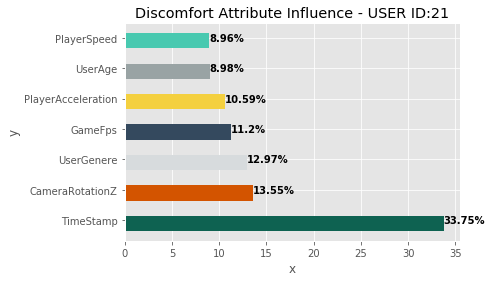

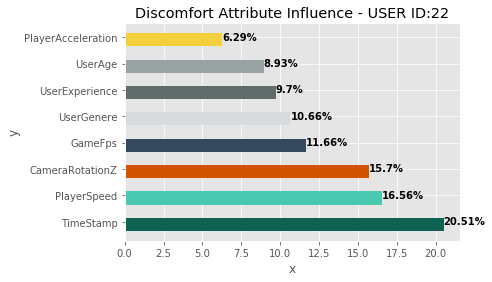

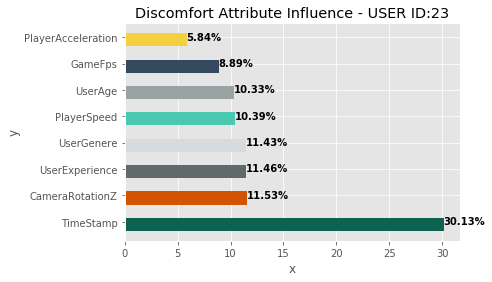

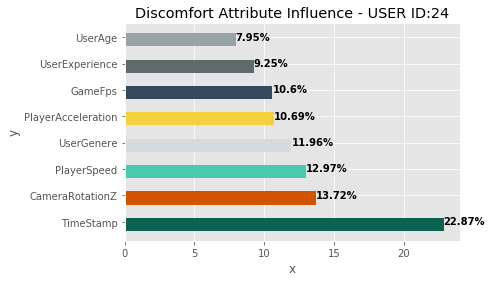

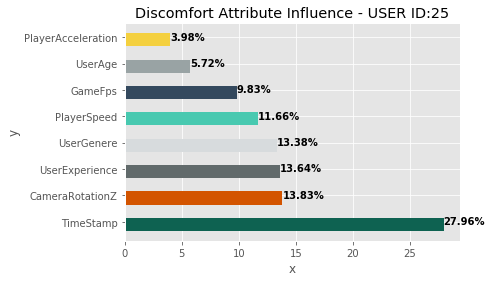

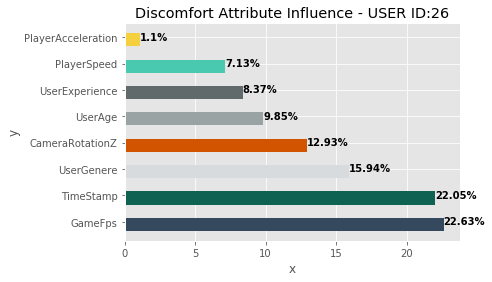

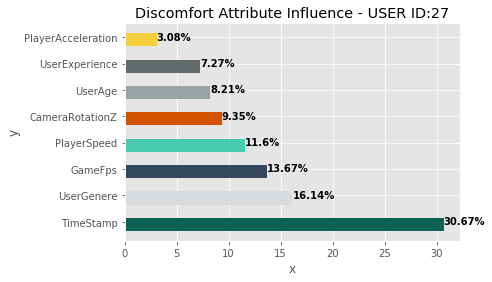

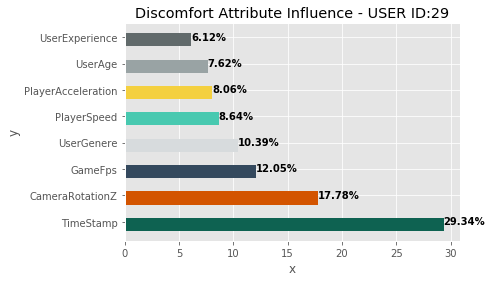

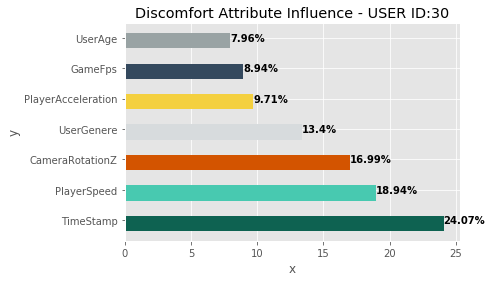

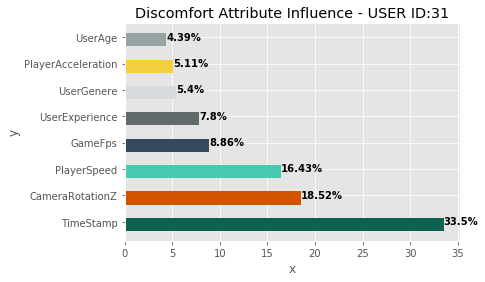

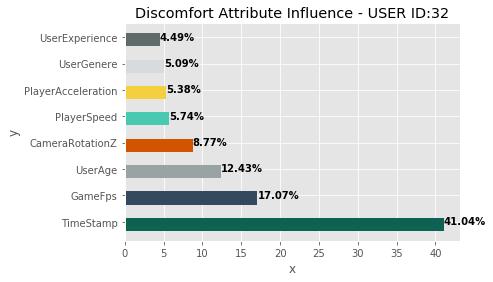

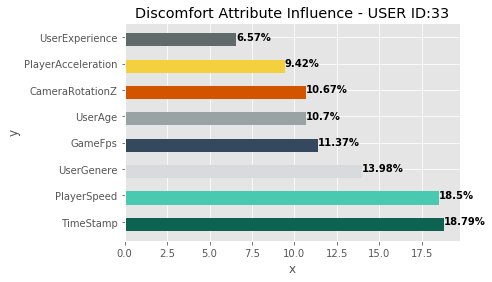

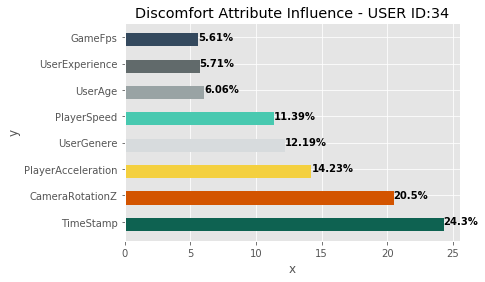

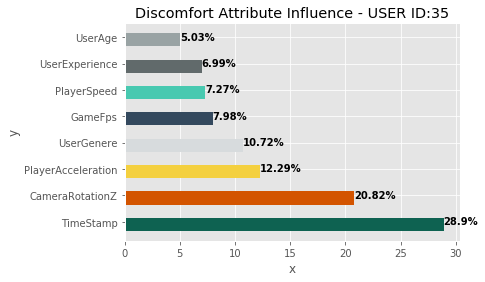

time: 33min 27s


In [85]:
databaseA = 'DATABASE_CARRO/'

# PREDICAO JOGO DO CARRO - PREDICAO DE DESCONFORTO PARA USUARIOS
TestUsersA =  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
ARF = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []

for userA in TestUsersA:
    print(userA)
    r = PredictDiscomfortAndCausesFromUserOutTrainingRF(databaseA, userA, 13, featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    ARF.append(r)


In [127]:
ARF[0]



,TimeStamp,prediction 21,real 21
0,0.0110195,0.0,0
1,1.005759,0.0,0
2,2.00784,0.0,0
3,3.007802,0.0,0
4,4.007293,0.0,0
5,5.008187,0.0,0
6,6.008643,0.0,0
7,7.009022,0.0,0
8,8.008588,0.0,0
9,9.008896,0.0,0


time: 150 ms




##Tarefas 23 09 2020
Vies do algoritmo foi comparar decision tree com random forest

Vies do dado - Rodar sem os dados de VRSq e com os dados do VRSQ (precisa ver como incluir)

Fazer distribuicao dos sccores do vrsq ao longo das instancias de cada usuario e incluir isso no treinamento (os 3 scores)


#Falar sobre o questionario do ssq vrsq que o minimo de tempo sao 20 minutos
#usuarios depois que acabaram a experiencia se sentiram bem.

# o usuario precisaria ficar mais tempo pros efeitos colaterais serem maiores


#relacionar os vrsq que tiveram mudanca com as causas


In [ ]:
#fazer o leaveoneout variando o parametro de profundidade

#Gera as arvores com numero de features na profundidade
#pegar o somatorio dos objetos que estao caindo em no folhas, pegar o minimo 

#O que acontece com o AUC 

# A profundiade minima = numero de features, maxima = ate 20 por enquanto
# - gerar dois graficos para cada usuario:
     #1) - em cima do conjunto de treinamento, vou olhar pra arvore 
     # construida e verificar qual o numero minimo de objetos que caiu em cada no folha
      
     #2) Fazer o leave one out e plotar para cada arvore a auc do treino e auc do teste (so calcula a curva )
     #com todas as profundidades
    
# 3) Variar a profundidade para gerar a AUC das RFs , utilizar os valores das melhores AUCs para gerar os graficos para comparar


#https://www.analytics-tuts.com/rank-chart-in-tableau/


#

User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  301
X_train = 6344 , X_test =  301 , y_train = 6344 , y_test = 301 , y_pred = 301
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9843401893777362
Testing AUC: 0.4434901960784313
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']
accuracy:  0.2724252491694352
Sample: 1 of 301
Sample:  [1 1 0 0.0 10 10 0.105867 0]
None Discomfort Predicted by RF
Sample: 2 of 301
Sample:  [1 1 0 1.008452 10 0 -0.001416319 90]
None Discomfort Predicted by RF
Sample: 3 of 301
Sample:  [1 1 0 2.008952 10 0 -0.00764419 90]
None Discomfort Predicted by RF
Sample: 4 of 301
Sample:  [1 1 0 2.998121 10 0 -0.01429484 90]
None Discomfort Predicted by RF
Sample: 5 of 301
Sample:  [1 1 0 4.008098 15

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 59 of 301
Sample:  [1 1 0 58.00098 75 5 -0.01968935 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 60 of 301
Sample:  [1 1 0 59.00069 75 0 -0.03251117 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 61 of 301
Sample:  [1 1 0 60.00073 80 5 -0.02568531 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 62 of 301
Sample:  [1 1 0 61.00047 85 5 -0.01363977 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 63 of 301
Sample:  [1 1 0 62.00139 85 0 -0.02140323 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 64 of 301
Sample:  [1 1 0 63.00077 90 5 -0.02552085 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 65 of 301
Samp

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 114 of 301
Sample:  [1 1 0 113.002 105 5 -0.01556173 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 115 of 301
Sample:  [1 1 0 114.0024 105 0 -0.02473289 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 116 of 301
Sample:  [1 1 0 115.0034 110 5 -0.0522388 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 117 of 301
Sample:  [1 1 0 116.002 110 0 -0.04624874 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 118 of 301
Sample:  [1 1 0 117.0019 115 5 -0.0399325 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 119 of 301
Sample:  [1 1 0 118.0023 120 5 -0.001858883 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 120 o

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 167 of 301
Sample:  [1 1 0 166.0025 100 5 -0.03195575 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 168 of 301
Sample:  [1 1 0 167.0026 100 0 -0.03963316 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 169 of 301
Sample:  [1 1 0 168.0026 105 5 -0.03536075 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 170 of 301
Sample:  [1 1 0 169.0018 105 0 -0.02831677 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 171 of 301
Sample:  [1 1 0 170.0021 110 5 -0.04377004 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 172 of 301
Sample:  [1 1 0 171.0024 115 5 -0.03639514 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 17

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 220 of 301
Sample:  [1 1 0 219.0033 35 0 -0.02934801 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 221 of 301
Sample:  [1 1 0 220.0022 35 0 -0.02855655 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 222 of 301
Sample:  [1 1 0 221.0022 40 5 -0.02427008 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 223 of 301
Sample:  [1 1 0 222.0025 40 0 -0.0181271 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 224 of 301
Sample:  [1 1 0 223.0027 40 0 -0.01866896 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 225 of 301
Sample:  [1 1 0 224.0029 45 5 -0.02012995 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 226 of 30

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 274 of 301
Sample:  [1 1 0 273.0031 20 5 -0.03125636 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 275 of 301
Sample:  [1 1 0 274.0025 20 0 -0.03250277 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 276 of 301
Sample:  [1 1 0 275.0034 20 0 -0.02619407 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 277 of 301
Sample:  [1 1 0 276.0022 20 0 -0.03338148 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 278 of 301
Sample:  [1 1 0 277.0026 25 5 -0.0292166 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 279 of 301
Sample:  [1 1 0 278.0023 25 0 -0.03655306 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 280 of 30

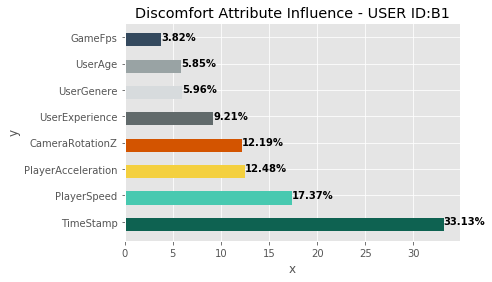

time: 4min 11s


In [44]:
#Teste com usuario Extra 20 minutos
database = 'DATABASE_PASSARO_EXTRA_B1/'
featuresOut = []
B1 = []
user = 'B1'
r = PredictDiscomfortAndCausesFromUserOutTrainingRF(database, user, 9,featuresOut) 
B1.append(r)


User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  300
X_train = 6344 , X_test =  300 , y_train = 6344 , y_test = 300 , y_pred = 300
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9849604197510053
Testing AUC: 0.42179555469468794
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']
accuracy:  0.36333333333333334
Sample: 1 of 300
Sample:  [1 1 0 301.0025 70 5 -0.02916345 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 2 of 300
Sample:  [1 1 0 302.0037 70 0 -0.02702395 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 3 of 300
Sample:  [1 1 0 303.0022 15 -55 -0.0261333 90]
  Discomfort Predicted by RF
    Estimato

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 51 of 300
Sample:  [1 1 0 351.0034 20 0 -0.03143485 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 52 of 300
Sample:  [1 1 0 352.0039 20 0 -0.01355379 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 53 of 300
Sample:  [1 1 0 353.0041 20 0 -0.01617748 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 54 of 300
Sample:  [1 1 0 354.005 25 5 -0.01831784 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 55 of 300
Sample:  [1 1 0 355.0041 25 0 -0.01712294 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 56 of 300
Sample:  [1 1 0 356.0043 25 0 -0.02392944 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 57 of 300
Sampl

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 113 of 300
Sample:  [1 1 0 413.0058 50 0 -0.02038956 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 114 of 300
Sample:  [1 1 0 414.0055 50 0 -0.01163013 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 115 of 300
Sample:  [1 1 0 415.004 15 -35 -0.01556358 74]
None Discomfort Predicted by RF
Sample: 116 of 300
Sample:  [1 1 0 416.0042 15 0 -0.03619644 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 117 of 300
Sample:  [1 1 0 417.0055 15 0 -0.03837688 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 118 of 300
Sample:  [1 1 0 418.0056 15 0 -0.03388868 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 119 of 300
Sample:  [1 1 0 419.0049 15 0 -0.03287762 90]
  Discomfo

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 169 of 300
Sample:  [1 1 0 469.0063 20 0 -0.0008102236 90]
None Discomfort Predicted by RF
Sample: 170 of 300
Sample:  [1 1 0 470.007 25 5 -0.01102124 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 171 of 300
Sample:  [1 1 0 471.0069 25 0 -0.002663865 90]
None Discomfort Predicted by RF
Sample: 172 of 300
Sample:  [1 1 0 472.0068 25 0 -0.003590816 90]
None Discomfort Predicted by RF
Sample: 173 of 300
Sample:  [1 1 0 473.0067 25 0 -0.004723331 90]
None Discomfort Predicted by RF
Sample: 174 of 300
Sample:  [1 1 0 474.0069 30 5 -0.005100683 90]
None Discomfort Predicted by RF
Sample: 175 of 300
Sample:  [1 1 0 475.0071 30 0 -0.005511566 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 176 of 300
Sample:  [1 1 0 476.0064 30 0 -0.005552923 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 

Sample: 224 of 300
Sample:  [1 1 0 524.0073 30 5 -0.02878456 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 225 of 300
Sample:  [1 1 0 525.0073 30 0 -0.02884232 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 226 of 300
Sample:  [1 1 0 526.0068 30 0 -0.028584 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 227 of 300
Sample:  [1 1 0 527.0073 35 5 -0.02939985 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 228 of 300
Sample:  [1 1 0 528.0076 35 0 -0.03062193 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 229 of 300
Sample:  [1 1 0 529.0072 35 0 -0.0314774 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 230 of 300
Sample:  [1 1 0 530.0074 40 5 -0.03250392 

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 284 of 300
Sample:  [1 1 0 584.0083 45 0 -0.004929399 90]
None Discomfort Predicted by RF
Sample: 285 of 300
Sample:  [1 1 0 585.0085 50 5 -0.002847276 90]
None Discomfort Predicted by RF
Sample: 286 of 300
Sample:  [1 1 0 586.0078 50 0 -0.008301681 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 287 of 300
Sample:  [1 1 0 587.008 50 0 -0.007635539 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 288 of 300
Sample:  [1 1 0 588.0084 15 -35 -0.008982306 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 289 of 300
Sample:  [1 1 0 589.0081 15 0 -0.01144877 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 290 of 300
Sample:  [1 1 0 590.0076 15 0 -0.00915642 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2

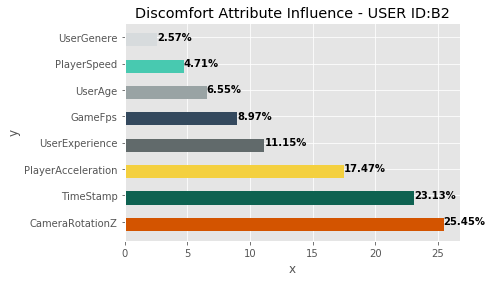

time: 3min 37s


In [48]:
database = 'DATABASE_PASSARO_EXTRA_B2/'
featuresOut = []
B2 = []
user = 'B2'
r = PredictDiscomfortAndCausesFromUserOutTrainingRF(database, user, 9,featuresOut) 
B2.append(r)


User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  300
X_train = 6344 , X_test =  300 , y_train = 6344 , y_test = 300 , y_pred = 300
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9829574548102963
Testing AUC: 0.3900717703349282
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']
accuracy:  0.48
Sample: 1 of 300
Sample:  [1 1 0 601.0097 30 5 -0.00655394 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 2 of 300
Sample:  [1 1 0 602.0093 30 0 0.02041037 90]
None Discomfort Predicted by RF
Sample: 3 of 300
Sample:  [1 1 0 603.0095 30 0 0.006591609 90]
None Discomfort Predicted by RF
Sample: 4 of 300
Sample:  [1 1 0 604.0098 35 5 -0.001392082 90]
  Discomfort Predicted 

    Estimator 3 of 3
Sample: 56 of 300
Sample:  [1 1 0 656.0124 15 0 -0.03896153 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 57 of 300
Sample:  [1 1 0 657.0119 15 0 -0.04166953 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 58 of 300
Sample:  [1 1 0 658.011 15 0 -0.008666358 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 59 of 300
Sample:  [1 1 0 659.0109 15 0 -0.01737037 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 60 of 300
Sample:  [1 1 0 660.0107 20 5 -0.01588786 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 61 of 300
Sample:  [1 1 0 661.0113 20 0 0.00557537 90]
None Discomfort Predicted by RF
Sample: 62 of 300
Sample:  [1 1 0 662.0118 20 0 0.04229003 90]
None Discomfort Predicted by RF
Sample: 6

    Estimator 3 of 3
Sample: 110 of 300
Sample:  [1 1 0 710.0122 15 0 -0.00208344 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 111 of 300
Sample:  [1 1 0 711.0116 20 5 0.03104415 90]
None Discomfort Predicted by RF
Sample: 112 of 300
Sample:  [1 1 0 712.0119 20 0 -0.006265089 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 113 of 300
Sample:  [1 1 0 713.0115 20 0 -0.1104721 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 114 of 300
Sample:  [1 1 0 714.0129 20 0 -0.04585235 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 115 of 300
Sample:  [1 1 0 715.001 25 5 -0.06308211 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 116 of 300
Sample:  [1 1 0 716.0017 25 0 -0.003742955 90]
  Discomfort Predicted by RF
    

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 173 of 300
Sample:  [1 1 0 773.0022 45 0 -0.03303891 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 174 of 300
Sample:  [1 1 0 774.0013 50 5 0.002692733 90]
None Discomfort Predicted by RF
Sample: 175 of 300
Sample:  [1 1 0 775.0016 50 0 -0.02014614 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 176 of 300
Sample:  [1 1 0 776.0017 55 5 -0.03380319 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 177 of 300
Sample:  [1 1 0 777.002 55 0 -0.03004217 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 178 of 300
Sample:  [1 1 0 778.002 60 5 -0.02143289 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 179 of 300
Sample:  [1 1 0 779.0015 60 0 -0.0229652 90]
  Discomfort P

    Estimator 3 of 3
Sample: 233 of 300
Sample:  [1 1 0 833.0029 100 5 -0.03075797 88]
None Discomfort Predicted by RF
Sample: 234 of 300
Sample:  [1 1 0 834.0027 100 0 -0.03624839 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 235 of 300
Sample:  [1 1 0 835.0021 105 5 -0.02288 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 236 of 300
Sample:  [1 1 0 836.0029 15 -90 -0.03534472 88]
None Discomfort Predicted by RF
Sample: 237 of 300
Sample:  [1 1 0 837.002 15 0 -0.02828177 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 238 of 300
Sample:  [1 1 0 838.0016 15 0 -0.05650369 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 239 of 300
Sample:  [1 1 0 839.0028 15 0 -0.05912008 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3

    Estimator 3 of 3
Sample: 292 of 300
Sample:  [1 1 0 892.0021 15 -115 -0.05299867 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 293 of 300
Sample:  [1 1 0 893.0019 15 0 -0.06273684 88]
None Discomfort Predicted by RF
Sample: 294 of 300
Sample:  [1 1 0 894.0021 15 0 -0.01800658 88]
None Discomfort Predicted by RF
Sample: 295 of 300
Sample:  [1 1 0 895.0017 15 0 0.09402063 88]
None Discomfort Predicted by RF
Sample: 296 of 300
Sample:  [1 1 0 896.0021 15 0 -0.04898983 88]
None Discomfort Predicted by RF
Sample: 297 of 300
Sample:  [1 1 0 897.0027 15 0 -0.0703638 88]
None Discomfort Predicted by RF
Sample: 298 of 300
Sample:  [1 1 0 898.0021 20 5 -0.02153316 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 299 of 300
Sample:  [1 1 0 899.0029 20 0 0.1175758 88]
None Discomfort Predicted by RF
Sample: 300 of 300
Sample:  [1 1 0 900.0025 20 0 0.07762325 88]
None Discomfort Pred

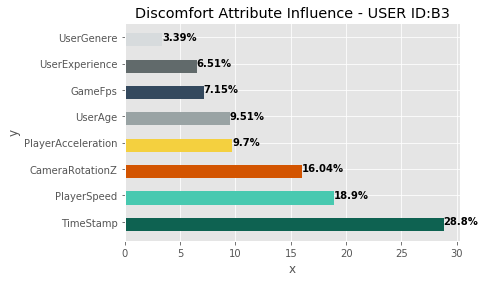

time: 2min 53s


In [49]:
database = 'DATABASE_PASSARO_EXTRA_B3/'
featuresOut = []
B3 = []
user = 'B3'
r = PredictDiscomfortAndCausesFromUserOutTrainingRF(database, user, 9,featuresOut) 
B3.append(r)


User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  301
X_train = 6344 , X_test =  301 , y_train = 6344 , y_test = 301 , y_pred = 301
Best Parameters  {'max_features': 'auto', 'n_estimators': 50}
Training AUC: 0.9848434401581301
Testing AUC: 0.6944444444444445
training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
training(users):  ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']
accuracy:  0.7475083056478405
Sample: 1 of 301
Sample:  [1 1 0 901.0023 20 0 -0.07886343 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 2 of 301
Sample:  [1 1 0 902.0021 25 5 -0.07641 88]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 3 of 301
Sample:  [1 1 0 903.0024 25 0 -0.08872189 88]
  Discomfort Predicted by RF
    Estimator 1 of

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 55 of 301
Sample:  [1 1 0 955.0032 15 -115 -0.01727417 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 56 of 301
Sample:  [1 1 0 956.0036 15 0 -0.02496912 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 57 of 301
Sample:  [1 1 0 957.0039 15 0 0.006000367 90]
None Discomfort Predicted by RF
Sample: 58 of 301
Sample:  [1 1 0 958.0042 15 0 0.03837081 90]
None Discomfort Predicted by RF
Sample: 59 of 301
Sample:  [1 1 0 959.0051 15 0 0.07827542 90]
None Discomfort Predicted by RF
Sample: 60 of 301
Sample:  [1 1 0 960.0042 20 5 0.004546645 88]
None Discomfort Predicted by RF
Sample: 61 of 301
Sample:  [1 1 0 961.0045 20 0 -0.1237115 90]
None Discomfort Predicted by RF
Sample: 62 of 301
Sample:  [1 1 0 962.0044 20 0 -0.1428247 90]
None Discomfort Predicted by RF
Sample: 63 of 301
Sample:  [1 1 0 963.0036 20 0 -0.1876612 90]
None Dis

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 121 of 301
Sample:  [1 1 0 1021.006 25 5 0.03726063 90]
None Discomfort Predicted by RF
Sample: 122 of 301
Sample:  [1 1 0 1022.006 25 0 0.01698332 90]
None Discomfort Predicted by RF
Sample: 123 of 301
Sample:  [1 1 0 1023.005 25 0 -0.0188852 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 124 of 301
Sample:  [1 1 0 1024.005 30 5 0.0311116 90]
None Discomfort Predicted by RF
Sample: 125 of 301
Sample:  [1 1 0 1025.005 30 0 -0.005705597 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 126 of 301
Sample:  [1 1 0 1026.005 30 0 -0.1052238 90]
None Discomfort Predicted by RF
Sample: 127 of 301
Sample:  [1 1 0 1027.005 35 5 -0.07035033 90]
None Discomfort Predicted by RF
Sample: 128 of 301
Sample:  [1 1 0 1028.004 35 0 -0.02039976 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample:

Sample: 182 of 301
Sample:  [1 1 0 1082.007 15 0 -0.009115266 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 183 of 301
Sample:  [1 1 0 1083.007 20 5 0.06285658 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 184 of 301
Sample:  [1 1 0 1084.008 20 0 -0.01833832 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 185 of 301
Sample:  [1 1 0 1085.007 20 0 -0.02273838 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 186 of 301
Sample:  [1 1 0 1086.007 20 0 -0.0003912268 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 187 of 301
Sample:  [1 1 0 1087.007 20 0 -0.009422323 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 188 of 301
Sample:  [1 1 0 1088.006 25 5 -0.010

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 239 of 301
Sample:  [1 1 0 1139.006 25 5 -0.01991799 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 240 of 301
Sample:  [1 1 0 1140.006 25 0 0.02393022 90]
None Discomfort Predicted by RF
Sample: 241 of 301
Sample:  [1 1 0 1141.006 25 0 0.02787256 90]
None Discomfort Predicted by RF
Sample: 242 of 301
Sample:  [1 1 0 1142.007 25 0 0.04926424 90]
None Discomfort Predicted by RF
Sample: 243 of 301
Sample:  [1 1 0 1143.006 30 5 -0.01356231 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 244 of 301
Sample:  [1 1 0 1144.005 30 0 -0.06972121 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 245 of 301
Sample:  [1 1 0 1145.005 30 0 -0.001365021 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 246 of 301
Sample:  [1 1 0 1146.0

    Estimator 2 of 3
    Estimator 3 of 3
Sample: 300 of 301
Sample:  [1 1 0 1200.009 30 0 -0.03112759 90]
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 301 of 301
Sample:  [1 1 0 1201.009 30 0 0.03169157 90]
None Discomfort Predicted by RF
['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience']
[9.71, 7.91, 15.52, 12.38, 40.67, 12.54, 1.27]


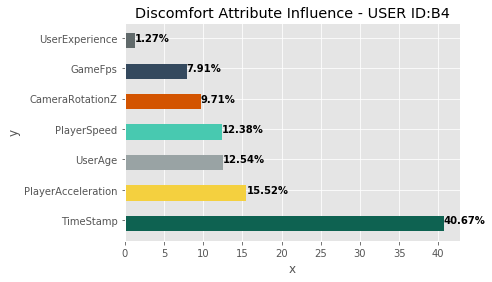

time: 2min 35s


In [50]:
database = 'DATABASE_PASSARO_EXTRA_B4/'
featuresOut = []
B4 = []
user = 'B4'
r = PredictDiscomfortAndCausesFromUserOutTrainingRF(database, user, 9,featuresOut) 
B4.append(r)


In [51]:
B1[0].style.hide_index()

TimeStamp,prediction B1,real B1
0,0,0
1.008452,0,0
2.008952,0,0
2.998121,0,0
4.008098,0,0
4.998371,0,0
5.999308,1,0
6.999945,0,0
7.999139,0,0
8.99884,0,0


time: 45.9 ms


In [52]:
B2[0].style.hide_index()

TimeStamp,prediction B2,real B2
301.0025,1,0
302.0037,1,0
303.0022,1,0
304.0036,1,0
305.0041,1,1
306.0036,1,1
307.0035,1,1
308.004,1,1
309.0043,1,0
310.0036,1,0


time: 54.9 ms


In [53]:
B3[0].style.hide_index()

TimeStamp,prediction B3,real B3
601.0097,1,1
602.0093,0,1
603.0095,0,1
604.0098,1,1
605.009,1,1
606.0096,1,1
607.0099,0,1
608.0095,1,1
609.0096,0,1
610.0099,1,1


time: 48.9 ms


In [54]:
B4[0].style.hide_index()

TimeStamp,prediction B4,real B4
901.0023,1,2
902.0021,1,3
903.0024,1,3
904.0023,0,3
905.0021,1,3
906.0027,0,3
907.0019,0,3
908.002,1,3
909.0025,1,3
910.0023,1,2


time: 46.9 ms
